# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Linear-Regression"><b>Analysis</b> - Linear-Regression</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import csv
import numpy
import os
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("Average Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Precision: ", precision_score(highestscore[3], highestscore[4]))
    print("Recall: ", recall_score(highestscore[3], highestscore[4]))
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)

    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision_score(highestscore[3], highestscore[4]), recall_score(highestscore[3], highestscore[4]), f1_score(highestscore[3], highestscore[4])
    
def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Precision: ", precision_score(highestscore[3], highestscore[4]))
    print("Recall: ", recall_score(highestscore[3], highestscore[4]))
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision_score(highestscore[3], highestscore[4]), recall_score(highestscore[3], highestscore[4]), f1_score(highestscore[3], highestscore[4])
    
def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])

        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Precision: ", precision_score(highestscore[3], highestscore[4]))
    print("Recall: ", recall_score(highestscore[3], highestscore[4]))
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision_score(highestscore[3], highestscore[4]), recall_score(highestscore[3], highestscore[4]), f1_score(highestscore[3], highestscore[4])

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    prec_1 = precision_score(y_test, predictions1)
    print("Precision score for model 1: ", prec_1)
    rec_1 = recall_score(y_test, predictions1)
    print("Recall score for model 1: ", rec_1)
    f1_1 = f1_score(y_test, predictions1)
    print("F1 score for model 1: ", f1_1)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    
    prec_2 = precision_score(y_test, predictions2)
    print("Precision score for model 2: ", prec_2)
    rec_2 = recall_score(y_test, predictions2)
    print("Recall score for model 2: ", rec_2)
    f1_2 = f1_score(y_test, predictions2)
    print("F1 score for model 2: ", f1_2)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''


    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    prec_1 = precision_score(y_test, predictions1)
    print("Precision score for model 1: ", prec_1)
    rec_1 = recall_score(y_test, predictions1)
    print("Recall score for model 1: ", rec_1)
    f1_1 = f1_score(y_test, predictions1)
    print("F1 score for model 1: ", f1_1)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    prec_2 = precision_score(y_test, predictions2)
    print("Precision score for model 2: ", prec_2)
    rec_2 = recall_score(y_test, predictions2)
    print("Recall score for model 2: ", rec_2)
    f1_2 = f1_score(y_test, predictions2)
    print("F1 score for model 2: ", f1_2)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f1 score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    
    
    fig = plt.figure()
    
    plt.title(f"PRC for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1\n-----------\n • PRC-AUC score: {auc(recall1[ix1:], precision1[ix1:]):.2f}\n • Best Threshold: {round(thresholds1[ix1], 2):.2f}\n • Best F1-Score: {round(fscore1[ix1], 2):.2f}\n")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2\n-----------\n • PRC-AUC score: {auc(recall2[ix2:], precision2[ix2:]):.2f}\n • Best Threshold: {round(thresholds2[ix2], 2):.2f}\n • Best F1-Score: {round(fscore2[ix2], 2):.2f}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    #plt.annotate('Model 1 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds1[ix1], fscore1[ix1]), (0.38, 0.35), fontsize=8)
    #plt.annotate('Model 2 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds2[ix2], fscore2[ix2]), (0.38, 0.3), fontsize=8)
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    #plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    #plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2], fig
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Linear Regression

In [3]:
# Make sure the data is from all dates
df = pd.read_csv("../Neo4j_output/Centrality_Output.csv")
# Replace NaN with 0 to include developers who did not introduce any bugs
df['Number_of_Bugs'] = df['Number_of_Bugs'].fillna(0)
print(df)

                    Name   PageRank    Betweenness  Closeness  Harmonic  \
0             Seth Vargo  24.098295  172342.464826   0.917656  0.955134   
1     Mitchell Hashimoto  24.093374  263957.868091   0.879363  0.931406   
2          Chris Roberts  21.082051  177846.949345   0.842297  0.906385   
3               tfanning  19.974389   59072.500908   0.847842  0.910267   
4             Brian Cain  19.631400  131598.446530   0.818503  0.889129   
...                  ...        ...            ...        ...       ...   
1155               winky   0.153670       0.000000   0.487179  0.492091   
1156           Yufan Lou   0.153324       0.000000   0.459010  0.471096   
1157       Aidan Feldman   0.152928       0.000000   0.488000  0.492954   
1158        Steven Leung   0.152204       0.000000   0.498066  0.499569   
1159             Murathe   0.150903       0.000000   0.487795  0.492522   

        Degree  Number_of_Bugs  
0     108731.0           233.0  
1     786949.0           865.0  


#### Predictions with sklearn

In [4]:
linear_regressor = LinearRegression()

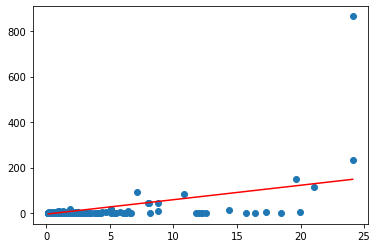

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     380.9
Date:                Sun, 24 Apr 2022   Prob (F-statistic):           1.47e-73
Time:                        00:13:06   Log-Likelihood:                -5312.7
No. Observations:                1160   AIC:                         1.063e+04
Df Residuals:                    1158   BIC:                         1.064e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4607      0.761     -5.859      0.0

In [5]:
x = df['PageRank'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [6]:
regression_results(y, y_pred)

explained_variance:  0.2475
r2:  0.2475
MAE:  4.8982
MSE:  556.645
RMSE:  23.5933


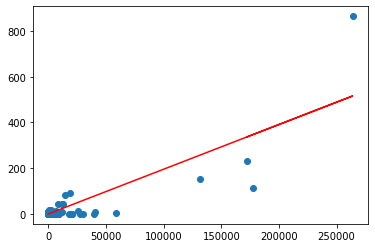

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     2846.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):          3.09e-314
Time:                        00:13:06   Log-Likelihood:                -4758.1
No. Observations:                1160   AIC:                             9520.
Df Residuals:                    1158   BIC:                             9530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4835      0.432     -1.120      0.2

In [7]:
x = df['Betweenness'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [8]:
regression_results(y, y_pred)

explained_variance:  0.7108
r2:  0.7108
MAE:  2.1069
MSE:  213.94
RMSE:  14.6267


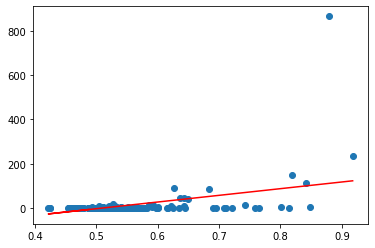

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     274.3
Date:                Sun, 24 Apr 2022   Prob (F-statistic):           1.84e-55
Time:                        00:13:07   Log-Likelihood:                -5354.3
No. Observations:                1160   AIC:                         1.071e+04
Df Residuals:                    1158   BIC:                         1.072e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -153.1468      9.375    -16.335      0.0

In [9]:
x = df['Closeness'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [10]:
regression_results(y, y_pred)

explained_variance:  0.1915
r2:  0.1915
MAE:  5.8539
MSE:  598.0523
RMSE:  24.4551


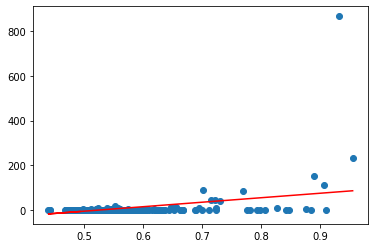

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     196.1
Date:                Sun, 24 Apr 2022   Prob (F-statistic):           2.85e-41
Time:                        00:13:07   Log-Likelihood:                -5386.9
No. Observations:                1160   AIC:                         1.078e+04
Df Residuals:                    1158   BIC:                         1.079e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -104.1860      7.597    -13.715      0.0

In [11]:
x = df['Harmonic'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [12]:
regression_results(y, y_pred)

explained_variance:  0.1448
r2:  0.1448
MAE:  5.983
MSE:  632.6194
RMSE:  25.1519


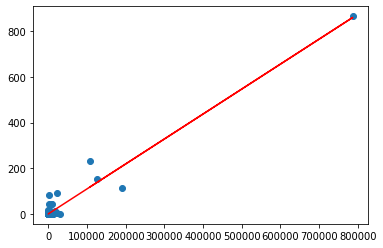

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 2.266e+04
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:13:07   Log-Likelihood:                -3724.0
No. Observations:                1160   AIC:                             7452.
Df Residuals:                    1158   BIC:                             7462.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1904      0.177      1.078      0.2

In [13]:
x = df['Degree'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [14]:
regression_results(y, y_pred)

explained_variance:  0.9514
r2:  0.9514
MAE:  1.0246
MSE:  35.9721
RMSE:  5.9977


In [15]:
x = df[['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']]
y = df['Number_of_Bugs']
#model = linear_regressor.fit(x, y)
#y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:         Number_of_Bugs   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     4607.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:13:08   Log-Likelihood:                -3712.9
No. Observations:                1160   AIC:                             7438.
Df Residuals:                    1154   BIC:                             7468.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -9.3917      7.621     -1.232      

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.16495729 0.25710611 0.10876171 0.12116565 0.34800924]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

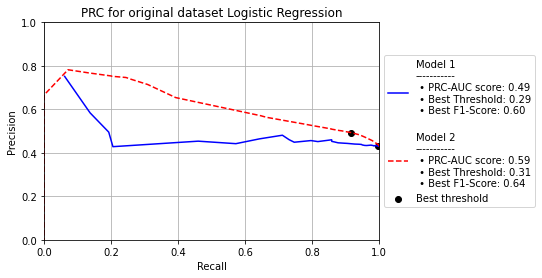

Best Threshold=0.309666, F1-Score=0.641 for model 1
Best Threshold=0.308829, F1-Score=0.641 for model 2


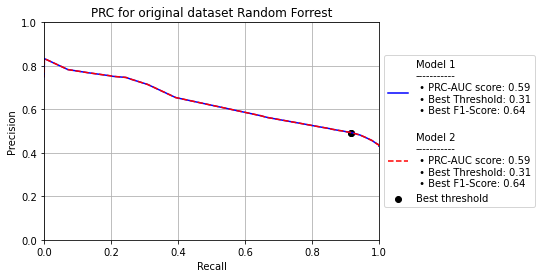

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


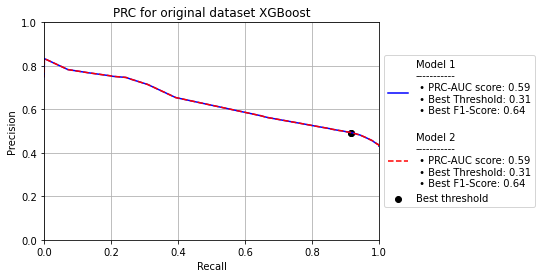


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

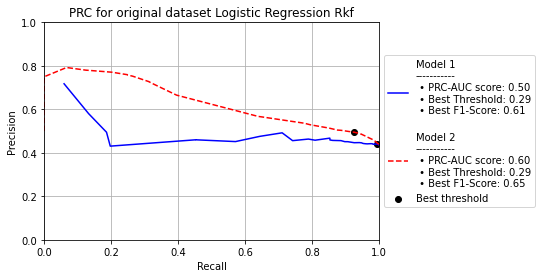

Best Threshold=0.295641, F1-Score=0.645 for model 1
Best Threshold=0.294421, F1-Score=0.645 for model 2


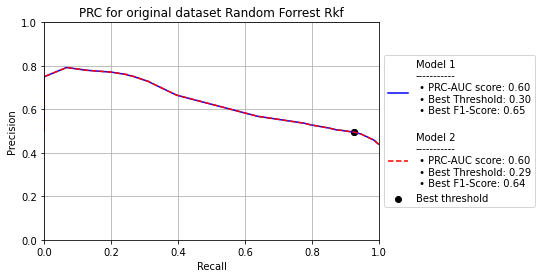

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


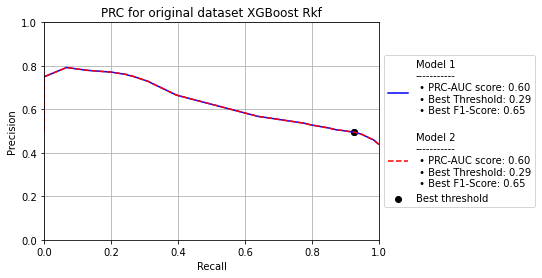

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


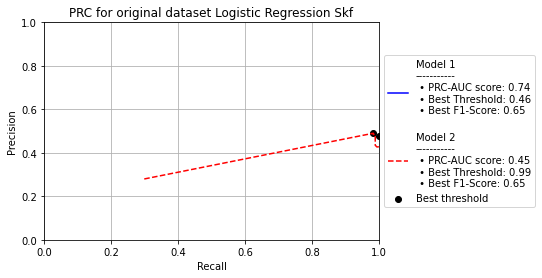

Best Threshold=1.000000, F1-Score=0.650 for model 1
Best Threshold=1.000000, F1-Score=0.650 for model 2


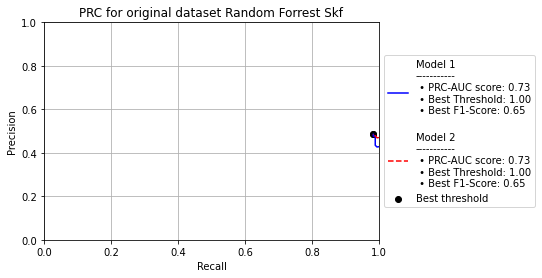

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


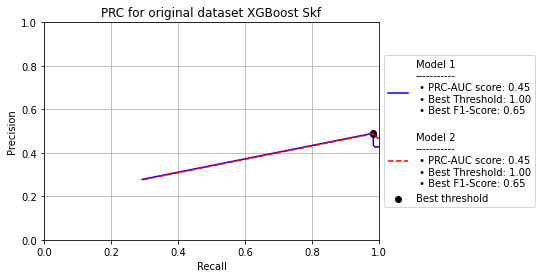

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


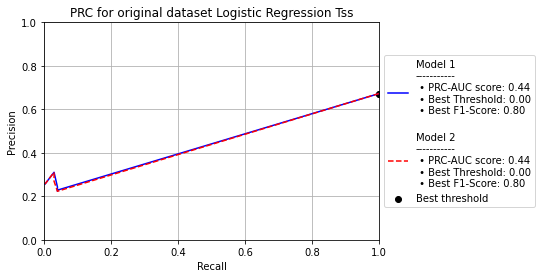

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


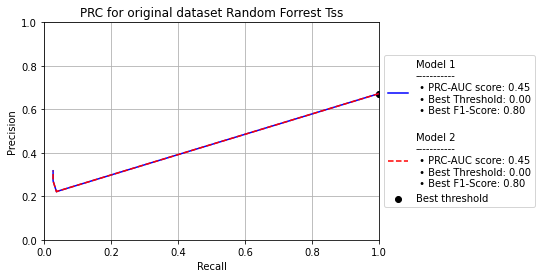

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


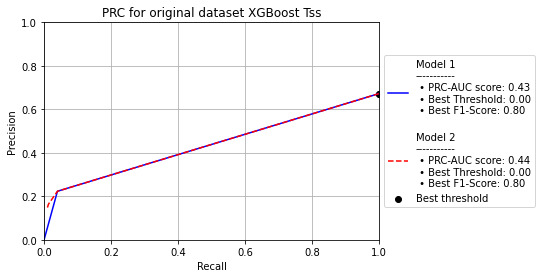

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  12   17   37   59   68   75   78  102  105  116  120  128  132  136
  138  145  166  168  197  211  213  221  225  228  230  236  250  266
  298  327  328  331  332  340  343  355  366  378  392  400  432  436
  444  445  452  453  454  495  507  515  523  527  538  550  551  591
  600  610  612  614  616  648  657  659  672  679  696  701  703  724
  741  752  760  766  768  769  772  773  780  790  797  802  803  818
  824  827  828  832  833  841  858  870  879  897  898  915  925  930
  940  941  943  945  949  961  964  990  992  994  999 1008 1009 1023
 1030 1040 1043 1047 1049 1057 1095 1102 1108 1124 1127 1144 1153 1172
 1176 1196 1197 1205 1209 1215 1218 1225 1228 1238 1258 1287 1295 1298
 1301 1305 1306 1311 1314 1316 1328 1346 1352 1357 1366 1370 1392 1400
 1412 1423 1426 1428 1429 1438 1447 1460 1463 1475 1483 1524 1526 1544
 1547 1550 1553 1554 1561 1563 1586 1598 1612 1624 1633 1642 1656 1668
 1672 1675 1686 1695 1700 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [2651 2657 2658 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729
 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743
 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757
 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771
 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785
 2786 2787 2788 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799
 2800 2801 2802 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813
 2814 2815 2816 2817 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827
 2828 2829 2830 2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841
 2842 2843 2844 2845 2846 

Precision:  0.532258064516129
Recall:  0.10060975609756098
F1:  0.16923076923076924
Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.90      0.63       305
           1       0.53      0.10      0.17       328

    accuracy                           0.49       633
   macro avg       0.51      0.50      0.40       633
weighted avg       0.51      0.49      0.39       633

Accuracy: 0.488
Mean Average-Precision Recall Score: 0.50813881325852
TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 26

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  12   17   37   59   68   75   78  102  105  116  120  128  132  136
  138  145  166  168  197  211  213  221  225  228  230  236  250  266
  298  327  328  331  332  340  343  355  366  378  392  400  432  436
  444  445  452  453  454  495  507  515  523  527  538  550  551  591
  600  610  612  614  616  648  657  659  672  679  696  701  703  724
  741  752  760  766  768  769  772  773  780  790  797  802  803  818
  824  827  828  832  833  841  858  870  879  897  898  915  925  930
  940  941  943  945  949  961  964  990  992  994  999 1008 1009 1023
 1030 1040 1043 1047 1049 1057 1095 1102 1108 1124 1127 1144 1153 1172
 1176 1196 1197 1205 1209 1215 1218 1225 1228 1238 1258 1287 1295 1298
 1301 1305 1306 1311 1314 1316 1328 1346 1352 1357 1366 1370 1392 1400
 1412 1423 1426 1428 1429 1438 1447 1460 1463 1475 1483 1524 1526 1544
 1547 1550 1553 1554 1561 1563 1586 1598 1612 1624 1633 1642 1656 1668
 1672 1675 1686 1695 1700 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [2651 2657 2658 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729
 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743
 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757
 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771
 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785
 2786 2787 2788 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799
 2800 2801 2802 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813
 2814 2815 2816 2817 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827
 2828 2829 2830 2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841
 2842 2843 2844 2845 2846 

TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 


Scores for model 1
------------------
Roc_Auc Score: 0.5414146752151304
Average Precision-Recall Score: 0.5327342136030004
PRC-AUC for model 1: 0.5449337462265496
Accuracy: 0.540
Precision score for model 1:  0.5327125408150926
Recall score for model 1:  0.638714354760754
F1 score for model 1:  0.5809174231267995
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.44      0.49     20741
           1       0.53      0.64      0.58     20690

    accuracy                           0.54     41431
   macro avg       0.54      0.54      0.54     41431
weighted avg       0.54      0.54      0.54     41431


Scores for model 2
------------------
Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6869772426005312
Precision score for model 2:  0.6349851717210371
Recall score for model 2:  0.6416143064282261
F1 score for model 2:  0.6382825271660736
Classification Report:

        

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     4     14     15 ... 138092 138093 138097]

Model Score: 0.5469949312092687
Average Precision-Recall Score: 0.5322439154792465
PRC-AUC Score: 0.7534972834814925
Precision:  0.5461313155967781
Recall:  0.6381916714204221
F1:  0.5885834538997763
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.45      0.50      6798
           1       0.55      0.64      0.59      7012

    accuracy                           0.55     13810
   macro avg       0.55      0.55      0.54     13810
weighted avg       0.55      0.55      0.54     13810

Accuracy: 0.547
Mean Average-Precision Recall Score: 0.5473592505177518
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall

Mean Average-Precision Recall Score: 0.6762676280709183
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734492193238303
Precision:  0.6517640337094701
Recall:  0.6478773250035497
F1:  0.6498148675591
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6767
           1       0.65      0.65      0.65      7043

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.644
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall:  0

F1 score for model 2:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64      0.64     41431
weighted avg       0.64      0.64      0.64     41431

Accuracy: 0.638

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6897138902737883
Accuracy: 0.638
Precision score for model 1:  0.6363418606879372
Recall score for model 1:  0.642311411992263
F1 score for model 1:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.5014197845008075
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6905
           1       0.75      0.75      0.75      6905

    accuracy                           0.75     13810
   macro avg       0.75      0.75      0.75     13810
weighted avg       0.75      0.75      0.75     13810

Accuracy: 0.748
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.7492394082194176
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classif

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.7313797604245118
Precision:  0.5631011704716653
Recall:  0.7036929761042723
F1:  0.625595468005665
Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6905
           1       0.56      0.70      0.63      6905

    accuracy                           0.58     13810
   macro avg       0.58      0.58      0.57     13810
weighted avg       0.58      0.58      0.57     13810

Accuracy: 0.579
Mean Average-Precision Recall Score: 0.44730726099028306
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.44200327068014184
Precision:  0.5631011704716653
Re

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.186043   0.27417661 0.11733691 0.11019739 0.31224609]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

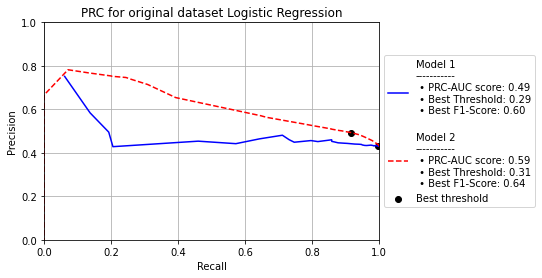

Best Threshold=0.308824, F1-Score=0.641 for model 1
Best Threshold=0.309343, F1-Score=0.641 for model 2


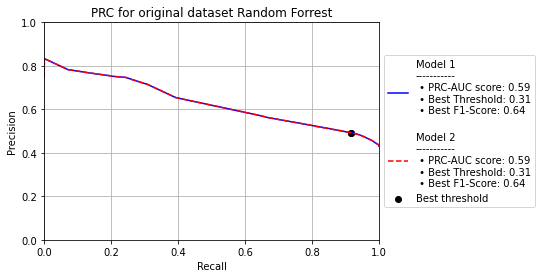

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


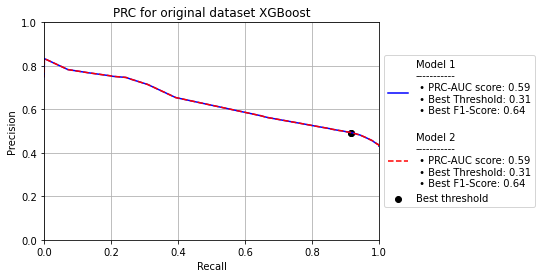


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

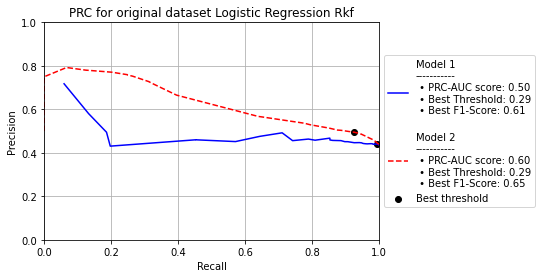

Best Threshold=0.292575, F1-Score=0.645 for model 1
Best Threshold=0.295705, F1-Score=0.645 for model 2


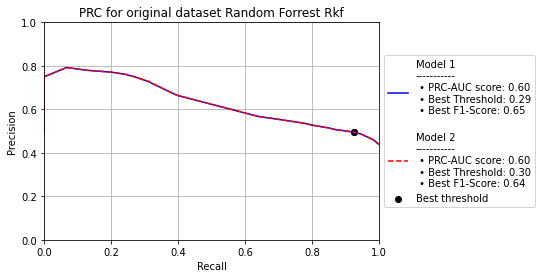

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


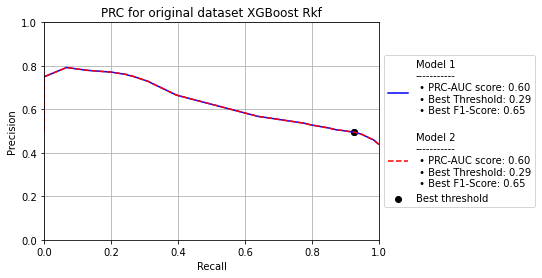

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


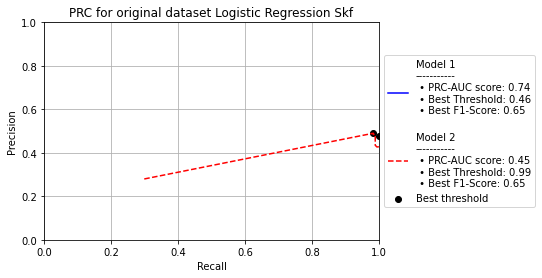

Best Threshold=1.000000, F1-Score=0.650 for model 1
Best Threshold=1.000000, F1-Score=0.650 for model 2


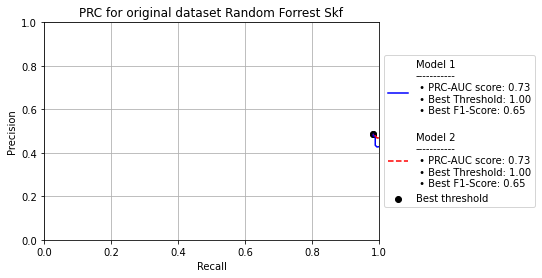

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


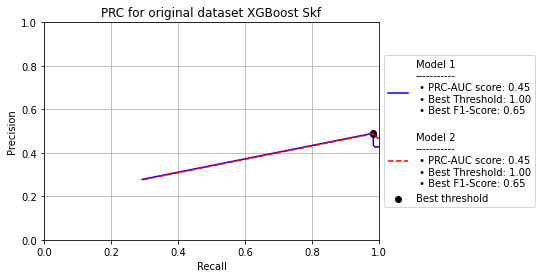

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


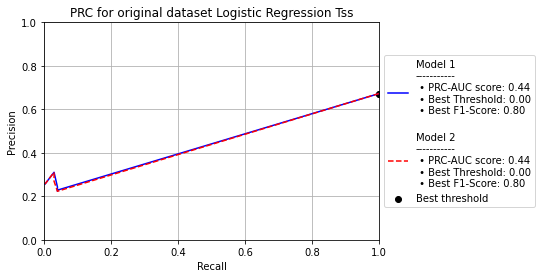

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


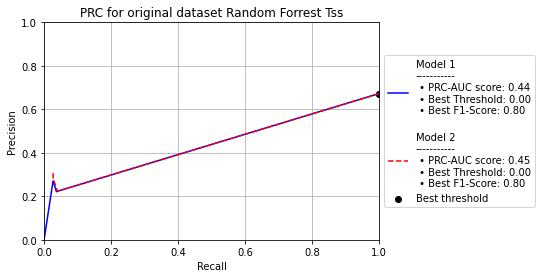

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


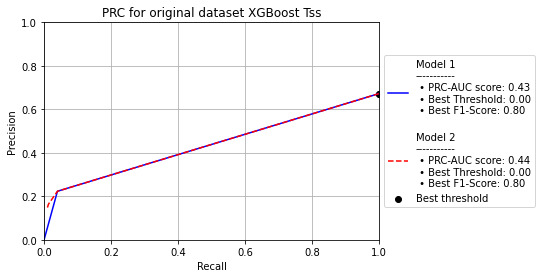

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  10   12   30   35   38   47   52   71   89  108  109  128  142  148
  151  178  183  206  209  225  226  235  269  272  275  287  292  295
  307  327  336  359  386  405  416  423  446  459  464  471  485  497
  529  536  563  564  570  583  613  627  636  639  653  667  669  678
  687  698  721  724  732  765  776  779  780  782  795  804  826  829
  832  844  848  851  861  870  883  884  886  896  903  905  910  912
  915  917  925  935  939  941  944  951  952  967  971  975  978  984
 1000 1016 1028 1036 1037 1051 1052 1066 1067 1083 1086 1094 1095 1098
 1112 1117 1121 1141 1150 1186 1194 1204 1209 1218 1224 1229 1251 1252
 1256 1260 1262 1269 1273 1278 1291 1294 1305 1319 1332 1344 1350 1351
 1366 1378 1394 1398 1445 1447 1448 1462 1469 1490 1492 1494 1496 1504
 1517 1520 1574 1590 1591 1601 1602 1610 1612 1630 1654 1666 1678 1690
 1695 1710 1711 1715 1719 1724 1735 1738 1743 1745 1748 1749 1754 1756
 1770 1773 1774 1791 1806 

 1180 1183]

Model Score: 0.531578947368421

Average Precision-Recall Score: 0.5169308814204185
PRC-AUC Score: 0.5135004467377201
Precision:  0.536144578313253
Recall:  0.46842105263157896
F1:  0.5000000000000001
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.59      0.56       190
           1       0.54      0.47      0.50       190

    accuracy                           0.53       380
   macro avg       0.53      0.53      0.53       380
weighted avg       0.53      0.53      0.53       380

Accuracy: 0.532
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [ 715  719  721  722  723  724  726  729  730  734  737  738  739  746
  755  756  758  759  762  763  765  766  768  770  772  782  783  784
  787  788  790  791  792  793  794  795  796  797  798  799  800  801
  802  803  804  805  806  807  808  809  810  811  812  813  814  815
  816  817  818  819  820  821  822  823  824  825  826  827  828  829
  830  831  83

Precision:  0.5363636363636364
Recall:  0.34502923976608185
F1:  0.4199288256227757
Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.65      0.54       291
           1       0.54      0.35      0.42       342

    accuracy                           0.48       633
   macro avg       0.50      0.50      0.48       633
weighted avg       0.50      0.48      0.47       633

Accuracy: 0.485
Mean Average-Precision Recall Score: 0.5150771221784115
TRAIN: [   0    1    2 ... 1265 1266 1267] | TEST: [1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281
 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295
 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309
 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323
 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337
 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351
 1352 1353 1354 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  10   12   30   35   38   47   52   71   89  108  109  128  142  148
  151  178  183  206  209  225  226  235  269  272  275  287  292  295
  307  327  336  359  386  405  416  423  446  459  464  471  485  497
  529  536  563  564  570  583  613  627  636  639  653  667  669  678
  687  698  721  724  732  765  776  779  780  782  795  804  826  829
  832  844  848  851  861  870  883  884  886  896  903  905  910  912
  915  917  925  935  939  941  944  951  952  967  971  975  978  984
 1000 1016 1028 1036 1037 1051 1052 1066 1067 1083 1086 1094 1095 1098
 1112 1117 1121 1141 1150 1186 1194 1204 1209 1218 1224 1229 1251 1252
 1256 1260 1262 1269 1273 1278 1291 1294 1305 1319 1332 1344 1350 1351
 1366 1378 1394 1398 1445 1447 1448 1462 1469 1490 1492 1494 1496 1504
 1517 1520 1574 1590 1591 1601 1602 1610 1612 1630 1654 1666 1678 1690
 1695 1710 1711 1715 1719 1724 1735 1738 1743 1745 1748 1749 1754 1756
 1770 1773 1774 1791 1806 

TRAIN: [   0    1    2 ... 3423 3424 3425] | TEST: [3408 3412 3415 3416 3420 3421 3426 3427 3428 3429 3430 3431 3432 3433
 3434 3435 3436 3437 3438 3439 3440 3441 3442 3443 3444 3445 3446 3447
 3448 3449 3450 3451 3452 3453 3454 3455 3456 3457 3458 3459 3460 3461
 3462 3463 3464 3465 3466 3467 3468 3469 3470 3471 3472 3473 3474 3475
 3476 3477 3478 3479 3480 3481 3482 3483 3484 3485 3486 3487 3488 3489
 3490 3491 3492 3493 3494 3495 3496 3497 3498 3499 3500 3501 3502 3503
 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517
 3518 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531
 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545
 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559
 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573
 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587
 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601
 3602 3603 3604 3605 3606 

TRAIN: [   0    1    2 ... 1265 1266 1267] | TEST: [1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281
 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295
 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309
 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323
 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337
 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351
 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365
 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379
 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393
 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407
 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421
 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435
 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448 1449
 1450 1451 1452 1453 1454 


Scores for model 1
------------------
Roc_Auc Score: 0.5414146752151304
Average Precision-Recall Score: 0.5327342136030004
PRC-AUC for model 1: 0.5449337462265496
Accuracy: 0.540
Precision score for model 1:  0.5327125408150926
Recall score for model 1:  0.638714354760754
F1 score for model 1:  0.5809174231267995
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.44      0.49     20741
           1       0.53      0.64      0.58     20690

    accuracy                           0.54     41431
   macro avg       0.54      0.54      0.54     41431
weighted avg       0.54      0.54      0.54     41431


Scores for model 2
------------------
Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6869772426005312
Precision score for model 2:  0.6349851717210371
Recall score for model 2:  0.6416143064282261
F1 score for model 2:  0.6382825271660736
Classification Report:

        

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     4     14     15 ... 138092 138093 138097]

Model Score: 0.5469949312092687
Average Precision-Recall Score: 0.5322439154792465
PRC-AUC Score: 0.7534972834814925
Precision:  0.5461313155967781
Recall:  0.6381916714204221
F1:  0.5885834538997763
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.45      0.50      6798
           1       0.55      0.64      0.59      7012

    accuracy                           0.55     13810
   macro avg       0.55      0.55      0.54     13810
weighted avg       0.55      0.55      0.54     13810

Accuracy: 0.547
Mean Average-Precision Recall Score: 0.5473592505177518
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall

Mean Average-Precision Recall Score: 0.6762676280709183
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734492193238303
Precision:  0.6517640337094701
Recall:  0.6478773250035497
F1:  0.6498148675591
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6767
           1       0.65      0.65      0.65      7043

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.644
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall:  0

Recall score for model 2:  0.642311411992263
F1 score for model 2:  0.6392973168090483
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64      0.64     41431
weighted avg       0.64      0.64      0.64     41431

Accuracy: 0.638

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6897138902737883
Accuracy: 0.638
Precision score for model 1:  0.6363418606879372
Recall score for model 1:  0.642311411992263
F1 score for model 1:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.6

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.5014197845008075
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6905
           1       0.75      0.75      0.75      6905

    accuracy                           0.75     13810
   macro avg       0.75      0.75      0.75     13810
weighted avg       0.75      0.75      0.75     13810

Accuracy: 0.748
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.7492394082194176
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classif

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.7313797604245118
Precision:  0.5631011704716653
Recall:  0.7036929761042723
F1:  0.625595468005665
Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6905
           1       0.56      0.70      0.63      6905

    accuracy                           0.58     13810
   macro avg       0.58      0.58      0.57     13810
weighted avg       0.58      0.58      0.57     13810

Accuracy: 0.579
Mean Average-Precision Recall Score: 0.44730726099028306
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.44100295147581636
Precision:  0.5631011704716653
Re

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.18597318 0.23807817 0.10416065 0.119093   0.352695  ]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

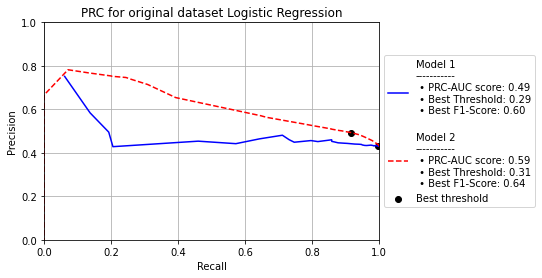

Best Threshold=0.309708, F1-Score=0.641 for model 1
Best Threshold=0.306655, F1-Score=0.641 for model 2


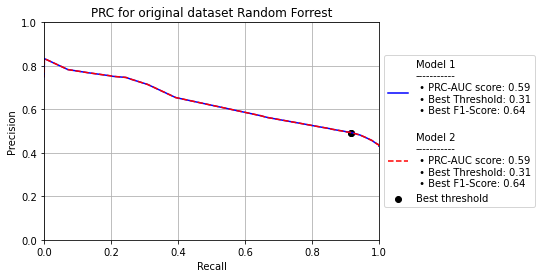

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


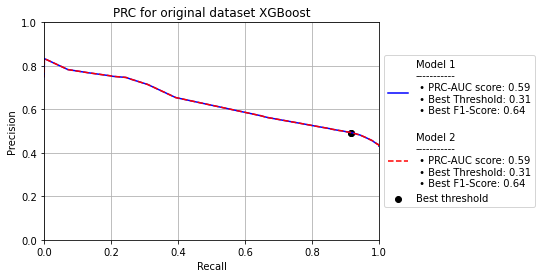


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

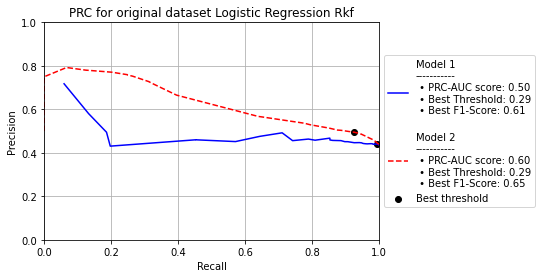

Best Threshold=0.295358, F1-Score=0.645 for model 1
Best Threshold=0.294821, F1-Score=0.645 for model 2


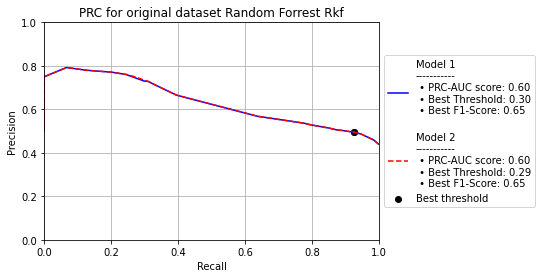

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


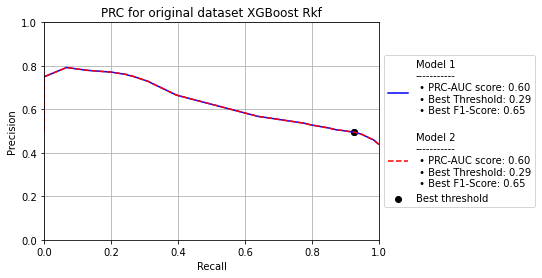

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


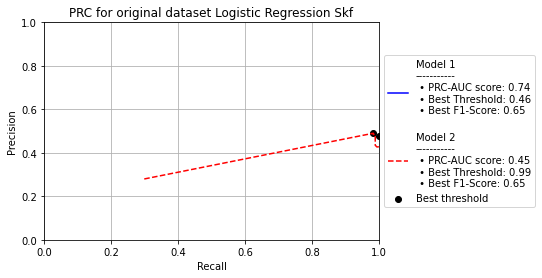

Best Threshold=1.000000, F1-Score=0.650 for model 1
Best Threshold=0.418826, F1-Score=0.651 for model 2


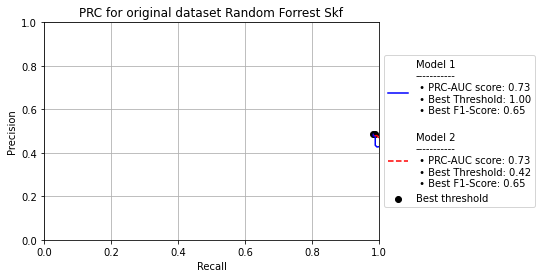

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


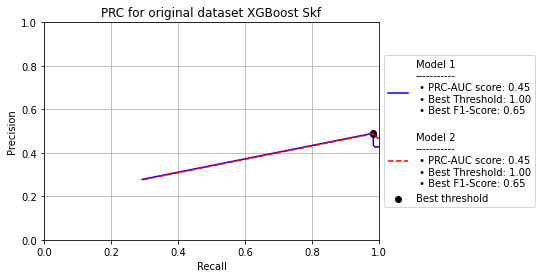

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


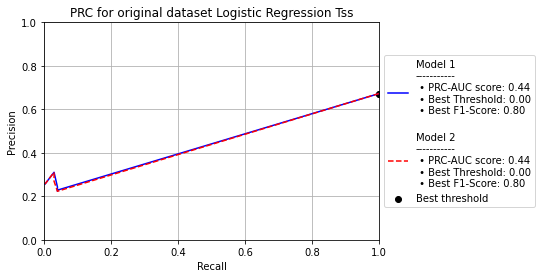

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


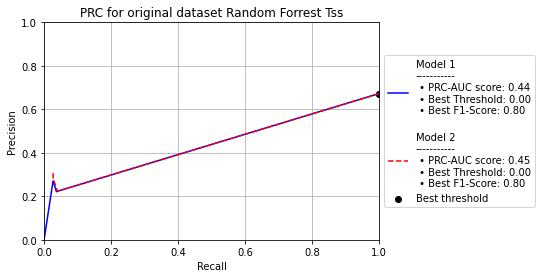

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


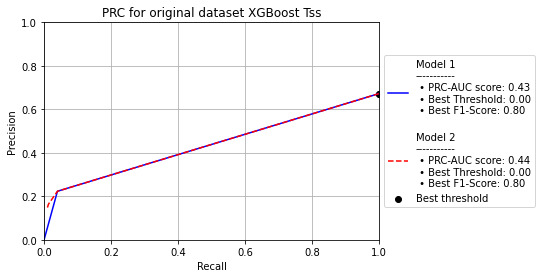

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  30   45   46   57   61   66   74   99  100  104  111  114  129  139
  158  171  175  180  199  215  237  247  254  269  275  277  282  296
  306  312  319  357  361  370  372  385  396  411  429  438  449  455
  460  473  485  490  505  514  519  535  540  541  546  548  555  556
  578  579  596  601  602  604  613  615  618  627  628  631  661  664
  670  675  677  682  719  726  748  753  754  767  784  787  804  808
  810  811  812  825  847  873  885  886  891  904  911  913  920  926
  928  977  981 1000 1013 1025 1035 1044 1051 1052 1055 1062 1065 1081
 1092 1096 1098 1105 1122 1126 1129 1132 1135 1146 1148 1152 1221 1235
 1239 1240 1244 1266 1272 1293 1294 1308 1322 1353 1354 1356 1365 1377
 1379 1391 1395 1411 1414 1416 1417 1430 1448 1452 1456 1464 1468 1471
 1477 1481 1487 1505 1507 1515 1521 1537 1538 1555 1557 1559 1560 1564
 1581 1588 1600 1601 1603 1615 1620 1632 1635 1638 1645 1663 1665 1667
 1681 1689 1699 1717 1745 


Accuracy: 0.534
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [2655 2656 2658 2659 2660 2662 2665 2666 2667 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729
 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743
 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757
 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771
 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785
 2786 2787 2788 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799
 2800 2801 2802 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813
 2814 2815 2816 2817 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827
 2828 2829 2830 2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841
 2842 284

Mean Average-Precision Recall Score: 0.5140415562322044
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  19   40   41   48   50   56   69   73   87   91   93  106  116  118
  119  167  176  179  185  199  217  233  237  239  245  257  281  301
  308  321  349  354  355  361  367  372  379  381  393  396  403  407
  427  435  436  445  457  468  486  503  511  513  518  540  544  552
  557  576  623  632  642  647  663  671  674  675  694  711  714  715
  723  735  737  739  742  743  763  772  775  785  792  800  811  814
  815  835  853  866  879  895  927  928  932  957  965  970  994  995
 1021 1027 1034 1057 1075 1081 1087 1120 1138 1142 1143 1146 1156 1168
 1174 1175 1188 1207 1221 1244 1253 1266 1267 1276 1280 1309 1312 1315
 1321 1324 1335 1346 1368 1370 1373 1374 1383 1400 1405 1410 1418 1420
 1429 1438 1439 1452 1463 1478 1486 1489 1500 1508 1509 1511 1527 1539
 1562 1575 1604 1628 1651 1663 1669 1702 1703 1713 1721 1728 1729 1733
 1747 1771 1784 1785 1786 1798 1809 1875 1893 1896 1897 1905 1908 1926
 1927 1933 1958 1967 1985 

TRAIN: [ 371  372  374 ... 3797 3798 3799] | TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233


TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334
 3335 3336 3337 3338 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348
 3349 3350 3351 3352 3353 

TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334
 3335 3336 3337 3338 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348
 3349 3350 3351 3352 3353 

Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6457632598119071
Precision score for model 2:  0.55513906375186
Recall score for model 2:  0.9376993716771387
F1 score for model 2:  0.6974010568316619
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.25      0.38     20741
           1       0.56      0.94      0.70     20690

    accuracy                           0.59     41431
   macro avg       0.68      0.59      0.54     41431
weighted avg       0.68      0.59      0.54     41431

Accuracy: 0.594

Scores for model 1
------------------
Roc_Auc Score: 0.698020440317927
Average Precision-Recall Score: 0.672590092617928
PRC-AUC for model 1: 0.6481508086729203
Accuracy: 0.594
Precision score for model 1:  0.5551422194242546
Recall score for model 1:  0.9376510391493476
F1 score for model 1:  0.6973901790207779
Classification Report:

              precision    recall 

TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.9748626565351836
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.15      1.00      0.26      3390
           1       0.00      0.00      0.00     19627

    accuracy                           0.15     23017
   macro avg       0.07      0.50      0.13     23017
weighted avg       0.02      0.15      0.04     23017

Accuracy: 0.147
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.932561245495237
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0     

TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.3662944779945258

Average Precision-Recall Score: 0.8106145860687655
PRC-AUC Score: 0.9234657733617746
Precision:  0.7449227480322612
Recall:  0.3905843990421358
F1:  0.51246741092319
Classification Report:

              precision    recall  f1-score   support

           0       0.06      0.23      0.09      3390
           1       0.74      0.39      0.51     19627

    accuracy                           0.37     23017
   macro avg       0.40      0.31      0.30     23017
weighted avg       0.64      0.37      0.45     23017

Accuracy: 0.366
Mean Average-Precision Recall Score: 0.5565300744661613
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.4063952730590433

Average Precision-Recall Score: 0.8974718487629366
PRC-AUC Score: 0.9636757873171443
Precision:  1.0
Recall:  0.303867121

Accuracy: 0.597

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6503288018053685
Accuracy: 0.599
Precision score for model 1:  0.5583043939959246
Recall score for model 1:  0.9406673114119922
F1 score for model 1:  0.7007186211119716
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.26      0.39     20751
           1       0.56      0.94      0.70     20680

    accuracy                           0.60     41431
   macro avg       0.69      0.60      0.55     41431
weighted avg       0.69      0.60      0.55     41431


Scores for model 2
------------------
Roc_Auc Score: 0.7020334971156107
Average Precision-Recall Score: 0.6756572483351841
PRC-AUC for model 2: 0.6503288018053685
Precision score for model 2:  0.5583043939959246
Recall score for model 2:  0.9406673114119922
F1 score for model 2:  0.7007186211119716
Classification 

TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.24395012382152323
F1:  0.392218496786812
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
TRAIN: [     0      2      3 ... 138099 138100 138101] | TEST: [     1      7     12 ... 138073 138090 138098]

Model Score: 0.6420709630702389
Average Precision-Recall Score: 0.597485579456884
PRC-AUC Score: 0.6540909129062146
Precision:  0.6466229695069821
Recall:  0.6481931152692473
F1:  0.647407090377345
Classification Report:

              precision    recall  f

TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.24395012382152323
F1:  0.392218496786812
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
                                                 Test  Model1 score  \
0                        Original_Logistic_Regression      0.570255   
1                             Original_Random_Forrest      0.650068   
2                             Original_XGB_Classifier      0.650068   
3         Original_Logistic_Regression_Best_Threshold      0.570255   
4              

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.18316621 0.24988955 0.11264092 0.1117306  0.34257272]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

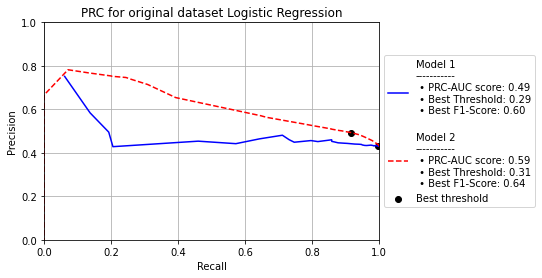

Best Threshold=0.309115, F1-Score=0.641 for model 1
Best Threshold=0.306850, F1-Score=0.641 for model 2


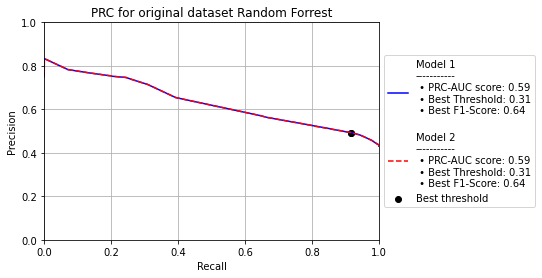

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


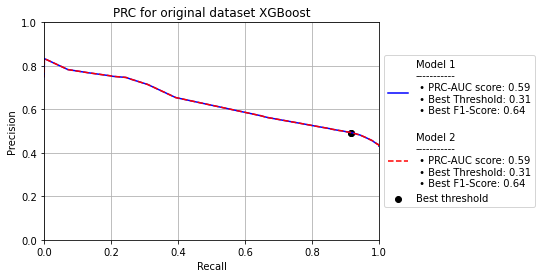


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

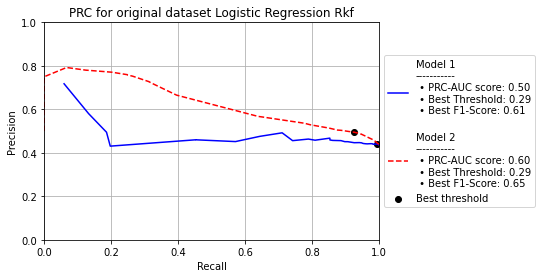

Best Threshold=0.293732, F1-Score=0.645 for model 1
Best Threshold=0.293293, F1-Score=0.645 for model 2


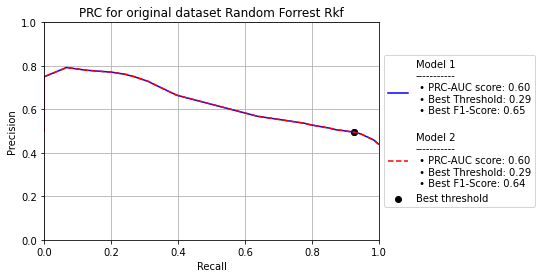

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


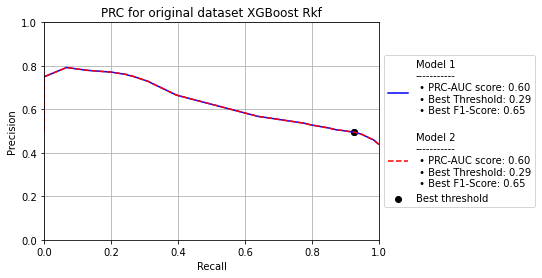

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


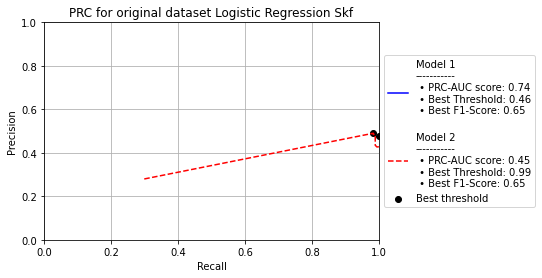

Best Threshold=1.000000, F1-Score=0.650 for model 1
Best Threshold=1.000000, F1-Score=0.650 for model 2


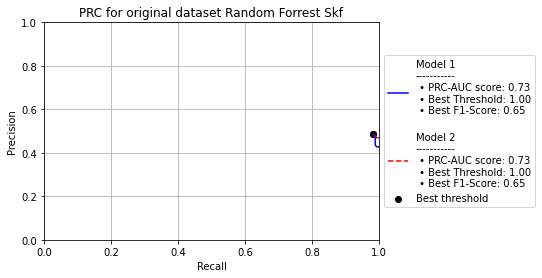

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


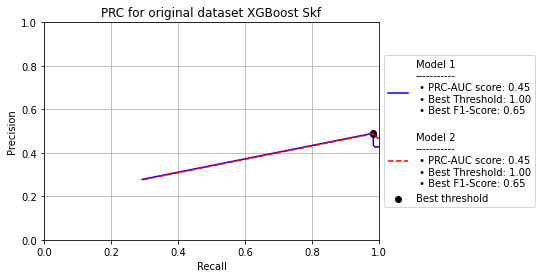

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


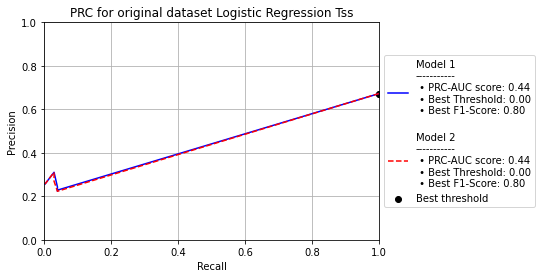

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


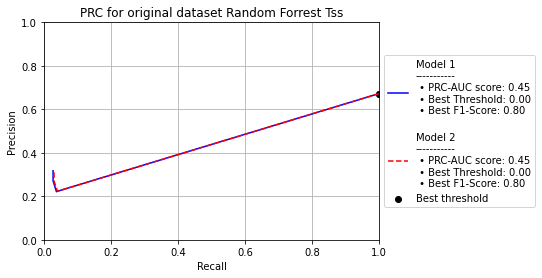

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


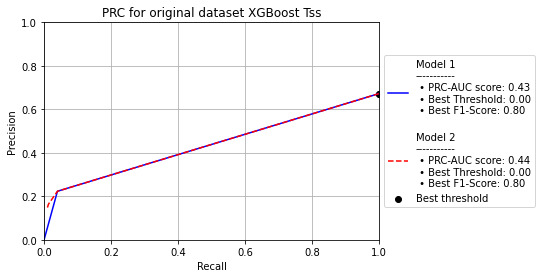

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  19   40   41   48   50   56   69   73   87   91   93  106  116  118
  119  167  176  179  185  199  217  233  237  239  245  257  281  301
  308  321  349  354  355  361  367  372  379  381  393  396  403  407
  427  435  436  445  457  468  486  503  511  513  518  540  544  552
  557  576  623  632  642  647  663  671  674  675  694  711  714  715
  723  735  737  739  742  743  763  772  775  785  792  800  811  814
  815  835  853  866  879  895  927  928  932  957  965  970  994  995
 1021 1027 1034 1057 1075 1081 1087 1120 1138 1142 1143 1146 1156 1168
 1174 1175 1188 1207 1221 1244 1253 1266 1267 1276 1280 1309 1312 1315
 1321 1324 1335 1346 1368 1370 1373 1374 1383 1400 1405 1410 1418 1420
 1429 1438 1439 1452 1463 1478 1486 1489 1500 1508 1509 1511 1527 1539
 1562 1575 1604 1628 1651 1663 1669 1702 1703 1713 1721 1728 1729 1733
 1747 1771 1784 1785 1786 1798 1809 1875 1893 1896 1897 1905 1908 1926
 1927 1933 1958 1967 1985 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1490 1491 1494 1495 1496 1499 1501 1503 1504 1505 1508 1511 1513 1514
 1515 1517 1518 1520 1521 1522 1523 1525 1526 1528 1529 1534 1535 1537
 1539 1543 1545 1548 1549 1551 1554 1555 1556 1557 1558 1559 1560 1561
 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575
 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589
 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603
 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617
 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631
 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645
 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659
 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673
 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687
 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701
 1702 1703 1704 1705 1706 

Mean Average-Precision Recall Score: 0.5077821966671479
TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 

TRAIN: [   0    1    3 ... 3797 3798 3799] | TEST: [   2    6    8   13   20   23   37   39   53   71   83   86   91  105
  115  121  142  145  158  159  169  207  213  222  244  265  271  273
  277  287  292  294  306  308  311  316  339  348  352  377  382  394
  398  409  425  427  431  444  447  453  458  476  483  514  519  526
  548  552  556  571  579  583  585  588  590  591  634  672  674  686
  694  696  704  715  737  749  754  771  778  780  792  800  806  808
  824  849  861  873  885  886  888  892  902  906  908  913  917  923
  947  963  970  973  974  983  988  993 1007 1043 1050 1054 1083 1085
 1087 1096 1098 1109 1137 1165 1170 1189 1193 1199 1230 1245 1247 1259
 1265 1266 1274 1285 1290 1325 1328 1337 1343 1349 1355 1375 1380 1382
 1389 1393 1410 1413 1418 1435 1448 1453 1463 1486 1518 1530 1544 1547
 1559 1560 1562 1567 1576 1590 1591 1594 1596 1607 1640 1666 1689 1690
 1709 1710 1711 1713 1714 1716 1723 1737 1746 1748 1756 1763 1771 1776
 1809 1835 1840 1868 1883 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [359 360 361 362 363 366 367 370 371 373 374 375 376 381 382 384 385 386
 387 392 394 397 398 402 403 404 405 407 408 409 410 411 412 413 414 415
 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433
 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487
 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505
 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523
 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577
 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595
 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613


TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 


Scores for model 1
------------------
Roc_Auc Score: 0.5414146752151304
Average Precision-Recall Score: 0.5327342136030004
PRC-AUC for model 1: 0.5449337462265496
Accuracy: 0.540
Precision score for model 1:  0.5327125408150926
Recall score for model 1:  0.638714354760754
F1 score for model 1:  0.5809174231267995
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.44      0.49     20741
           1       0.53      0.64      0.58     20690

    accuracy                           0.54     41431
   macro avg       0.54      0.54      0.54     41431
weighted avg       0.54      0.54      0.54     41431


Scores for model 2
------------------
Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6869772426005312
Precision score for model 2:  0.6349851717210371
Recall score for model 2:  0.6416143064282261
F1 score for model 2:  0.6382825271660736
Classification Report:

        

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     4     14     15 ... 138092 138093 138097]

Model Score: 0.5469949312092687
Average Precision-Recall Score: 0.5322439154792465
PRC-AUC Score: 0.7534972834814925
Precision:  0.5461313155967781
Recall:  0.6381916714204221
F1:  0.5885834538997763
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.45      0.50      6798
           1       0.55      0.64      0.59      7012

    accuracy                           0.55     13810
   macro avg       0.55      0.55      0.54     13810
weighted avg       0.55      0.55      0.54     13810

Accuracy: 0.547
Mean Average-Precision Recall Score: 0.5473592505177518
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734479667113734
Precision:  0.6517640337094701
Recall

Mean Average-Precision Recall Score: 0.6762676280709183
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734492193238303
Precision:  0.6517640337094701
Recall:  0.6478773250035497
F1:  0.6498148675591
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6767
           1       0.65      0.65      0.65      7043

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.644
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall:  0

Precision score for model 2:  0.636311377245509
Recall score for model 2:  0.642311411992263
F1 score for model 2:  0.6392973168090483
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64      0.64     41431
weighted avg       0.64      0.64      0.64     41431

Accuracy: 0.638

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6897138902737883
Accuracy: 0.638
Precision score for model 1:  0.6363418606879372
Recall score for model 1:  0.642311411992263
F1 score for model 1:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     2

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.5014197845008075
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6905
           1       0.75      0.75      0.75      6905

    accuracy                           0.75     13810
   macro avg       0.75      0.75      0.75     13810
weighted avg       0.75      0.75      0.75     13810

Accuracy: 0.748
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.7492394082194176
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classif

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.7313797604245118
Precision:  0.5631011704716653
Recall:  0.7036929761042723
F1:  0.625595468005665
Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6905
           1       0.56      0.70      0.63      6905

    accuracy                           0.58     13810
   macro avg       0.58      0.58      0.57     13810
weighted avg       0.58      0.58      0.57     13810

Accuracy: 0.579
Mean Average-Precision Recall Score: 0.44730726099028306
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.4410025864661993
Precision:  0.5631011704716653
Rec

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.17790351 0.24596548 0.10353747 0.12486454 0.347729  ]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

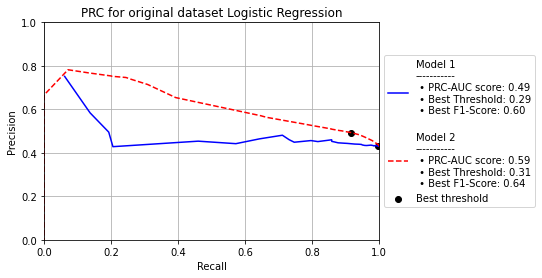

Best Threshold=0.307336, F1-Score=0.641 for model 1
Best Threshold=0.308518, F1-Score=0.641 for model 2


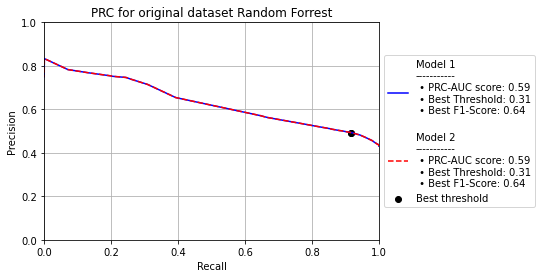

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


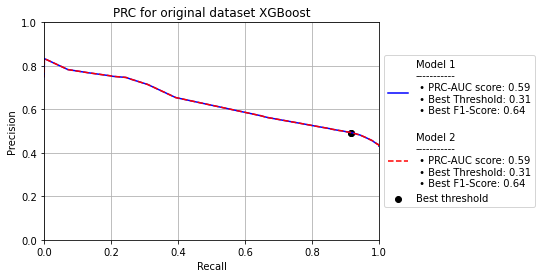


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

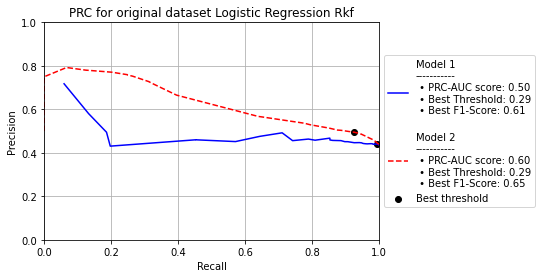

Best Threshold=0.293561, F1-Score=0.645 for model 1
Best Threshold=0.294334, F1-Score=0.645 for model 2


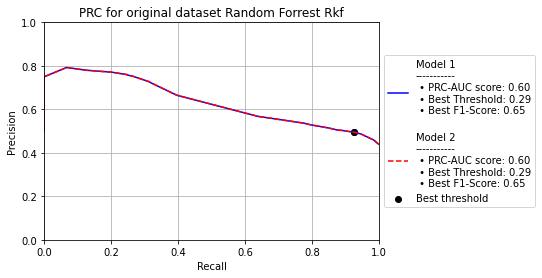

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


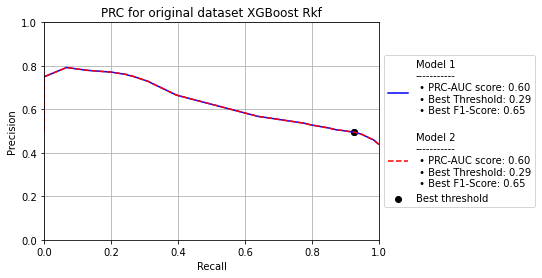

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


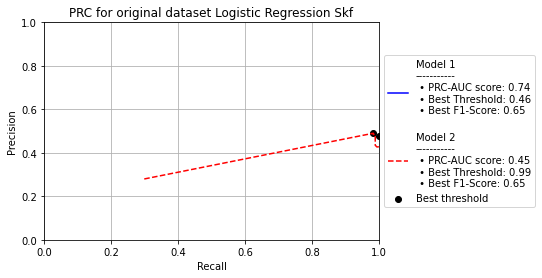

Best Threshold=1.000000, F1-Score=0.649 for model 1
Best Threshold=1.000000, F1-Score=0.650 for model 2


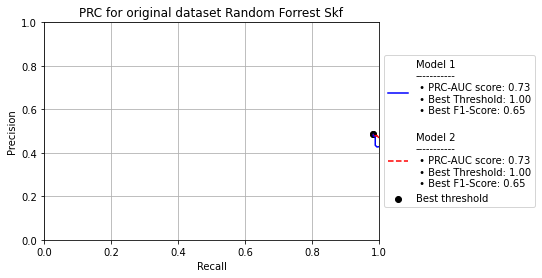

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


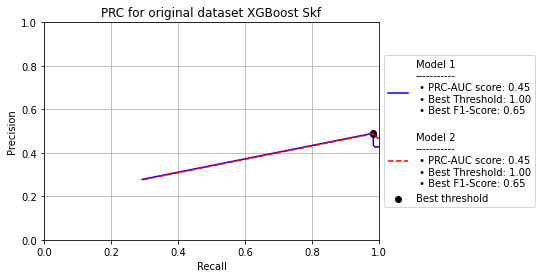

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


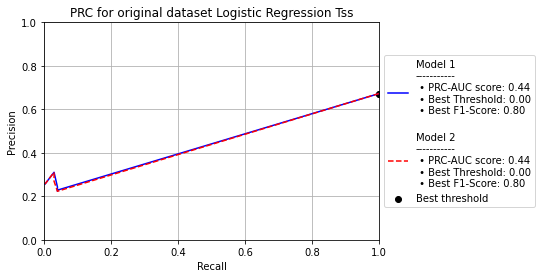

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


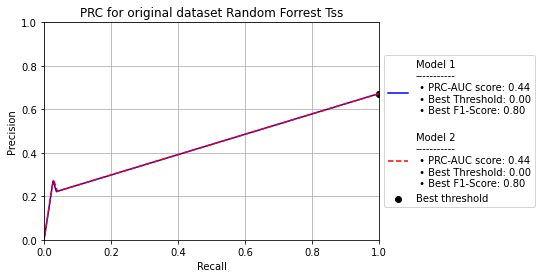

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


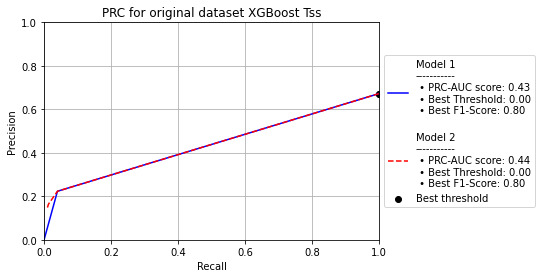

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    2    3 ... 3796 3798 3799] | TEST: [   1   13   17   31   55   58   80   96  105  125  131  149  156  157
  168  172  182  197  228  236  247  285  317  323  324  351  378  385
  397  401  425  437  447  458  466  469  473  476  481  487  491  500
  534  535  542  543  545  546  547  561  573  578  585  592  593  608
  611  624  659  682  695  696  697  703  707  712  750  752  756  761
  764  774  788  789  818  825  827  842  852  865  867  877  878  881
  893  913  934  950  960  966  982  987  996  997 1005 1013 1018 1024
 1025 1038 1041 1042 1047 1050 1078 1080 1122 1128 1129 1163 1166 1171
 1172 1180 1193 1199 1237 1239 1246 1247 1259 1261 1264 1277 1281 1290
 1295 1302 1303 1322 1369 1376 1395 1408 1421 1425 1428 1441 1451 1457
 1467 1470 1488 1502 1507 1510 1523 1529 1533 1536 1542 1544 1554 1556
 1568 1582 1593 1615 1634 1650 1653 1655 1656 1664 1665 1667 1671 1674
 1677 1680 1685 1693 1697 1720 1732 1734 1739 1753 1758 1763 1765 1768
 1782 1790 1817 1823 1829 

Accuracy: 0.542
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [3037 3039 3041 3042 3043 3044 3045 3047 3048 3049 3050 3051 3052 3053
 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067
 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081
 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095
 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109
 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123
 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137
 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151
 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165
 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179
 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193
 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207
 3208 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221
 3222 3223

Mean Average-Precision Recall Score: 0.5001869974325414
TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026
 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040
 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054
 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068
 2069 2070 2071 2072 2073 2074 2075 2076 

TRAIN: [   0    1    2 ... 3796 3797 3798] | TEST: [  28   44   48   65   67   73   81   86   87  118  122  125  148  151
  162  170  172  177  179  181  188  207  209  223  226  229  258  270
  276  280  309  313  317  324  325  337  348  350  354  386  403  417
  437  441  446  470  472  478  491  492  501  502  508  516  522  524
  564  580  585  593  595  636  639  656  666  681  687  688  709  716
  727  749  771  813  815  819  821  831  834  838  845  862  868  887
  892  907  922  931  947  954  959  969  987  989  991 1005 1015 1017
 1027 1036 1061 1074 1075 1089 1093 1101 1114 1115 1125 1130 1131 1134
 1139 1143 1158 1164 1173 1185 1189 1191 1202 1211 1219 1226 1264 1278
 1280 1292 1312 1323 1371 1374 1381 1390 1397 1399 1421 1425 1439 1443
 1444 1449 1465 1502 1506 1542 1548 1552 1570 1574 1580 1582 1602 1604
 1607 1614 1643 1649 1720 1721 1724 1728 1767 1787 1789 1808 1828 1832
 1848 1850 1860 1872 1875 1882 1893 1917 1928 1929 1932 1934 1969 1978
 1986 1993 2004 2022 2024 

TRAIN: [ 350  352  357 ... 3797 3798 3799] | TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233


TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 


Scores for model 1
------------------
Roc_Auc Score: 0.5414146752151304
Average Precision-Recall Score: 0.5327342136030004
PRC-AUC for model 1: 0.5449337462265496
Accuracy: 0.540
Precision score for model 1:  0.5327125408150926
Recall score for model 1:  0.638714354760754
F1 score for model 1:  0.5809174231267995
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.44      0.49     20741
           1       0.53      0.64      0.58     20690

    accuracy                           0.54     41431
   macro avg       0.54      0.54      0.54     41431
weighted avg       0.54      0.54      0.54     41431


Scores for model 2
------------------
Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6869772426005312
Precision score for model 2:  0.6349851717210371
Recall score for model 2:  0.6416143064282261
F1 score for model 2:  0.6382825271660736
Classification Report:

        

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     4     14     15 ... 138092 138093 138097]

Model Score: 0.5469949312092687
Average Precision-Recall Score: 0.5322439154792465
PRC-AUC Score: 0.7534972834814925
Precision:  0.5461313155967781
Recall:  0.6381916714204221
F1:  0.5885834538997763
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.45      0.50      6798
           1       0.55      0.64      0.59      7012

    accuracy                           0.55     13810
   macro avg       0.55      0.55      0.54     13810
weighted avg       0.55      0.55      0.54     13810

Accuracy: 0.547
Mean Average-Precision Recall Score: 0.5473592505177518
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734492193238303
Precision:  0.6517640337094701
Recall

Mean Average-Precision Recall Score: 0.6762676280709183
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734479667113734
Precision:  0.6517640337094701
Recall:  0.6478773250035497
F1:  0.6498148675591
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6767
           1       0.65      0.65      0.65      7043

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.644
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall:  0

Accuracy: 0.638

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6897138902737883
Accuracy: 0.638
Precision score for model 1:  0.6363418606879372
Recall score for model 1:  0.642311411992263
F1 score for model 1:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64      0.64     41431
weighted avg       0.64      0.64      0.64     41431


Scores for model 2
------------------
Roc_Auc Score: 0.7020334971156107
Average Precision-Recall Score: 0.6756572483351841
PRC-AUC for model 2: 0.6897138689123042
Precision score for model 2:  0.6363418606879372
Recall score for model 2:  0.642311411992263
F1 score for model 2:  0.6393127015449777
Classification Re

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.7492394082194176
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6905
           1       0.75      0.75      0.75      6905

    accuracy                           0.75     13810
   macro avg       0.75      0.75      0.75     13810
weighted avg       0.75      0.75      0.75     13810

Accuracy: 0.748
Mean Average-Precision Recall Score: 0.46258858957661186
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.4422662350623852
Precision:  0.5631011704716653
Re

Mean Average-Precision Recall Score: 0.44730726099028306
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.4420032707207916
Precision:  0.5631011704716653
Recall:  0.7036929761042723
F1:  0.625595468005665
Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6905
           1       0.56      0.70      0.63      6905

    accuracy                           0.58     13810
   macro avg       0.58      0.58      0.57     13810
weighted avg       0.58      0.58      0.57     13810

Accuracy: 0.579
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.4420032707207916
Precision:  0.5631011704716653
Rec

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.18664772 0.25277159 0.11542829 0.11381388 0.33133853]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

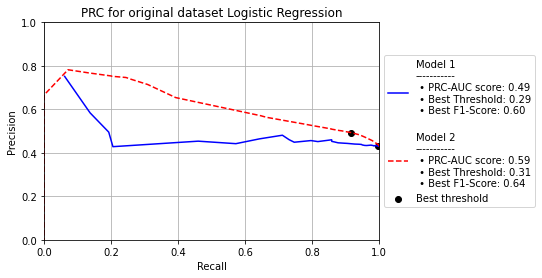

Best Threshold=0.307981, F1-Score=0.641 for model 1
Best Threshold=0.307604, F1-Score=0.641 for model 2


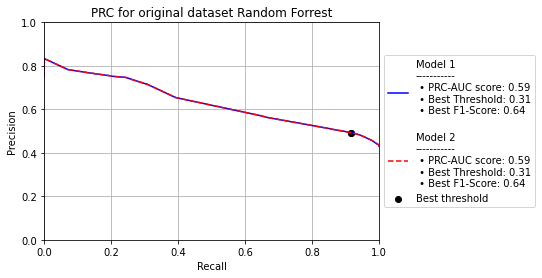

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


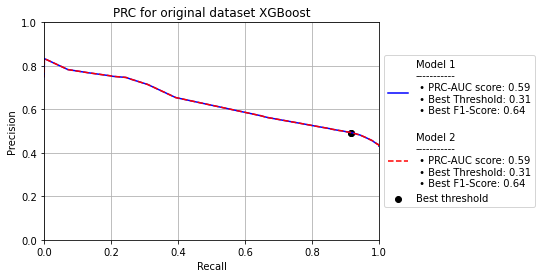


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

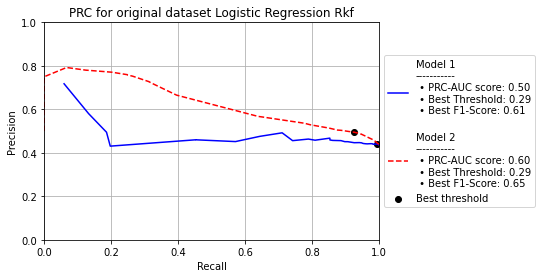

Best Threshold=0.293264, F1-Score=0.645 for model 1
Best Threshold=0.292587, F1-Score=0.645 for model 2


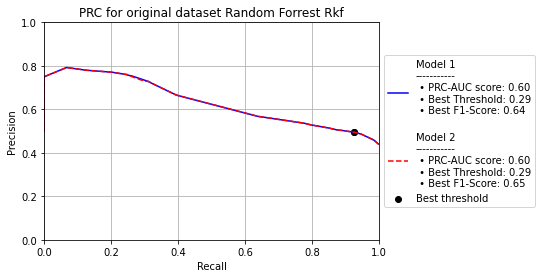

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


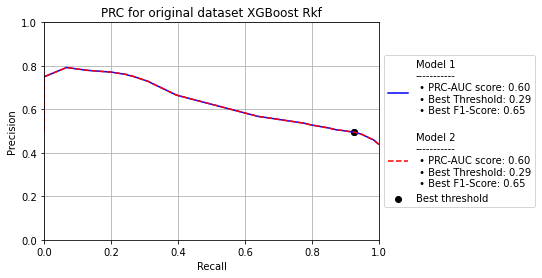

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


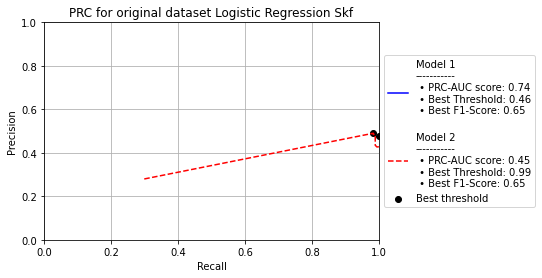

Best Threshold=1.000000, F1-Score=0.650 for model 1
Best Threshold=1.000000, F1-Score=0.649 for model 2


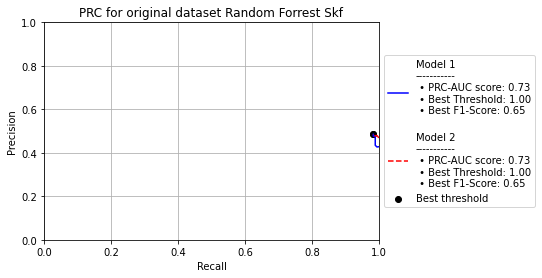

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


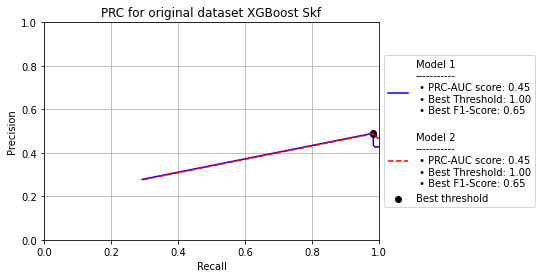

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


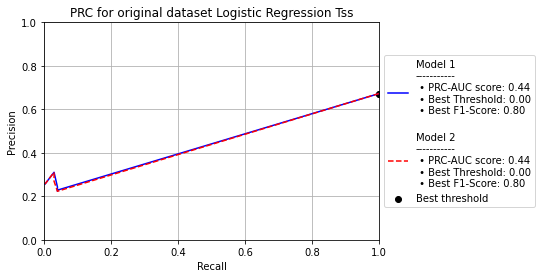

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


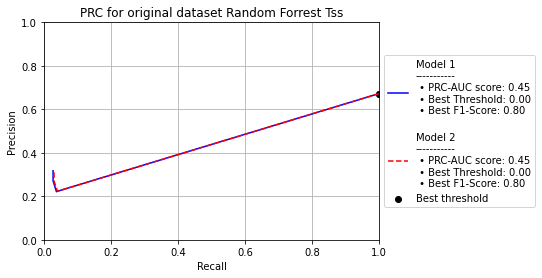

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


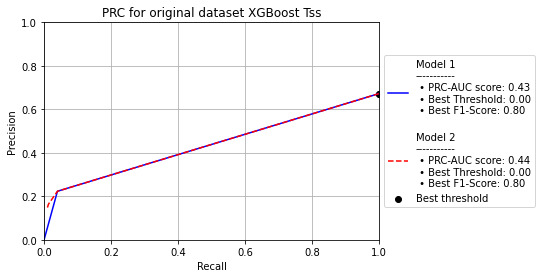

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  22   23   25   34   38   41   56   70   82   90   91  109  115  127
  133  149  157  161  164  167  183  192  201  202  227  238  252  261
  289  292  301  307  310  322  339  356  358  375  376  384  393  412
  425  430  433  442  447  463  466  474  476  480  486  488  499  513
  517  536  553  572  581  586  588  594  599  603  605  626  633  637
  645  663  665  669  702  705  715  722  729  738  742  750  783  789
  798  799  801  820  826  837  848  864  872  877  889  893  896  909
  910  946  955  965  966  975  978  993  995 1020 1029 1066 1067 1069
 1071 1079 1080 1088 1141 1151 1161 1167 1171 1186 1188 1190 1210 1223
 1232 1236 1276 1309 1310 1315 1318 1339 1341 1347 1349 1363 1382 1407
 1418 1419 1427 1441 1445 1446 1462 1476 1478 1484 1508 1520 1532 1535
 1543 1558 1572 1583 1584 1585 1587 1589 1596 1606 1627 1629 1640 1644
 1651 1659 1664 1666 1684 1685 1687 1740 1755 1763 1772 1813 1815 1822
 1834 1838 1866 1869 1877 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [3037 3040 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053
 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067
 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081
 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095
 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109
 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123
 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137
 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151
 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165
 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179
 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193
 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207
 3208 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221
 3222 3223 3224 3225 3226 

Precision:  0.5098814229249012
Recall:  0.38972809667673713
F1:  0.44178082191780826
Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.59      0.52       302
           1       0.51      0.39      0.44       331

    accuracy                           0.48       633
   macro avg       0.49      0.49      0.48       633
weighted avg       0.49      0.48      0.48       633

Accuracy: 0.485
Mean Average-Precision Recall Score: 0.49079420280134833
TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 262

TRAIN: [   0    1    3 ... 3797 3798 3799] | TEST: [   2    6    8   13   20   23   37   39   53   71   83   86   91  105
  115  121  142  145  158  159  169  207  213  222  244  265  271  273
  277  287  292  294  306  308  311  316  339  348  352  377  382  394
  398  409  425  427  431  444  447  453  458  476  483  514  519  526
  548  552  556  571  579  583  585  588  590  591  634  672  674  686
  694  696  704  715  737  749  754  771  778  780  792  800  806  808
  824  849  861  873  885  886  888  892  902  906  908  913  917  923
  947  963  970  973  974  983  988  993 1007 1043 1050 1054 1083 1085
 1087 1096 1098 1109 1137 1165 1170 1189 1193 1199 1230 1245 1247 1259
 1265 1266 1274 1285 1290 1325 1328 1337 1343 1349 1355 1375 1380 1382
 1389 1393 1410 1413 1418 1435 1448 1453 1463 1486 1518 1530 1544 1547
 1559 1560 1562 1567 1576 1590 1591 1594 1596 1607 1640 1666 1689 1690
 1709 1710 1711 1713 1714 1716 1723 1737 1746 1748 1756 1763 1771 1776
 1809 1835 1840 1868 1883 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [3037 3040 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053
 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067
 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081
 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095
 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109
 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123
 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137
 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151
 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165
 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179
 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193
 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207
 3208 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221
 3222 3223 3224 3225 3226 

TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 


Scores for model 1
------------------
Roc_Auc Score: 0.5414146752151304
Average Precision-Recall Score: 0.5327342136030004
PRC-AUC for model 1: 0.5449337462265496
Accuracy: 0.540
Precision score for model 1:  0.5327125408150926
Recall score for model 1:  0.638714354760754
F1 score for model 1:  0.5809174231267995
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.44      0.49     20741
           1       0.53      0.64      0.58     20690

    accuracy                           0.54     41431
   macro avg       0.54      0.54      0.54     41431
weighted avg       0.54      0.54      0.54     41431


Scores for model 2
------------------
Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6869772426005312
Precision score for model 2:  0.6349851717210371
Recall score for model 2:  0.6416143064282261
F1 score for model 2:  0.6382825271660736
Classification Report:

        

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     4     14     15 ... 138092 138093 138097]

Model Score: 0.5469949312092687
Average Precision-Recall Score: 0.5322439154792465
PRC-AUC Score: 0.7534972834814925
Precision:  0.5461313155967781
Recall:  0.6381916714204221
F1:  0.5885834538997763
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.45      0.50      6798
           1       0.55      0.64      0.59      7012

    accuracy                           0.55     13810
   macro avg       0.55      0.55      0.54     13810
weighted avg       0.55      0.55      0.54     13810

Accuracy: 0.547
Mean Average-Precision Recall Score: 0.5473592505177518
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734481953187876
Precision:  0.6517640337094701
Recall

Mean Average-Precision Recall Score: 0.6762676280709183
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734492193238303
Precision:  0.6517640337094701
Recall:  0.6478773250035497
F1:  0.6498148675591
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6767
           1       0.65      0.65      0.65      7043

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.644
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall:  0

Precision score for model 2:  0.6363418606879372
Recall score for model 2:  0.642311411992263
F1 score for model 2:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64      0.64     41431
weighted avg       0.64      0.64      0.64     41431

Accuracy: 0.638

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6897138902737883
Accuracy: 0.638
Precision score for model 1:  0.6363418606879372
Recall score for model 1:  0.642311411992263
F1 score for model 1:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.5014197845008075
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6905
           1       0.75      0.75      0.75      6905

    accuracy                           0.75     13810
   macro avg       0.75      0.75      0.75     13810
weighted avg       0.75      0.75      0.75     13810

Accuracy: 0.748
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.7492394082194176
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classif

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.7313797604245118
Precision:  0.5631011704716653
Recall:  0.7036929761042723
F1:  0.625595468005665
Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6905
           1       0.56      0.70      0.63      6905

    accuracy                           0.58     13810
   macro avg       0.58      0.58      0.57     13810
weighted avg       0.58      0.58      0.57     13810

Accuracy: 0.579
Mean Average-Precision Recall Score: 0.44730726099028306
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.4410025850900583
Precision:  0.5631011704716653
Rec

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.15640171 0.27823179 0.11545655 0.12357937 0.32633058]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

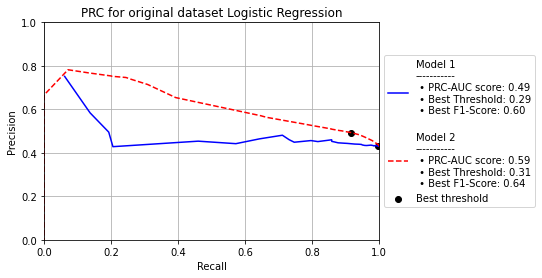

Best Threshold=0.308459, F1-Score=0.641 for model 1
Best Threshold=0.309518, F1-Score=0.641 for model 2


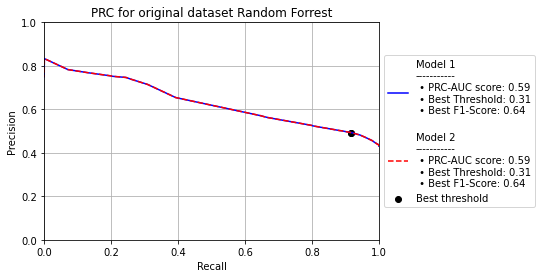

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


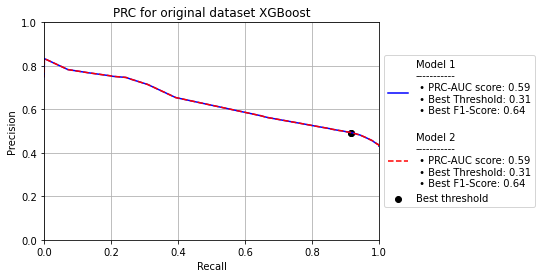


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

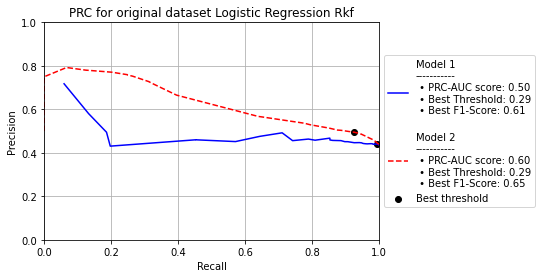

Best Threshold=0.292441, F1-Score=0.645 for model 1
Best Threshold=0.293244, F1-Score=0.645 for model 2


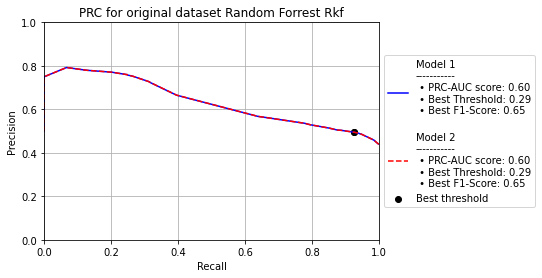

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


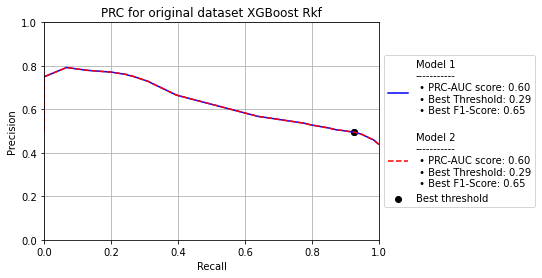

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


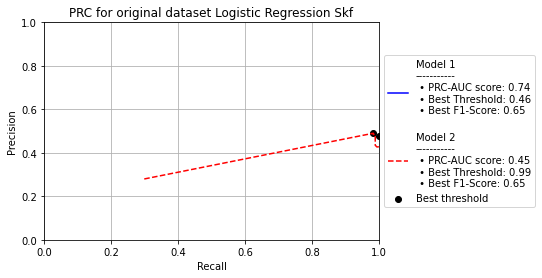

Best Threshold=1.000000, F1-Score=0.650 for model 1
Best Threshold=1.000000, F1-Score=0.649 for model 2


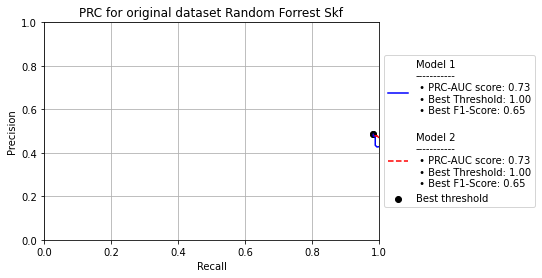

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


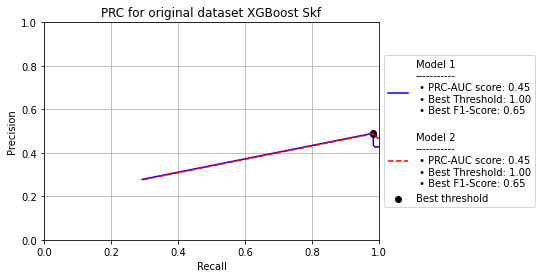

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


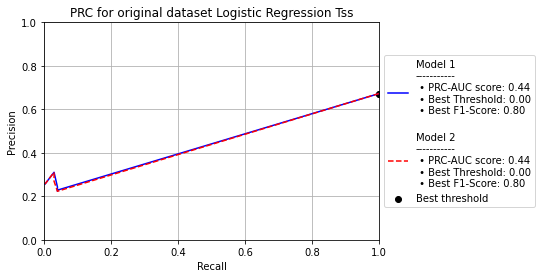

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


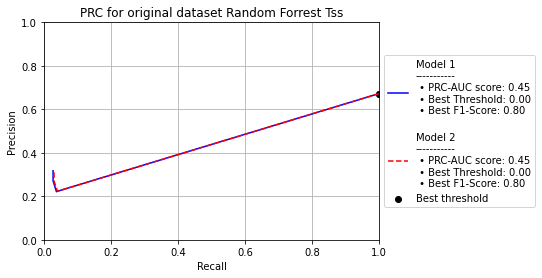

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


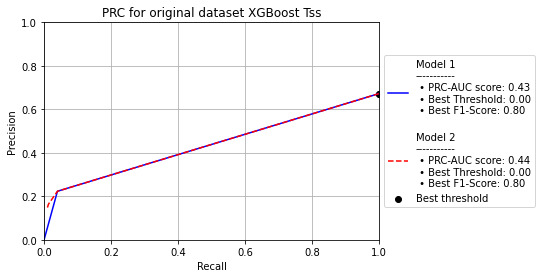

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    2 ... 3796 3797 3799] | TEST: [  41   57   72   78  100  104  123  163  168  191  199  212  231  237
  243  252  261  272  276  328  340  347  350  353  365  367  381  407
  413  421  424  435  440  445  456  462  464  480  498  508  509  518
  521  522  542  553  560  589  593  597  613  617  620  626  630  632
  647  649  651  660  662  677  685  707  741  748  767  772  783  789
  801  819  834  844  845  855  887  898  900  911  930  942  944  945
  962  979  981  982  994  998 1005 1010 1036 1048 1090 1093 1100 1102
 1103 1124 1127 1133 1143 1181 1196 1206 1232 1236 1253 1271 1283 1288
 1289 1298 1315 1322 1330 1336 1339 1340 1345 1366 1376 1397 1398 1419
 1421 1423 1436 1444 1455 1459 1467 1468 1476 1480 1488 1491 1494 1499
 1501 1502 1509 1517 1532 1533 1537 1538 1545 1551 1552 1563 1564 1577
 1578 1584 1601 1606 1609 1613 1623 1632 1641 1653 1656 1657 1670 1672
 1674 1681 1717 1720 1727 1729 1732 1736 1739 1754 1779 1789 1815 1820
 1825 1842 1880 1882 1886 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [ 754  755  756  760  761  765  766  767  768  769  770  771  772  773
  774  775  776  777  778  779  780  781  782  783  784  785  786  787
  788  789  790  791  792  793  794  795  796  797  798  799  800  801
  802  803  804  805  806  807  808  809  810  811  812  813  814  815
  816  817  818  819  820  821  822  823  824  825  826  827  828  829
  830  831  832  833  834  835  836  837  838  839  840  841  842  843
  844  845  846  847  848  849  850  851  852  853  854  855  856  857
  858  859  860  861  862  863  864  865  866  867  868  869  870  871
  872  873  874  875  876  877  878  879  880  881  882  883  884  885
  886  887  888  889  890  891  892  893  894  895  896  897  898  899
  900  901  902  903  904  905  906  907  908  909  910  911  912  913
  914  915  916  917  918  919  920  921  922  923  924  925  926  927
  928  929  930  931  932  933  934  935  936  937  938  939  940  941
  942  943  944  945  946 

 2531 2532 2533]

Model Score: 0.5197472353870458

Average Precision-Recall Score: 0.5292187526436023
PRC-AUC Score: 0.7582938388625593
Precision:  0.5481171548117155
Recall:  0.40061162079510704
F1:  0.4628975265017668
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.65      0.57       306
           1       0.55      0.40      0.46       327

    accuracy                           0.52       633
   macro avg       0.53      0.52      0.51       633
weighted avg       0.53      0.52      0.51       633

Accuracy: 0.520
Mean Average-Precision Recall Score: 0.5097053728683095
TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1

TRAIN: [   0    1    2 ... 3796 3797 3799] | TEST: [  41   57   72   78  100  104  123  163  168  191  199  212  231  237
  243  252  261  272  276  328  340  347  350  353  365  367  381  407
  413  421  424  435  440  445  456  462  464  480  498  508  509  518
  521  522  542  553  560  589  593  597  613  617  620  626  630  632
  647  649  651  660  662  677  685  707  741  748  767  772  783  789
  801  819  834  844  845  855  887  898  900  911  930  942  944  945
  962  979  981  982  994  998 1005 1010 1036 1048 1090 1093 1100 1102
 1103 1124 1127 1133 1143 1181 1196 1206 1232 1236 1253 1271 1283 1288
 1289 1298 1315 1322 1330 1336 1339 1340 1345 1366 1376 1397 1398 1419
 1421 1423 1436 1444 1455 1459 1467 1468 1476 1480 1488 1491 1494 1499
 1501 1502 1509 1517 1532 1533 1537 1538 1545 1551 1552 1563 1564 1577
 1578 1584 1601 1606 1609 1613 1623 1632 1641 1653 1656 1657 1670 1672
 1674 1681 1717 1720 1727 1729 1732 1736 1739 1754 1779 1789 1815 1820
 1825 1842 1880 1882 1886 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1878 1879 1883 1884 1885 1886 1887 1888 1891 1892 1893 1895 1898 1900
 1901 1909 1911 1913 1915 1916 1920 1921 1922 1923 1924 1925 1926 1927
 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025
 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039
 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053
 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067
 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081
 2082 2083 2084 2085 2086 

TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026
 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040
 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054
 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068
 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082
 2083 2084 2085 2086 2087 

TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026
 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040
 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054
 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068
 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082
 2083 2084 2085 2086 2087 

Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6457632598119071
Precision score for model 2:  0.55513906375186
Recall score for model 2:  0.9376993716771387
F1 score for model 2:  0.6974010568316619
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.25      0.38     20741
           1       0.56      0.94      0.70     20690

    accuracy                           0.59     41431
   macro avg       0.68      0.59      0.54     41431
weighted avg       0.68      0.59      0.54     41431

Accuracy: 0.594

Scores for model 1
------------------
Roc_Auc Score: 0.6978773652231233
Average Precision-Recall Score: 0.6725898495426976
PRC-AUC for model 1: 0.6497892775365414
Accuracy: 0.594
Precision score for model 1:  0.5551422194242546
Recall score for model 1:  0.9376510391493476
F1 score for model 1:  0.6973901790207779
Classification Report:

              precision    recal

TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.9748626565351836
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.15      1.00      0.26      3390
           1       0.00      0.00      0.00     19627

    accuracy                           0.15     23017
   macro avg       0.07      0.50      0.13     23017
weighted avg       0.02      0.15      0.04     23017

Accuracy: 0.147
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.932561245495237
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0     

TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.3662944779945258

Average Precision-Recall Score: 0.8106145860687655
PRC-AUC Score: 0.9234657733617746
Precision:  0.7449227480322612
Recall:  0.3905843990421358
F1:  0.51246741092319
Classification Report:

              precision    recall  f1-score   support

           0       0.06      0.23      0.09      3390
           1       0.74      0.39      0.51     19627

    accuracy                           0.37     23017
   macro avg       0.40      0.31      0.30     23017
weighted avg       0.64      0.37      0.45     23017

Accuracy: 0.366
Mean Average-Precision Recall Score: 0.5565300744661613
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.4063952730590433

Average Precision-Recall Score: 0.8974718487629366
PRC-AUC Score: 0.9657395819569761
Precision:  1.0
Recall:  0.303867121


Accuracy: 0.599

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6503288018053685
Accuracy: 0.599
Precision score for model 1:  0.5583043939959246
Recall score for model 1:  0.9406673114119922
F1 score for model 1:  0.7007186211119716
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.26      0.39     20751
           1       0.56      0.94      0.70     20680

    accuracy                           0.60     41431
   macro avg       0.69      0.60      0.55     41431
weighted avg       0.69      0.60      0.55     41431


Scores for model 2
------------------
Roc_Auc Score: 0.7020334971156107
Average Precision-Recall Score: 0.6756572483351841
PRC-AUC for model 2: 0.6503288018053685
Precision score for model 2:  0.5583043939959246
Recall score for model 2:  0.9406673114119922
F1 score for model 2:  0.7007186211119716
Classification

TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.24395012382152323
F1:  0.392218496786812
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
TRAIN: [     0      2      3 ... 138099 138100 138101] | TEST: [     1      7     12 ... 138073 138090 138098]

Model Score: 0.6420709630702389
Average Precision-Recall Score: 0.597485579456884
PRC-AUC Score: 0.6540909129062146
Precision:  0.6466229695069821
Recall:  0.6481931152692473
F1:  0.647407090377345
Classification Report:

              precision    recall  f

TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.24395012382152323
F1:  0.392218496786812
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
                                                 Test  Model1 score  \
0                        Original_Logistic_Regression      0.570255   
1                             Original_Random_Forrest      0.650068   
2                             Original_XGB_Classifier      0.650068   
3         Original_Logistic_Regression_Best_Threshold      0.570255   
4              

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.18057178 0.25428517 0.11689212 0.11148615 0.33676479]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

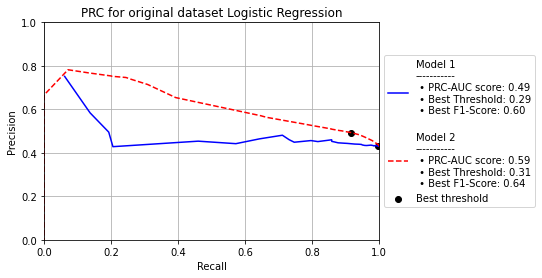

Best Threshold=0.311199, F1-Score=0.641 for model 1
Best Threshold=0.306736, F1-Score=0.641 for model 2


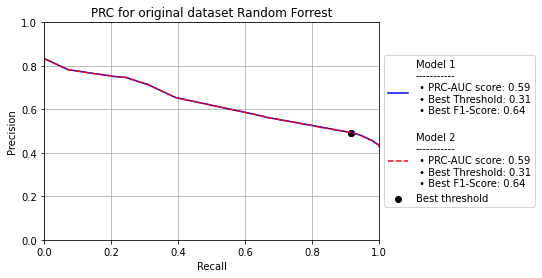

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


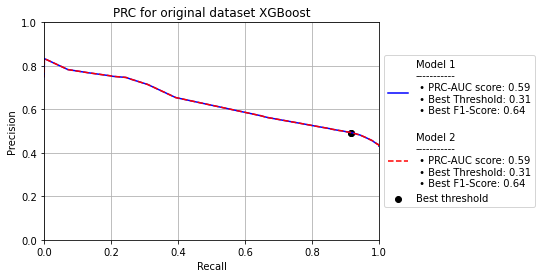


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

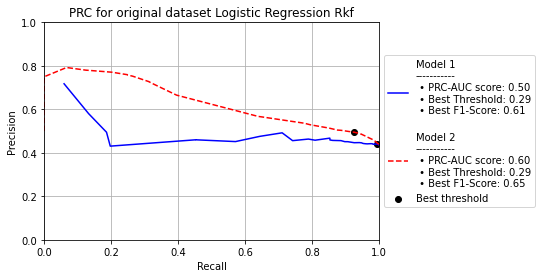

Best Threshold=0.293512, F1-Score=0.645 for model 1
Best Threshold=0.292552, F1-Score=0.645 for model 2


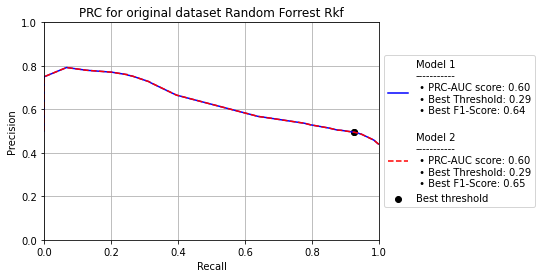

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


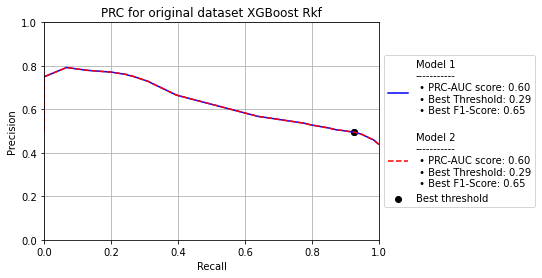

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


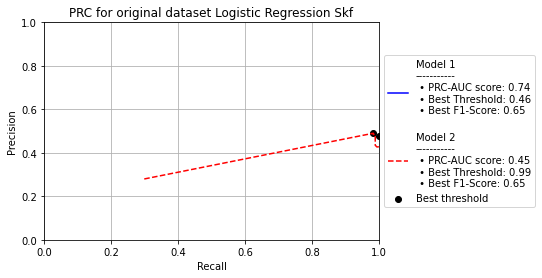

Best Threshold=1.000000, F1-Score=0.649 for model 1
Best Threshold=1.000000, F1-Score=0.650 for model 2


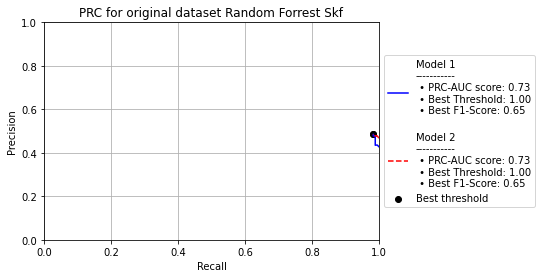

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


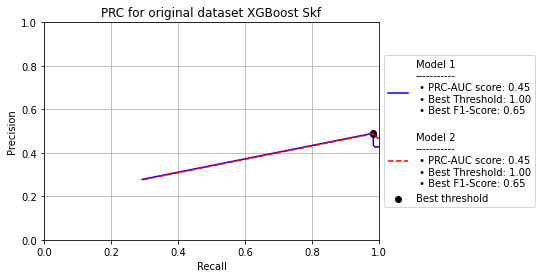

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


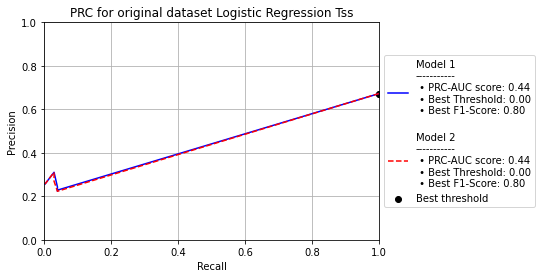

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


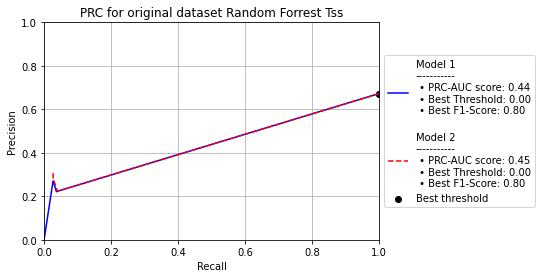

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


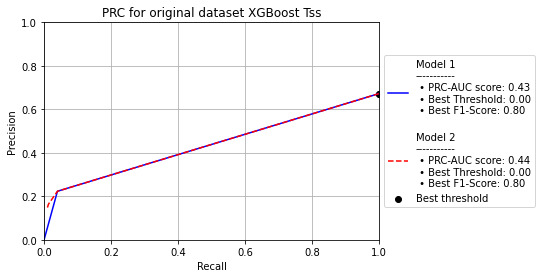

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    3 ... 3797 3798 3799] | TEST: [   2    6    8   13   20   23   37   39   53   71   83   86   91  105
  115  121  142  145  158  159  169  207  213  222  244  265  271  273
  277  287  292  294  306  308  311  316  339  348  352  377  382  394
  398  409  425  427  431  444  447  453  458  476  483  514  519  526
  548  552  556  571  579  583  585  588  590  591  634  672  674  686
  694  696  704  715  737  749  754  771  778  780  792  800  806  808
  824  849  861  873  885  886  888  892  902  906  908  913  917  923
  947  963  970  973  974  983  988  993 1007 1043 1050 1054 1083 1085
 1087 1096 1098 1109 1137 1165 1170 1189 1193 1199 1230 1245 1247 1259
 1265 1266 1274 1285 1290 1325 1328 1337 1343 1349 1355 1375 1380 1382
 1389 1393 1410 1413 1418 1435 1448 1453 1463 1486 1518 1530 1544 1547
 1559 1560 1562 1567 1576 1590 1591 1594 1596 1607 1640 1666 1689 1690
 1709 1710 1711 1713 1714 1716 1723 1737 1746 1748 1756 1763 1771 1776
 1809 1835 1840 1868 1883 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [2659 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729
 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743
 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757
 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771
 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785
 2786 2787 2788 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799
 2800 2801 2802 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813
 2814 2815 2816 2817 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827
 2828 2829 2830 2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841
 2842 2843 2844 2845 2846 

 2531 2532 2533]

Model Score: 0.4755134281200632

Average Precision-Recall Score: 0.5132962288567597
PRC-AUC Score: 0.7614533965244865
Precision:  0.4980544747081712
Recall:  0.3867069486404834
F1:  0.435374149659864
Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.57      0.51       302
           1       0.50      0.39      0.44       331

    accuracy                           0.48       633
   macro avg       0.48      0.48      0.47       633
weighted avg       0.48      0.48      0.47       633

Accuracy: 0.476
Mean Average-Precision Recall Score: 0.5041748212734889
TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 196

TRAIN: [   0    1    3 ... 3797 3798 3799] | TEST: [   2    6    8   13   20   23   37   39   53   71   83   86   91  105
  115  121  142  145  158  159  169  207  213  222  244  265  271  273
  277  287  292  294  306  308  311  316  339  348  352  377  382  394
  398  409  425  427  431  444  447  453  458  476  483  514  519  526
  548  552  556  571  579  583  585  588  590  591  634  672  674  686
  694  696  704  715  737  749  754  771  778  780  792  800  806  808
  824  849  861  873  885  886  888  892  902  906  908  913  917  923
  947  963  970  973  974  983  988  993 1007 1043 1050 1054 1083 1085
 1087 1096 1098 1109 1137 1165 1170 1189 1193 1199 1230 1245 1247 1259
 1265 1266 1274 1285 1290 1325 1328 1337 1343 1349 1355 1375 1380 1382
 1389 1393 1410 1413 1418 1435 1448 1453 1463 1486 1518 1530 1544 1547
 1559 1560 1562 1567 1576 1590 1591 1594 1596 1607 1640 1666 1689 1690
 1709 1710 1711 1713 1714 1716 1723 1737 1746 1748 1756 1763 1771 1776
 1809 1835 1840 1868 1883 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [2659 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729
 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743
 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757
 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771
 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785
 2786 2787 2788 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799
 2800 2801 2802 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813
 2814 2815 2816 2817 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827
 2828 2829 2830 2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841
 2842 2843 2844 2845 2846 

TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026
 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040
 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054
 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068
 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082
 2083 2084 2085 2086 2087 

TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026
 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040
 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054
 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068
 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082
 2083 2084 2085 2086 2087 

------------------
Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6457632598119071
Precision score for model 2:  0.55513906375186
Recall score for model 2:  0.9376993716771387
F1 score for model 2:  0.6974010568316619
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.25      0.38     20741
           1       0.56      0.94      0.70     20690

    accuracy                           0.59     41431
   macro avg       0.68      0.59      0.54     41431
weighted avg       0.68      0.59      0.54     41431

Accuracy: 0.594

Scores for model 1
------------------
Roc_Auc Score: 0.6980061439938346
Average Precision-Recall Score: 0.6725866784419421
PRC-AUC for model 1: 0.6481508086729203
Accuracy: 0.594
Precision score for model 1:  0.5551422194242546
Recall score for model 1:  0.9376510391493476
F1 score for model 1:  0.6973901790207779
Classification Report:

             

TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.9748626565351836
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.15      1.00      0.26      3390
           1       0.00      0.00      0.00     19627

    accuracy                           0.15     23017
   macro avg       0.07      0.50      0.13     23017
weighted avg       0.02      0.15      0.04     23017

Accuracy: 0.147
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.932561245495237
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0     

TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.3662944779945258

Average Precision-Recall Score: 0.8106145860687655
PRC-AUC Score: 0.9234657733617746
Precision:  0.7449227480322612
Recall:  0.3905843990421358
F1:  0.51246741092319
Classification Report:

              precision    recall  f1-score   support

           0       0.06      0.23      0.09      3390
           1       0.74      0.39      0.51     19627

    accuracy                           0.37     23017
   macro avg       0.40      0.31      0.30     23017
weighted avg       0.64      0.37      0.45     23017

Accuracy: 0.366
Mean Average-Precision Recall Score: 0.5565300744661613
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.4063952730590433

Average Precision-Recall Score: 0.8974718487629366
PRC-AUC Score: 0.9665533513331441
Precision:  1.0
Recall:  0.303867121

Accuracy: 0.599

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6503288018053685
Accuracy: 0.599
Precision score for model 1:  0.5583043939959246
Recall score for model 1:  0.9406673114119922
F1 score for model 1:  0.7007186211119716
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.26      0.39     20751
           1       0.56      0.94      0.70     20680

    accuracy                           0.60     41431
   macro avg       0.69      0.60      0.55     41431
weighted avg       0.69      0.60      0.55     41431


Scores for model 2
------------------
Roc_Auc Score: 0.7020334971156107
Average Precision-Recall Score: 0.6756572483351841
PRC-AUC for model 2: 0.6503288018053685
Precision score for model 2:  0.5583043939959246
Recall score for model 2:  0.9406673114119922
F1 score for model 2:  0.7007186211119716
Classification 

TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.24395012382152323
F1:  0.392218496786812
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
TRAIN: [     0      2      3 ... 138099 138100 138101] | TEST: [     1      7     12 ... 138073 138090 138098]

Model Score: 0.6420709630702389
Average Precision-Recall Score: 0.597485579456884
PRC-AUC Score: 0.6540909129062146
Precision:  0.6466229695069821
Recall:  0.6481931152692473
F1:  0.647407090377345
Classification Report:

              precision    recall  f

TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.24395012382152323
F1:  0.392218496786812
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
                                                 Test  Model1 score  \
0                        Original_Logistic_Regression      0.570255   
1                             Original_Random_Forrest      0.650068   
2                             Original_XGB_Classifier      0.650068   
3         Original_Logistic_Regression_Best_Threshold      0.570255   
4              

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.18856297 0.23420713 0.11798119 0.11631498 0.34293373]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

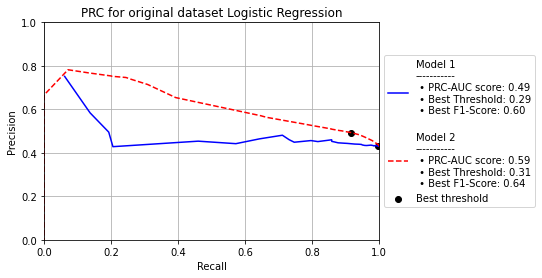

Best Threshold=0.310258, F1-Score=0.641 for model 1
Best Threshold=0.308365, F1-Score=0.641 for model 2


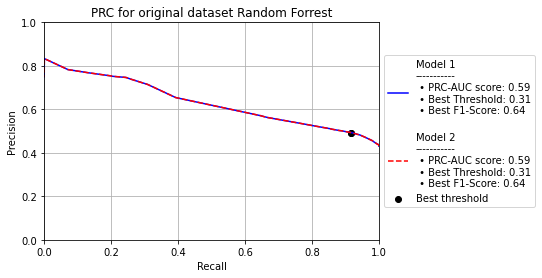

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


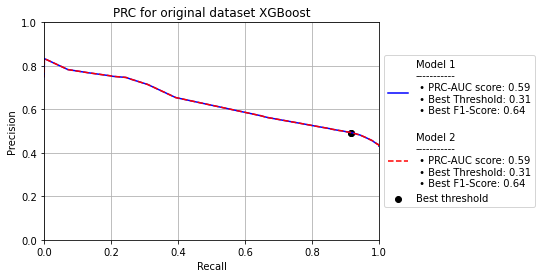


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

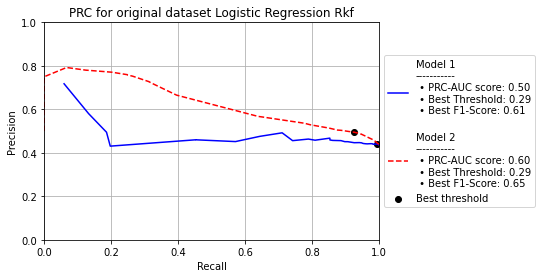

Best Threshold=0.293944, F1-Score=0.645 for model 1
Best Threshold=0.295681, F1-Score=0.645 for model 2


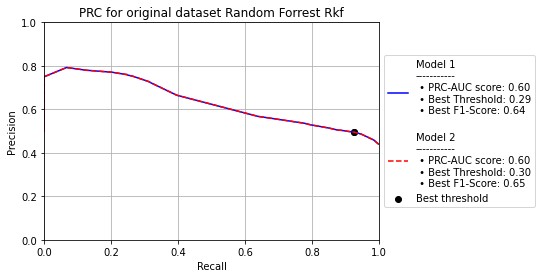

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


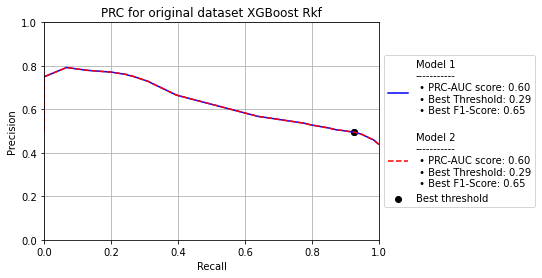

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


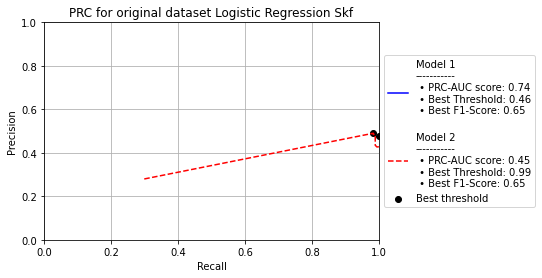

Best Threshold=1.000000, F1-Score=0.649 for model 1
Best Threshold=0.449725, F1-Score=0.651 for model 2


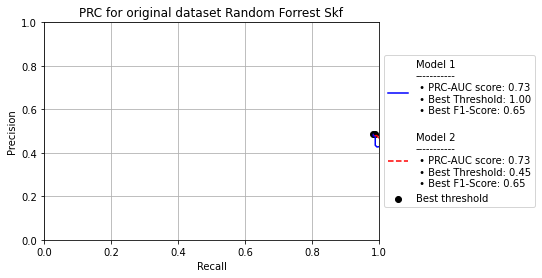

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


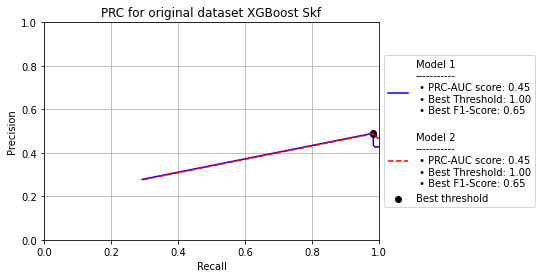

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


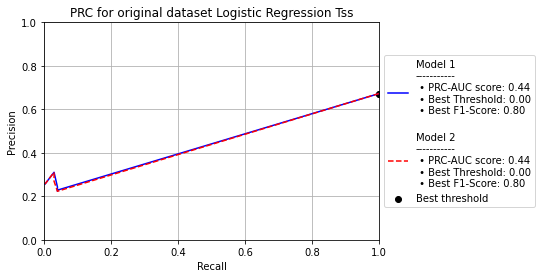

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


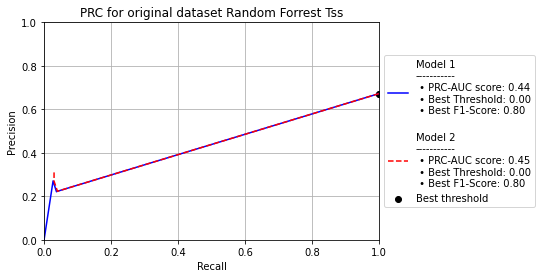

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


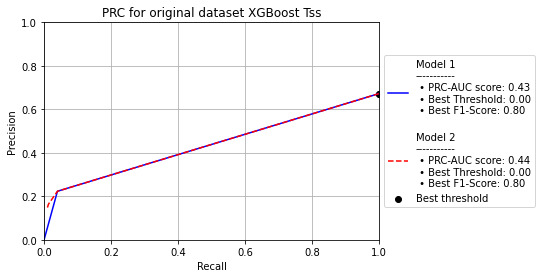

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    2    3 ... 3797 3798 3799] | TEST: [   1    6   11   16   24   27   31   43   50   51   54   69   79   80
   96  112  119  131  140  160  169  194  196  206  231  240  241  246
  259  281  284  287  293  299  308  311  315  321  333  335  336  373
  374  382  390  419  422  426  427  448  450  451  458  461  469  471
  475  489  493  497  500  503  512  532  563  565  569  570  606  607
  619  624  642  646  649  662  671  684  685  692  698  700  713  717
  739  755  765  770  774  785  791  796  800  816  840  852  856  860
  867  881  888  895  901  903  929  937  944  958  963  967  971  996
 1003 1006 1042 1060 1086 1087 1147 1149 1170 1178 1187 1193 1194 1201
 1204 1229 1246 1249 1250 1251 1267 1270 1281 1284 1319 1324 1334 1338
 1361 1380 1383 1389 1396 1401 1404 1406 1409 1453 1459 1466 1473 1474
 1479 1492 1496 1497 1498 1504 1509 1530 1540 1546 1551 1576 1610 1626
 1637 1647 1652 1671 1679 1683 1690 1691 1696 1697 1710 1712 1725 1742
 1757 1758 1766 1769 1780 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1118 1119 1120 1121 1122 1123 1126 1129 1131 1133 1134 1135 1136 1137
 1140 1141 1143 1144 1147 1150 1152 1154 1155 1156 1159 1160 1162 1163
 1164 1165 1166 1168 1170 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195
 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209
 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223
 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237
 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251
 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265
 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279
 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293
 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307
 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321
 1322 1323 1324 1325 1326 

 3164 3165 3166]

Model Score: 0.5339652448657188

Average Precision-Recall Score: 0.539370556715264
PRC-AUC Score: 0.764612954186414
Precision:  0.5425531914893617
Recall:  0.7611940298507462
F1:  0.6335403726708074
Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.28      0.36       298
           1       0.54      0.76      0.63       335

    accuracy                           0.53       633
   macro avg       0.53      0.52      0.50       633
weighted avg       0.53      0.53      0.50       633

Accuracy: 0.534
Mean Average-Precision Recall Score: 0.497532981177948
TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 

TRAIN: [   0    1    2 ... 3796 3797 3799] | TEST: [  41   57   72   78  100  104  123  163  168  191  199  212  231  237
  243  252  261  272  276  328  340  347  350  353  365  367  381  407
  413  421  424  435  440  445  456  462  464  480  498  508  509  518
  521  522  542  553  560  589  593  597  613  617  620  626  630  632
  647  649  651  660  662  677  685  707  741  748  767  772  783  789
  801  819  834  844  845  855  887  898  900  911  930  942  944  945
  962  979  981  982  994  998 1005 1010 1036 1048 1090 1093 1100 1102
 1103 1124 1127 1133 1143 1181 1196 1206 1232 1236 1253 1271 1283 1288
 1289 1298 1315 1322 1330 1336 1339 1340 1345 1366 1376 1397 1398 1419
 1421 1423 1436 1444 1455 1459 1467 1468 1476 1480 1488 1491 1494 1499
 1501 1502 1509 1517 1532 1533 1537 1538 1545 1551 1552 1563 1564 1577
 1578 1584 1601 1606 1609 1613 1623 1632 1641 1653 1656 1657 1670 1672
 1674 1681 1717 1720 1727 1729 1732 1736 1739 1754 1779 1789 1815 1820
 1825 1842 1880 1882 1886 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [ 742  745  748  749  750  753  759  761  762  763  764  766  768  770
  772  773  774  777  778  779  780  781  782  783  784  785  786  787
  788  789  790  791  792  793  794  795  796  797  798  799  800  801
  802  803  804  805  806  807  808  809  810  811  812  813  814  815
  816  817  818  819  820  821  822  823  824  825  826  827  828  829
  830  831  832  833  834  835  836  837  838  839  840  841  842  843
  844  845  846  847  848  849  850  851  852  853  854  855  856  857
  858  859  860  861  862  863  864  865  866  867  868  869  870  871
  872  873  874  875  876  877  878  879  880  881  882  883  884  885
  886  887  888  889  890  891  892  893  894  895  896  897  898  899
  900  901  902  903  904  905  906  907  908  909  910  911  912  913
  914  915  916  917  918  919  920  921  922  923  924  925  926  927
  928  929  930  931  932  933  934  935  936  937  938  939  940  941
  942  943  944  945  946 

TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 

TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 

Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6457632598119071
Precision score for model 2:  0.55513906375186
Recall score for model 2:  0.9376993716771387
F1 score for model 2:  0.6974010568316619
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.25      0.38     20741
           1       0.56      0.94      0.70     20690

    accuracy                           0.59     41431
   macro avg       0.68      0.59      0.54     41431
weighted avg       0.68      0.59      0.54     41431

Accuracy: 0.594

Scores for model 1
------------------
Roc_Auc Score: 0.6980053889801417
Average Precision-Recall Score: 0.6726588188678468
PRC-AUC for model 1: 0.649839213885291
Accuracy: 0.594
Precision score for model 1:  0.5551422194242546
Recall score for model 1:  0.9376510391493476
F1 score for model 1:  0.6973901790207779
Classification Report:

              precision    recall  f1-score   support

           0

TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.9748626565351836
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.15      1.00      0.26      3390
           1       0.00      0.00      0.00     19627

    accuracy                           0.15     23017
   macro avg       0.07      0.50      0.13     23017
weighted avg       0.02      0.15      0.04     23017

Accuracy: 0.147
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.932561245495237
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0     

TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.3662944779945258

Average Precision-Recall Score: 0.8106145860687655
PRC-AUC Score: 0.9234657733617746
Precision:  0.7449227480322612
Recall:  0.3905843990421358
F1:  0.51246741092319
Classification Report:

              precision    recall  f1-score   support

           0       0.06      0.23      0.09      3390
           1       0.74      0.39      0.51     19627

    accuracy                           0.37     23017
   macro avg       0.40      0.31      0.30     23017
weighted avg       0.64      0.37      0.45     23017

Accuracy: 0.366
Mean Average-Precision Recall Score: 0.5565300744661613
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.4063952730590433

Average Precision-Recall Score: 0.8974718487629366
PRC-AUC Score: 0.976305622829191
Precision:  1.0
Recall:  0.3038671218

Accuracy: 0.599

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6503288018053685
Accuracy: 0.599
Precision score for model 1:  0.5583043939959246
Recall score for model 1:  0.9406673114119922
F1 score for model 1:  0.7007186211119716
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.26      0.39     20751
           1       0.56      0.94      0.70     20680

    accuracy                           0.60     41431
   macro avg       0.69      0.60      0.55     41431
weighted avg       0.69      0.60      0.55     41431


Scores for model 2
------------------
Roc_Auc Score: 0.7020334971156107
Average Precision-Recall Score: 0.6756572483351841
PRC-AUC for model 2: 0.6503288018053685
Precision score for model 2:  0.5583043939959246
Recall score for model 2:  0.9406673114119922
F1 score for model 2:  0.7007186211119716
Classification 

TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.24395012382152323
F1:  0.392218496786812
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
TRAIN: [     0      2      3 ... 138099 138100 138101] | TEST: [     1      7     12 ... 138073 138090 138098]

Model Score: 0.6420709630702389
Average Precision-Recall Score: 0.597485579456884
PRC-AUC Score: 0.6540909129062146
Precision:  0.6466229695069821
Recall:  0.6481931152692473
F1:  0.647407090377345
Classification Report:

              precision    recall  f

TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.24395012382152323
F1:  0.392218496786812
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
                                                 Test  Model1 score  \
0                        Original_Logistic_Regression      0.570255   
1                             Original_Random_Forrest      0.650068   
2                             Original_XGB_Classifier      0.650068   
3         Original_Logistic_Regression_Best_Threshold      0.570255   
4              

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.18421204 0.26472204 0.12122743 0.10884425 0.32099424]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

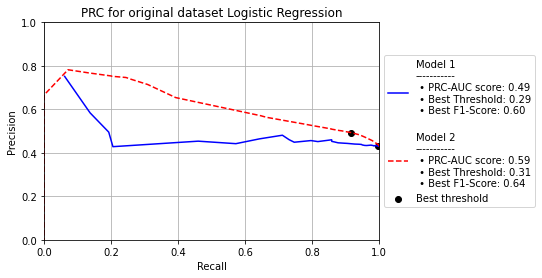

Best Threshold=0.310462, F1-Score=0.641 for model 1
Best Threshold=0.310191, F1-Score=0.641 for model 2


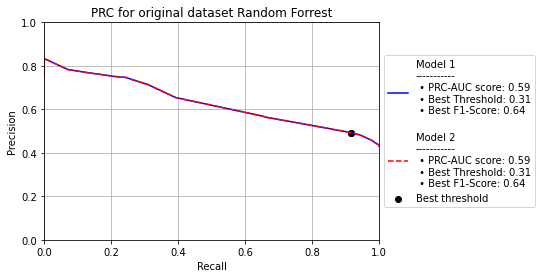

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


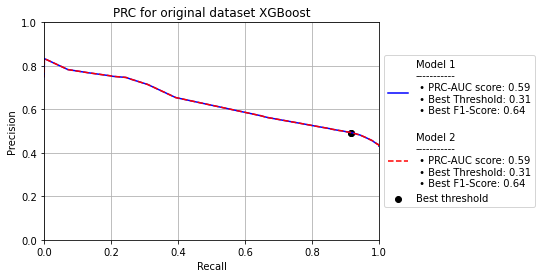


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

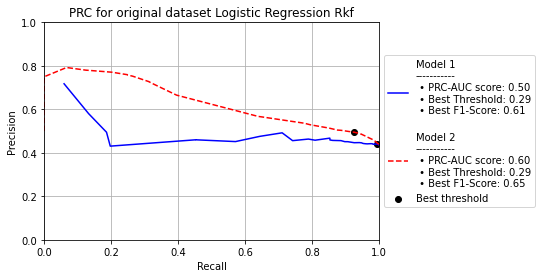

Best Threshold=0.293616, F1-Score=0.645 for model 1
Best Threshold=0.293591, F1-Score=0.645 for model 2


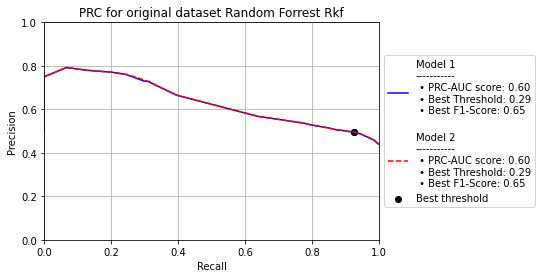

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


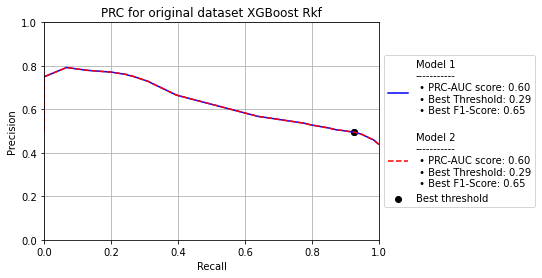

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


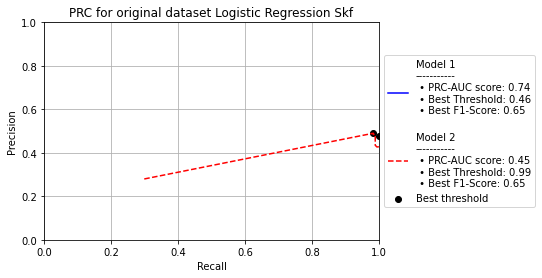

Best Threshold=1.000000, F1-Score=0.649 for model 1
Best Threshold=1.000000, F1-Score=0.650 for model 2


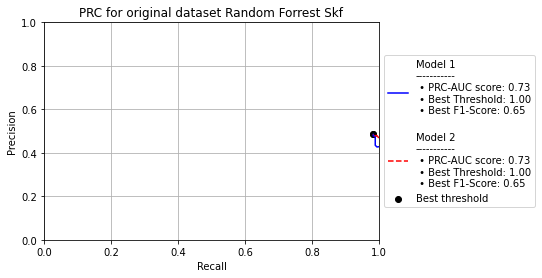

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


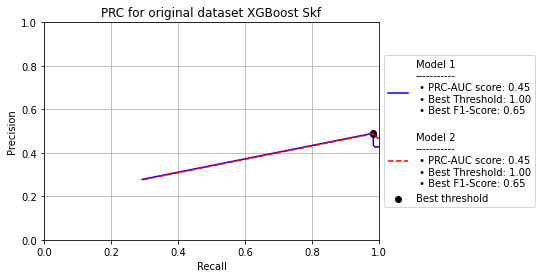

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


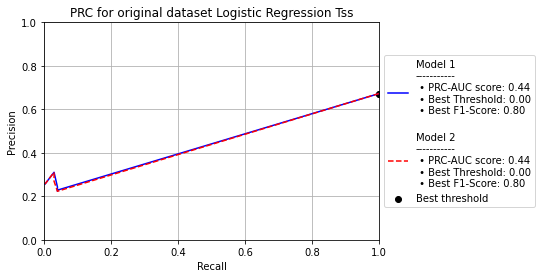

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


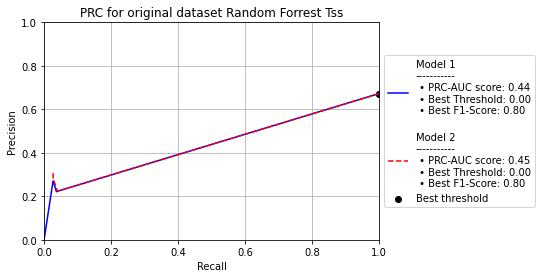

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


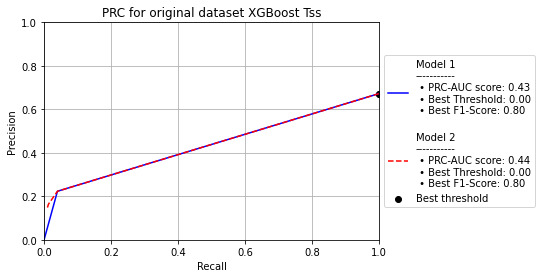

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  20   21   55   58   64   83   89   98  117  163  165  176  182  191
  212  222  224  232  233  234  235  239  242  249  253  283  285  294
  320  323  334  344  347  353  362  368  371  387  391  394  395  401
  402  404  406  414  420  421  456  462  509  511  520  559  560  561
  566  584  597  598  611  617  622  625  629  653  660  667  674  686
  707  711  712  737  743  745  751  757  763  779  792  806  809  817
  823  842  843  871  875  880  906  912  918  934  938  968  974  976
  998 1001 1004 1014 1018 1031 1034 1038 1045 1046 1054 1064 1070 1097
 1103 1109 1116 1138 1150 1159 1162 1163 1168 1174 1179 1181 1214 1220
 1222 1231 1234 1242 1259 1260 1263 1283 1299 1304 1313 1325 1327 1333
 1336 1359 1367 1372 1385 1386 1387 1394 1398 1405 1415 1422 1435 1436
 1442 1455 1469 1482 1485 1489 1500 1503 1513 1527 1531 1541 1568 1569
 1573 1575 1599 1613 1618 1625 1631 1636 1639 1658 1676 1678 1702 1705
 1716 1729 1736 1737 1738 

Precision:  0.5161290322580645
Recall:  0.5894736842105263
F1:  0.5503685503685503
Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.45      0.48       190
           1       0.52      0.59      0.55       190

    accuracy                           0.52       380
   macro avg       0.52      0.52      0.52       380
weighted avg       0.52      0.52      0.52       380

Accuracy: 0.518
TRAIN: [   0    1    2 ... 3425 3426 3427] | TEST: [3403 3405 3406 3407 3411 3418 3420 3424 3428 3429 3430 3431 3432 3433
 3434 3435 3436 3437 3438 3439 3440 3441 3442 3443 3444 3445 3446 3447
 3448 3449 3450 3451 3452 3453 3454 3455 3456 3457 3458 3459 3460 3461
 3462 3463 3464 3465 3466 3467 3468 3469 3470 3471 3472 3473 3474 3475
 3476 3477 3478 3479 3480 3481 3482 3483 3484 3485 3486 3487 3488 3489
 3490 3491 3492 3493 3494 3495 3496 3497 3498 3499 3500 3501 3502 3503
 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517
 3

Accuracy: 0.502
Mean Average-Precision Recall Score: 0.49644914495745834
TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 270

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  20   21   55   58   64   83   89   98  117  163  165  176  182  191
  212  222  224  232  233  234  235  239  242  249  253  283  285  294
  320  323  334  344  347  353  362  368  371  387  391  394  395  401
  402  404  406  414  420  421  456  462  509  511  520  559  560  561
  566  584  597  598  611  617  622  625  629  653  660  667  674  686
  707  711  712  737  743  745  751  757  763  779  792  806  809  817
  823  842  843  871  875  880  906  912  918  934  938  968  974  976
  998 1001 1004 1014 1018 1031 1034 1038 1045 1046 1054 1064 1070 1097
 1103 1109 1116 1138 1150 1159 1162 1163 1168 1174 1179 1181 1214 1220
 1222 1231 1234 1242 1259 1260 1263 1283 1299 1304 1313 1325 1327 1333
 1336 1359 1367 1372 1385 1386 1387 1394 1398 1405 1415 1422 1435 1436
 1442 1455 1469 1482 1485 1489 1500 1503 1513 1527 1531 1541 1568 1569
 1573 1575 1599 1613 1618 1625 1631 1636 1639 1658 1676 1678 1702 1705
 1716 1729 1736 1737 1738 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [3035 3037 3041 3042 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053
 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067
 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081
 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095
 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109
 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123
 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137
 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151
 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165
 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179
 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193
 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207
 3208 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221
 3222 3223 3224 3225 3226 

TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 


Scores for model 1
------------------
Roc_Auc Score: 0.5414146752151304
Average Precision-Recall Score: 0.5327342136030004
PRC-AUC for model 1: 0.5449337462265496
Accuracy: 0.540
Precision score for model 1:  0.5327125408150926
Recall score for model 1:  0.638714354760754
F1 score for model 1:  0.5809174231267995
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.44      0.49     20741
           1       0.53      0.64      0.58     20690

    accuracy                           0.54     41431
   macro avg       0.54      0.54      0.54     41431
weighted avg       0.54      0.54      0.54     41431


Scores for model 2
------------------
Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6869772426005312
Precision score for model 2:  0.6349851717210371
Recall score for model 2:  0.6416143064282261
F1 score for model 2:  0.6382825271660736
Classification Report:

        

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     4     14     15 ... 138092 138093 138097]

Model Score: 0.5469949312092687
Average Precision-Recall Score: 0.5322439154792465
PRC-AUC Score: 0.7534972834814925
Precision:  0.5461313155967781
Recall:  0.6381916714204221
F1:  0.5885834538997763
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.45      0.50      6798
           1       0.55      0.64      0.59      7012

    accuracy                           0.55     13810
   macro avg       0.55      0.55      0.54     13810
weighted avg       0.55      0.55      0.54     13810

Accuracy: 0.547
Mean Average-Precision Recall Score: 0.5473592505177518
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall

Mean Average-Precision Recall Score: 0.6762676280709183
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734479667113734
Precision:  0.6517640337094701
Recall:  0.6478773250035497
F1:  0.6498148675591
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6767
           1       0.65      0.65      0.65      7043

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.644
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall:  0

Average Precision-Recall Score: 0.6757062596323058
PRC-AUC for model 2: 0.689761369187291
Precision score for model 2:  0.6363418606879372
Recall score for model 2:  0.642311411992263
F1 score for model 2:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64      0.64     41431
weighted avg       0.64      0.64      0.64     41431

Accuracy: 0.638

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6897138902737883
Accuracy: 0.638
Precision score for model 1:  0.6363418606879372
Recall score for model 1:  0.642311411992263
F1 score for model 1:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.5014197845008075
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6905
           1       0.75      0.75      0.75      6905

    accuracy                           0.75     13810
   macro avg       0.75      0.75      0.75     13810
weighted avg       0.75      0.75      0.75     13810

Accuracy: 0.748
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.7492394082194176
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classif

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.7313797604245118
Precision:  0.5631011704716653
Recall:  0.7036929761042723
F1:  0.625595468005665
Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6905
           1       0.56      0.70      0.63      6905

    accuracy                           0.58     13810
   macro avg       0.58      0.58      0.57     13810
weighted avg       0.58      0.58      0.57     13810

Accuracy: 0.579
Mean Average-Precision Recall Score: 0.44730726099028306
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.4420036371471994
Precision:  0.5631011704716653
Rec

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.181496   0.26541399 0.12238131 0.11932041 0.31138829]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

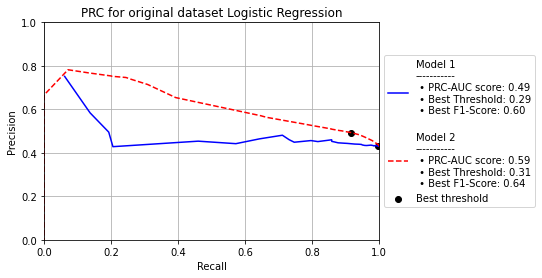

Best Threshold=0.307532, F1-Score=0.641 for model 1
Best Threshold=0.310195, F1-Score=0.641 for model 2


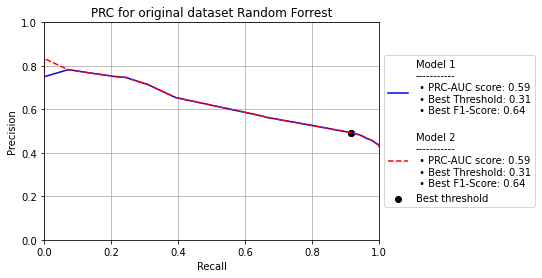

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


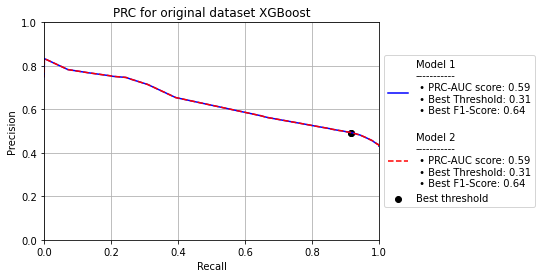


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

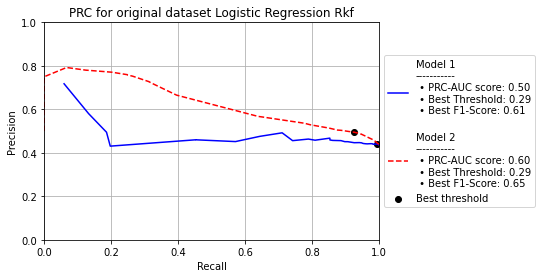

Best Threshold=0.294773, F1-Score=0.645 for model 1
Best Threshold=0.292970, F1-Score=0.645 for model 2


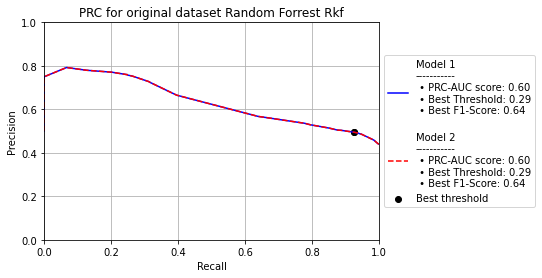

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


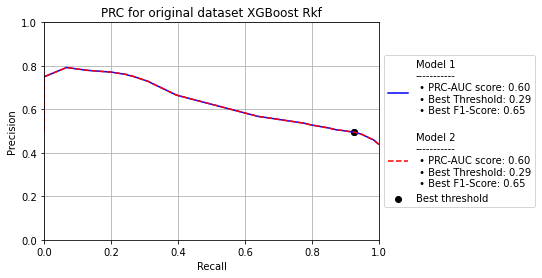

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


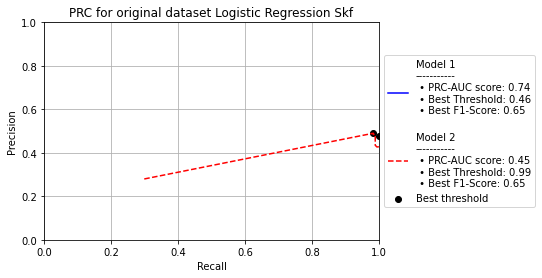

Best Threshold=1.000000, F1-Score=0.649 for model 1
Best Threshold=1.000000, F1-Score=0.650 for model 2


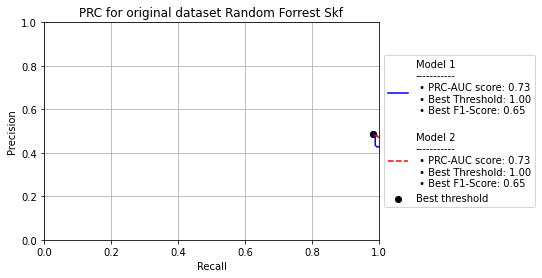

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


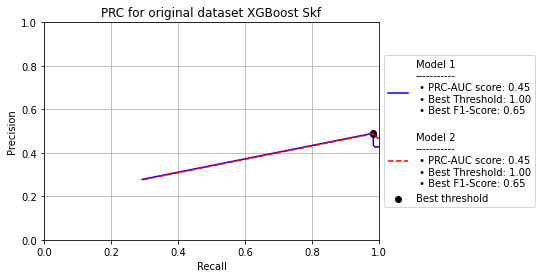

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


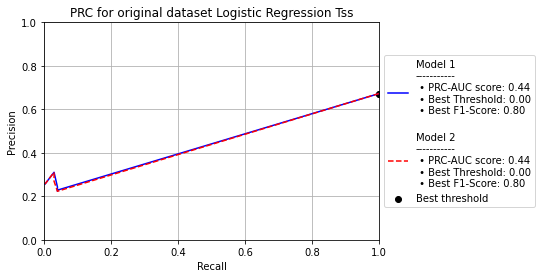

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


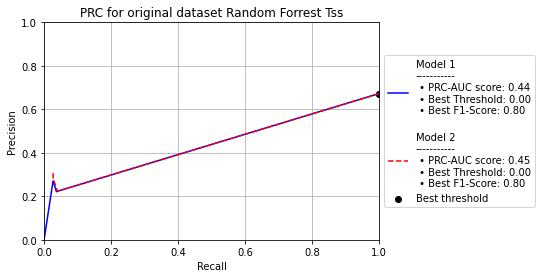

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


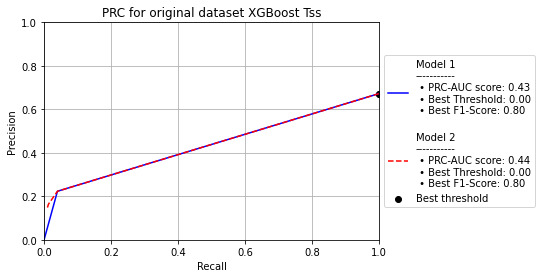

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  30   45   46   57   61   66   74   99  100  104  111  114  129  139
  158  171  175  180  199  215  237  247  254  269  275  277  282  296
  306  312  319  357  361  370  372  385  396  411  429  438  449  455
  460  473  485  490  505  514  519  535  540  541  546  548  555  556
  578  579  596  601  602  604  613  615  618  627  628  631  661  664
  670  675  677  682  719  726  748  753  754  767  784  787  804  808
  810  811  812  825  847  873  885  886  891  904  911  913  920  926
  928  977  981 1000 1013 1025 1035 1044 1051 1052 1055 1062 1065 1081
 1092 1096 1098 1105 1122 1126 1129 1132 1135 1146 1148 1152 1221 1235
 1239 1240 1244 1266 1272 1293 1294 1308 1322 1353 1354 1356 1365 1377
 1379 1391 1395 1411 1414 1416 1417 1430 1448 1452 1456 1464 1468 1471
 1477 1481 1487 1505 1507 1515 1521 1537 1538 1555 1557 1559 1560 1564
 1581 1588 1600 1601 1603 1615 1620 1632 1635 1638 1645 1663 1665 1667
 1681 1689 1699 1717 1745 

F1:  0.523943661971831
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.62      0.58       190
           1       0.56      0.49      0.52       190

    accuracy                           0.56       380
   macro avg       0.56      0.56      0.55       380
weighted avg       0.56      0.56      0.55       380

Accuracy: 0.555
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [2272 2275 2277 2279 2284 2285 2286 2287 2288 2289 2290 2291 2292 2293
 2294 2295 2296 2297 2298 2299 2300 2301 2302 2303 2304 2305 2306 2307
 2308 2309 2310 2311 2312 2313 2314 2315 2316 2317 2318 2319 2320 2321
 2322 2323 2324 2325 2326 2327 2328 2329 2330 2331 2332 2333 2334 2335
 2336 2337 2338 2339 2340 2341 2342 2343 2344 2345 2346 2347 2348 2349
 2350 2351 2352 2353 2354 2355 2356 2357 2358 2359 2360 2361 2362 2363
 2364 2365 2366 2367 2368 2369 2370 2371 2372 2373 2374 2375 2376 2377
 2378 2379 2380 2381 2382 2383 2384 2385 2386 2387 2388 2389 2

Precision:  0.5757575757575758
Recall:  0.459214501510574
F1:  0.5109243697478991
Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.63      0.57       302
           1       0.58      0.46      0.51       331

    accuracy                           0.54       633
   macro avg       0.55      0.54      0.54       633
weighted avg       0.55      0.54      0.54       633

Accuracy: 0.540
Mean Average-Precision Recall Score: 0.5217382453388597
TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 32

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  30   45   46   57   61   66   74   99  100  104  111  114  129  139
  158  171  175  180  199  215  237  247  254  269  275  277  282  296
  306  312  319  357  361  370  372  385  396  411  429  438  449  455
  460  473  485  490  505  514  519  535  540  541  546  548  555  556
  578  579  596  601  602  604  613  615  618  627  628  631  661  664
  670  675  677  682  719  726  748  753  754  767  784  787  804  808
  810  811  812  825  847  873  885  886  891  904  911  913  920  926
  928  977  981 1000 1013 1025 1035 1044 1051 1052 1055 1062 1065 1081
 1092 1096 1098 1105 1122 1126 1129 1132 1135 1146 1148 1152 1221 1235
 1239 1240 1244 1266 1272 1293 1294 1308 1322 1353 1354 1356 1365 1377
 1379 1391 1395 1411 1414 1416 1417 1430 1448 1452 1456 1464 1468 1471
 1477 1481 1487 1505 1507 1515 1521 1537 1538 1555 1557 1559 1560 1564
 1581 1588 1600 1601 1603 1615 1620 1632 1635 1638 1645 1663 1665 1667
 1681 1689 1699 1717 1745 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1894 1895 1896 1898 1902 1904 1905 1907 1908 1909 1910 1911 1912 1913
 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927
 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025
 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039
 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053
 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067
 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081
 2082 2083 2084 2085 2086 

TRAIN: [   0    1    2 ... 1265 1266 1267] | TEST: [1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281
 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295
 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309
 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323
 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337
 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351
 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365
 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379
 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393
 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407
 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421
 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435
 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448 1449
 1450 1451 1452 1453 1454 


Scores for model 1
------------------
Roc_Auc Score: 0.5414146752151304
Average Precision-Recall Score: 0.5327342136030004
PRC-AUC for model 1: 0.5449337462265496
Accuracy: 0.540
Precision score for model 1:  0.5327125408150926
Recall score for model 1:  0.638714354760754
F1 score for model 1:  0.5809174231267995
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.44      0.49     20741
           1       0.53      0.64      0.58     20690

    accuracy                           0.54     41431
   macro avg       0.54      0.54      0.54     41431
weighted avg       0.54      0.54      0.54     41431


Scores for model 2
------------------
Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6869772426005312
Precision score for model 2:  0.6349851717210371
Recall score for model 2:  0.6416143064282261
F1 score for model 2:  0.6382825271660736
Classification Report:

        

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     4     14     15 ... 138092 138093 138097]

Model Score: 0.5469949312092687
Average Precision-Recall Score: 0.5322439154792465
PRC-AUC Score: 0.7534972834814925
Precision:  0.5461313155967781
Recall:  0.6381916714204221
F1:  0.5885834538997763
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.45      0.50      6798
           1       0.55      0.64      0.59      7012

    accuracy                           0.55     13810
   macro avg       0.55      0.55      0.54     13810
weighted avg       0.55      0.55      0.54     13810

Accuracy: 0.547
Mean Average-Precision Recall Score: 0.5473592505177518
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734492193238303
Precision:  0.6517640337094701
Recall

Mean Average-Precision Recall Score: 0.6762676280709183
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734343015053268
Precision:  0.6517640337094701
Recall:  0.6478773250035497
F1:  0.6498148675591
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6767
           1       0.65      0.65      0.65      7043

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.644
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall:  0

Recall score for model 2:  0.642311411992263
F1 score for model 2:  0.6392973168090483
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64      0.64     41431
weighted avg       0.64      0.64      0.64     41431

Accuracy: 0.638

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6897138902737883
Accuracy: 0.638
Precision score for model 1:  0.6363418606879372
Recall score for model 1:  0.642311411992263
F1 score for model 1:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.6

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.5014197845008075
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6905
           1       0.75      0.75      0.75      6905

    accuracy                           0.75     13810
   macro avg       0.75      0.75      0.75     13810
weighted avg       0.75      0.75      0.75     13810

Accuracy: 0.748
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.7492394082194176
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classif

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.7313797604245118
Precision:  0.5631011704716653
Recall:  0.7036929761042723
F1:  0.625595468005665
Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6905
           1       0.56      0.70      0.63      6905

    accuracy                           0.58     13810
   macro avg       0.58      0.58      0.57     13810
weighted avg       0.58      0.58      0.57     13810

Accuracy: 0.579
Mean Average-Precision Recall Score: 0.44730726099028306
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.4420032707207916
Precision:  0.5631011704716653
Rec

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.19372037 0.26057168 0.10058874 0.10720683 0.33791237]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

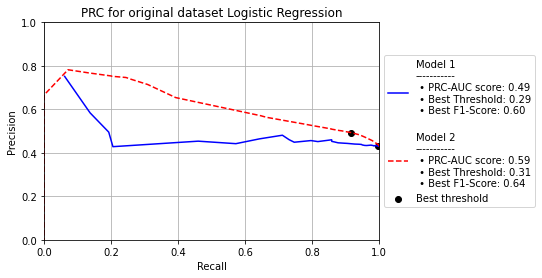

Best Threshold=0.306624, F1-Score=0.641 for model 1
Best Threshold=0.308211, F1-Score=0.641 for model 2


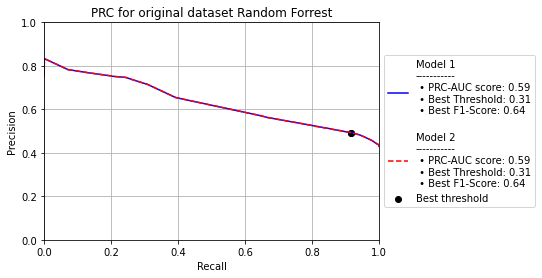

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


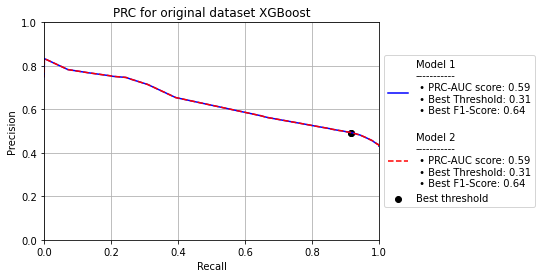


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

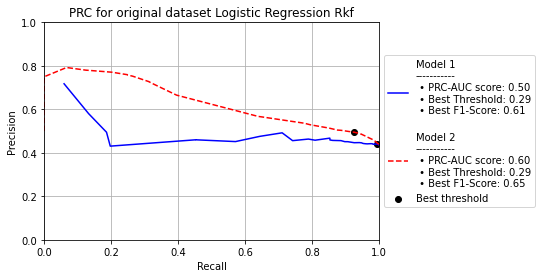

Best Threshold=0.292233, F1-Score=0.645 for model 1
Best Threshold=0.293029, F1-Score=0.645 for model 2


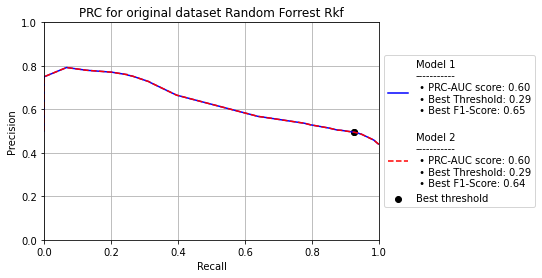

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


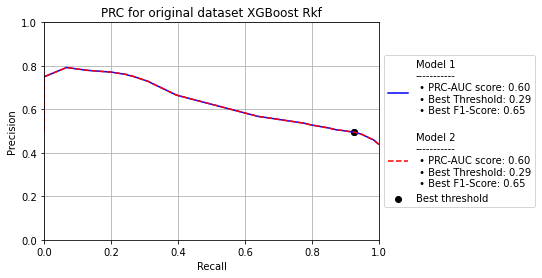

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


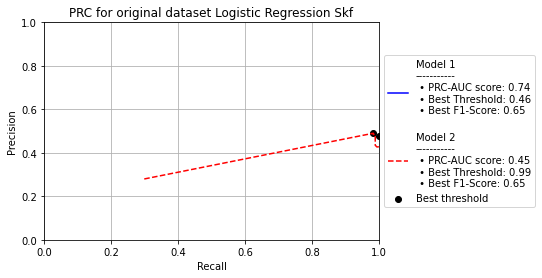

Best Threshold=1.000000, F1-Score=0.650 for model 1
Best Threshold=1.000000, F1-Score=0.649 for model 2


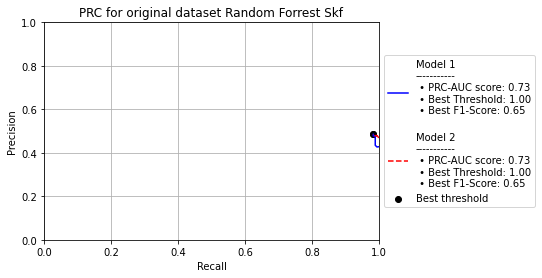

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


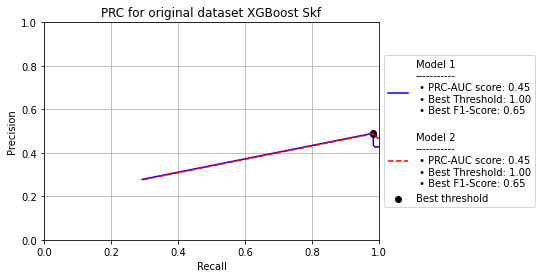

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


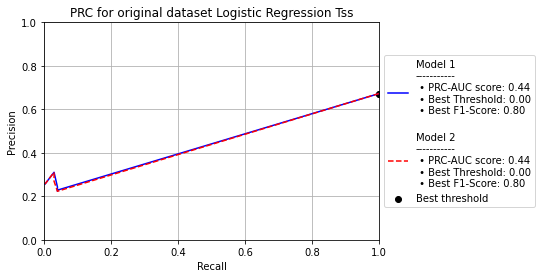

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


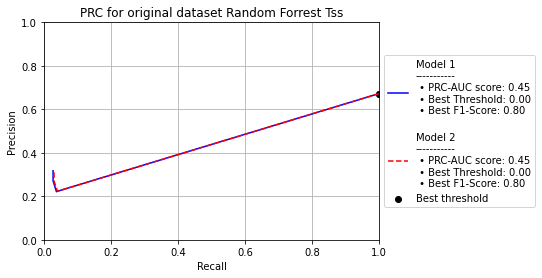

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


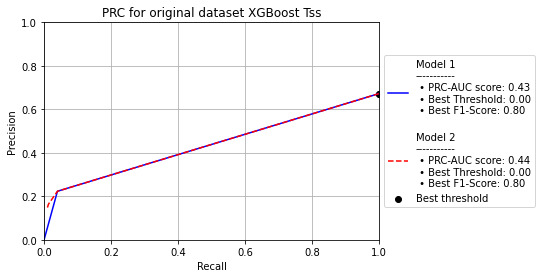

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   1    2    3 ... 3796 3798 3799] | TEST: [   0   29   30   44   61   63   80   88  102  124  152  156  166  173
  175  178  192  194  203  217  218  221  239  247  254  257  274  278
  283  289  295  305  314  324  331  332  346  368  371  376  387  408
  411  416  423  430  433  436  442  449  468  479  495  500  506  534
  549  551  554  557  561  564  573  578  599  602  621  644  650  655
  670  691  700  705  712  720  721  727  755  787  802  805  809  810
  811  816  842  864  879  893  897  915  927  929  948  949  965  976
  978  985 1022 1023 1034 1047 1052 1056 1074 1078 1080 1110 1113 1114
 1116 1117 1123 1128 1146 1149 1164 1174 1187 1188 1226 1228 1231 1251
 1272 1293 1295 1313 1320 1351 1352 1356 1361 1362 1402 1406 1407 1411
 1412 1417 1422 1429 1454 1457 1487 1490 1498 1511 1513 1546 1554 1556
 1572 1582 1583 1588 1593 1602 1612 1620 1621 1627 1659 1660 1675 1735
 1744 1752 1784 1788 1807 1811 1812 1822 1844 1862 1871 1873 1874 1876
 1885 1897 1916 1922 1924 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1124 1127 1128 1132 1135 1136 1137 1141 1144 1145 1146 1149 1151 1152
 1153 1154 1155 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195
 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209
 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223
 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237
 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251
 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265
 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279
 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293
 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307
 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321
 1322 1323 1324 1325 1326 


Model Score: 0.4881516587677725

Average Precision-Recall Score: 0.5200621035258162
PRC-AUC Score: 0.7622432859399684
Precision:  0.5142857142857142
Recall:  0.43373493975903615
F1:  0.47058823529411764
Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.55      0.50       301
           1       0.51      0.43      0.47       332

    accuracy                           0.49       633
   macro avg       0.49      0.49      0.49       633
weighted avg       0.49      0.49      0.49       633

Accuracy: 0.488
Mean Average-Precision Recall Score: 0.5145027879137664
TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 25

TRAIN: [   1    2    3 ... 3796 3798 3799] | TEST: [   0   29   30   44   61   63   80   88  102  124  152  156  166  173
  175  178  192  194  203  217  218  221  239  247  254  257  274  278
  283  289  295  305  314  324  331  332  346  368  371  376  387  408
  411  416  423  430  433  436  442  449  468  479  495  500  506  534
  549  551  554  557  561  564  573  578  599  602  621  644  650  655
  670  691  700  705  712  720  721  727  755  787  802  805  809  810
  811  816  842  864  879  893  897  915  927  929  948  949  965  976
  978  985 1022 1023 1034 1047 1052 1056 1074 1078 1080 1110 1113 1114
 1116 1117 1123 1128 1146 1149 1164 1174 1187 1188 1226 1228 1231 1251
 1272 1293 1295 1313 1320 1351 1352 1356 1361 1362 1402 1406 1407 1411
 1412 1417 1422 1429 1454 1457 1487 1490 1498 1511 1513 1546 1554 1556
 1572 1582 1583 1588 1593 1602 1612 1620 1621 1627 1659 1660 1675 1735
 1744 1752 1784 1788 1807 1811 1812 1822 1844 1862 1871 1873 1874 1876
 1885 1897 1916 1922 1924 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [2650 2652 2653 2655 2657 2658 2659 2660 2661 2663 2665 2668 2670 2671
 2672 2673 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729
 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743
 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757
 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771
 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785
 2786 2787 2788 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799
 2800 2801 2802 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813
 2814 2815 2816 2817 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827
 2828 2829 2830 2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841
 2842 2843 2844 2845 2846 

TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 

TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 

Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6457632598119071
Precision score for model 2:  0.55513906375186
Recall score for model 2:  0.9376993716771387
F1 score for model 2:  0.6974010568316619
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.25      0.38     20741
           1       0.56      0.94      0.70     20690

    accuracy                           0.59     41431
   macro avg       0.68      0.59      0.54     41431
weighted avg       0.68      0.59      0.54     41431

Accuracy: 0.594

Scores for model 1
------------------
Roc_Auc Score: 0.697992241488613
Average Precision-Recall Score: 0.6725835726259062
PRC-AUC for model 1: 0.6481524895625218
Accuracy: 0.592
Precision score for model 1:  0.5537620633700572
Recall score for model 1:  0.9401643305944901
F1 score for model 1:  0.6969919558557428
Classification Report:

              precision    recall

TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.9748626565351836
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.15      1.00      0.26      3390
           1       0.00      0.00      0.00     19627

    accuracy                           0.15     23017
   macro avg       0.07      0.50      0.13     23017
weighted avg       0.02      0.15      0.04     23017

Accuracy: 0.147
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.14728244341139157

Average Precision-Recall Score: 0.8527175565886084
PRC-AUC Score: 0.932561245495237
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0     

TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.3662944779945258

Average Precision-Recall Score: 0.8106145860687655
PRC-AUC Score: 0.9234657733617746
Precision:  0.7449227480322612
Recall:  0.3905843990421358
F1:  0.51246741092319
Classification Report:

              precision    recall  f1-score   support

           0       0.06      0.23      0.09      3390
           1       0.74      0.39      0.51     19627

    accuracy                           0.37     23017
   macro avg       0.40      0.31      0.30     23017
weighted avg       0.64      0.37      0.45     23017

Accuracy: 0.366
Mean Average-Precision Recall Score: 0.5565300744661613
TRAIN: [     0      1      2 ... 115082 115083 115084] | TEST: [115085 115086 115087 ... 138099 138100 138101]

Model Score: 0.4063952730590433

Average Precision-Recall Score: 0.8974718487629366
PRC-AUC Score: 0.9638147275922478
Precision:  1.0
Recall:  0.303867121

Accuracy: 0.599

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6503288018053685
Accuracy: 0.599
Precision score for model 1:  0.5583043939959246
Recall score for model 1:  0.9406673114119922
F1 score for model 1:  0.7007186211119716
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.26      0.39     20751
           1       0.56      0.94      0.70     20680

    accuracy                           0.60     41431
   macro avg       0.69      0.60      0.55     41431
weighted avg       0.69      0.60      0.55     41431


Scores for model 2
------------------
Roc_Auc Score: 0.7020334971156107
Average Precision-Recall Score: 0.6756572483351841
PRC-AUC for model 2: 0.6503288018053685
Precision score for model 2:  0.5583043939959246
Recall score for model 2:  0.9406673114119922
F1 score for model 2:  0.7007186211119716
Classification 

TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.24395012382152323
F1:  0.392218496786812
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
TRAIN: [     0      2      3 ... 138099 138100 138101] | TEST: [     1      7     12 ... 138073 138090 138098]

Model Score: 0.6420709630702389
Average Precision-Recall Score: 0.597485579456884
PRC-AUC Score: 0.6540909129062146
Precision:  0.6466229695069821
Recall:  0.6481931152692473
F1:  0.647407090377345
Classification Report:

              precision    recall  f

TRAIN: [    0     1     2 ... 92065 92066 92067] | TEST: [ 92068  92069  92070 ... 115082 115083 115084]

Model Score: 0.24395012382152323

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.24395012382152323
F1:  0.392218496786812
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39     23017

    accuracy                           0.24     23017
   macro avg       0.50      0.12      0.20     23017
weighted avg       1.00      0.24      0.39     23017

Accuracy: 0.244
                                                 Test  Model1 score  \
0                        Original_Logistic_Regression      0.570255   
1                             Original_Random_Forrest      0.650565   
2                             Original_XGB_Classifier      0.650068   
3         Original_Logistic_Regression_Best_Threshold      0.570255   
4              

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.17052473 0.2677436  0.11300156 0.11267106 0.33605905]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

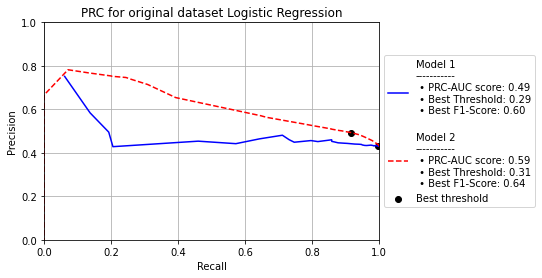

Best Threshold=0.309091, F1-Score=0.641 for model 1
Best Threshold=0.310232, F1-Score=0.641 for model 2


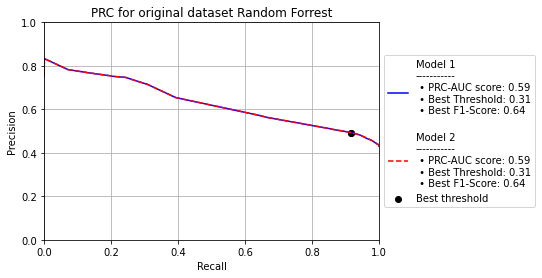

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


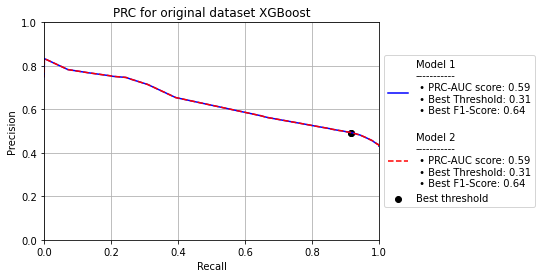


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

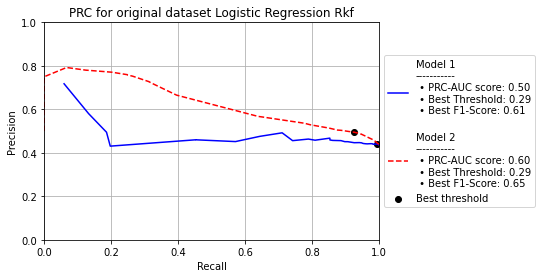

Best Threshold=0.293347, F1-Score=0.645 for model 1
Best Threshold=0.291868, F1-Score=0.645 for model 2


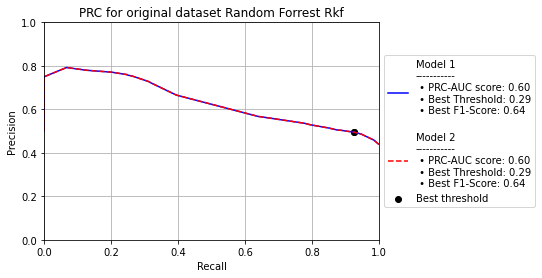

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


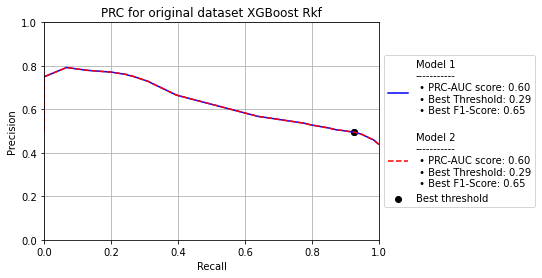

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


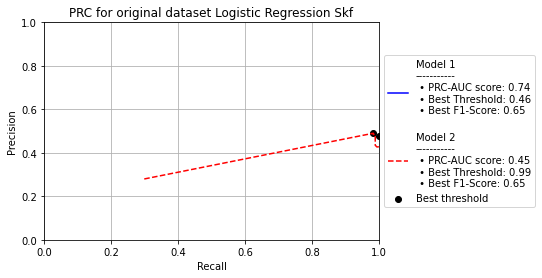

Best Threshold=1.000000, F1-Score=0.650 for model 1
Best Threshold=1.000000, F1-Score=0.650 for model 2


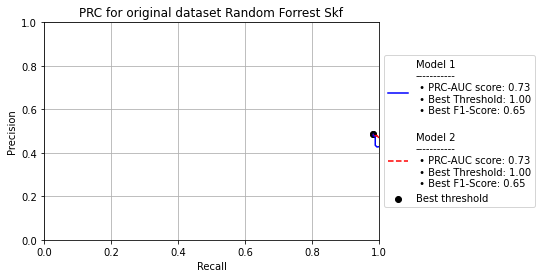

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


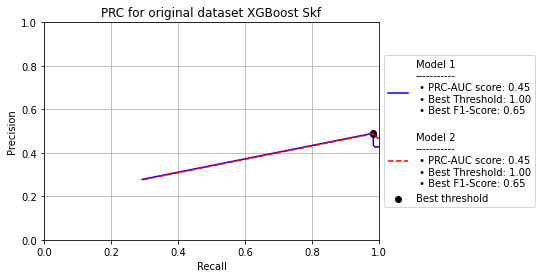

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


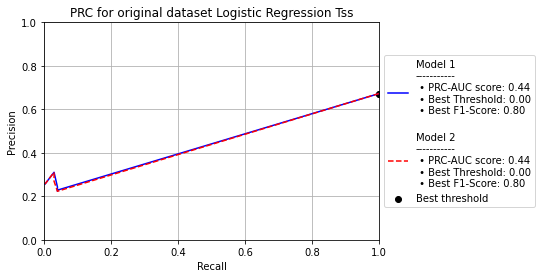

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


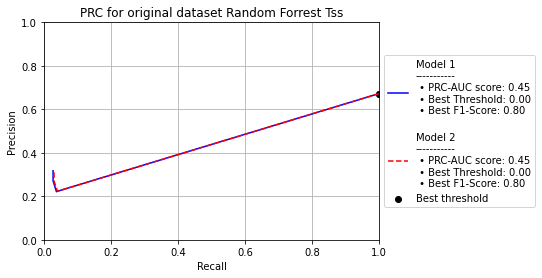

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


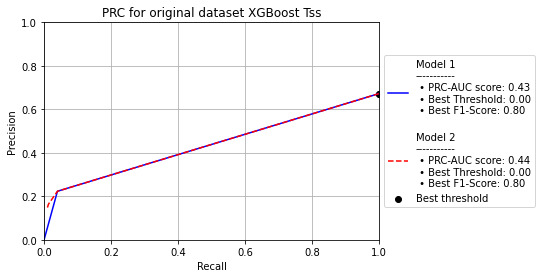

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  12   17   37   59   68   75   78  102  105  116  120  128  132  136
  138  145  166  168  197  211  213  221  225  228  230  236  250  266
  298  327  328  331  332  340  343  355  366  378  392  400  432  436
  444  445  452  453  454  495  507  515  523  527  538  550  551  591
  600  610  612  614  616  648  657  659  672  679  696  701  703  724
  741  752  760  766  768  769  772  773  780  790  797  802  803  818
  824  827  828  832  833  841  858  870  879  897  898  915  925  930
  940  941  943  945  949  961  964  990  992  994  999 1008 1009 1023
 1030 1040 1043 1047 1049 1057 1095 1102 1108 1124 1127 1144 1153 1172
 1176 1196 1197 1205 1209 1215 1218 1225 1228 1238 1258 1287 1295 1298
 1301 1305 1306 1311 1314 1316 1328 1346 1352 1357 1366 1370 1392 1400
 1412 1423 1426 1428 1429 1438 1447 1460 1463 1475 1483 1524 1526 1544
 1547 1550 1553 1554 1561 1563 1586 1598 1612 1624 1633 1642 1656 1668
 1672 1675 1686 1695 1700 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1112 1116 1117 1121 1123 1127 1129 1130 1131 1134 1136 1137 1139 1141
 1142 1144 1145 1146 1148 1150 1151 1152 1153 1154 1155 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195
 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209
 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223
 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237
 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251
 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265
 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279
 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293
 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307
 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321
 1322 1323 1324 1325 1326 

Precision:  0.5284090909090909
Recall:  0.2888198757763975
F1:  0.3734939759036145
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.73      0.59       311
           1       0.53      0.29      0.37       322

    accuracy                           0.51       633
   macro avg       0.51      0.51      0.48       633
weighted avg       0.51      0.51      0.48       633

Accuracy: 0.507
Mean Average-Precision Recall Score: 0.510974552890464
TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 19

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  18   21   24   42   49   60   62   64   68   72   77   82   99  103
  112  127  134  139  150  152  166  174  175  191  201  207  212  214
  218  255  261  271  274  283  294  300  309  312  337  360  362  366
  368  369  374  389  402  406  412  424  442  444  450  451  463  480
  489  493  499  508  516  517  520  524  559  560  567  568  581  594
  595  602  609  617  648  658  661  668  673  679  689  690  700  725
  741  744  758  759  762  777  801  816  820  821  839  841  850  859
  874  887  890  894  901  945  949  976  992  999 1014 1023 1030 1035
 1045 1070 1088 1099 1104 1107 1111 1134 1151 1157 1164 1177 1184 1187
 1189 1191 1211 1214 1228 1233 1271 1293 1306 1327 1331 1337 1341 1348
 1358 1361 1363 1364 1389 1392 1401 1415 1432 1435 1437 1459 1466 1472
 1473 1476 1481 1491 1497 1503 1506 1516 1518 1526 1537 1549 1567 1572
 1573 1583 1597 1598 1642 1658 1659 1661 1692 1712 1717 1742 1752 1779
 1799 1813 1815 1818 1822 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1112 1116 1117 1121 1123 1127 1129 1130 1131 1134 1136 1137 1139 1141
 1142 1144 1145 1146 1148 1150 1151 1152 1153 1154 1155 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195
 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209
 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223
 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237
 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251
 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265
 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279
 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293
 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307
 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321
 1322 1323 1324 1325 1326 

TRAIN: [   0    1    2 ... 1898 1899 1900] | TEST: [1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026
 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040
 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054
 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068
 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082
 2083 2084 2085 2086 2087 


Scores for model 1
------------------
Roc_Auc Score: 0.5414146752151304
Average Precision-Recall Score: 0.5327342136030004
PRC-AUC for model 1: 0.5449337462265496
Accuracy: 0.540
Precision score for model 1:  0.5327125408150926
Recall score for model 1:  0.638714354760754
F1 score for model 1:  0.5809174231267995
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.44      0.49     20741
           1       0.53      0.64      0.58     20690

    accuracy                           0.54     41431
   macro avg       0.54      0.54      0.54     41431
weighted avg       0.54      0.54      0.54     41431


Scores for model 2
------------------
Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6869772426005312
Precision score for model 2:  0.6349851717210371
Recall score for model 2:  0.6416143064282261
F1 score for model 2:  0.6382825271660736
Classification Report:

        

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     4     14     15 ... 138092 138093 138097]

Model Score: 0.5469949312092687
Average Precision-Recall Score: 0.5322439154792465
PRC-AUC Score: 0.7534972834814925
Precision:  0.5461313155967781
Recall:  0.6381916714204221
F1:  0.5885834538997763
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.45      0.50      6798
           1       0.55      0.64      0.59      7012

    accuracy                           0.55     13810
   macro avg       0.55      0.55      0.54     13810
weighted avg       0.55      0.55      0.54     13810

Accuracy: 0.547
Mean Average-Precision Recall Score: 0.5473592505177518
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734492193238303
Precision:  0.6517640337094701
Recall

Mean Average-Precision Recall Score: 0.6762676280709183
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734479667113734
Precision:  0.6517640337094701
Recall:  0.6478773250035497
F1:  0.6498148675591
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6767
           1       0.65      0.65      0.65      7043

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.644
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall:  0

Average Precision-Recall Score: 0.6756524187486865
PRC-AUC for model 2: 0.6897086446063329
Precision score for model 2:  0.636311377245509
Recall score for model 2:  0.642311411992263
F1 score for model 2:  0.6392973168090483
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64      0.64     41431
weighted avg       0.64      0.64      0.64     41431

Accuracy: 0.638

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6897138902737883
Accuracy: 0.638
Precision score for model 1:  0.6363418606879372
Recall score for model 1:  0.642311411992263
F1 score for model 1:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.5014197845008075
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6905
           1       0.75      0.75      0.75      6905

    accuracy                           0.75     13810
   macro avg       0.75      0.75      0.75     13810
weighted avg       0.75      0.75      0.75     13810

Accuracy: 0.748
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.7492394082194176
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classif

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.7313797604245118
Precision:  0.5631011704716653
Recall:  0.7036929761042723
F1:  0.625595468005665
Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6905
           1       0.56      0.70      0.63      6905

    accuracy                           0.58     13810
   macro avg       0.58      0.58      0.57     13810
weighted avg       0.58      0.58      0.57     13810

Accuracy: 0.579
Mean Average-Precision Recall Score: 0.44730726099028306
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.4420032707207916
Precision:  0.5631011704716653
Rec

----------Model 1 Feature Importance----------
----Logistic Regression----
Feature: PageRank, Score: 1.68070732572351
Feature: Betweenness, Score: -0.6085822685306285
Feature: Closeness, Score: -1.5808910525345967
Feature: Harmonic, Score: 2.549714394755861
Feature: Degree, Score: -0.48880929149801816
----Random Forrest----
[0.18879025 0.23198338 0.11481058 0.11500188 0.3494139 ]
----XGB----
[0.13484259 0.44853553 0.0083814  0.         0.4082405 ]

Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49660511826243303
Accuracy: 0.570
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     17212
           1       0.00      0.00      0.00     12971

    accuracy                           0.57     30183
   macro avg       0.29      0.50  

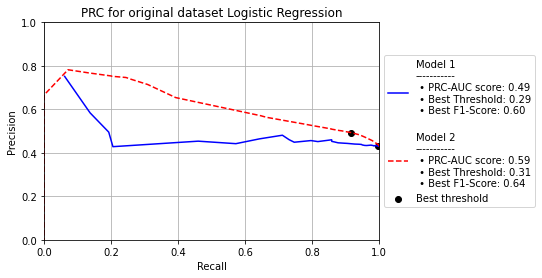

Best Threshold=0.310005, F1-Score=0.641 for model 1
Best Threshold=0.306546, F1-Score=0.641 for model 2


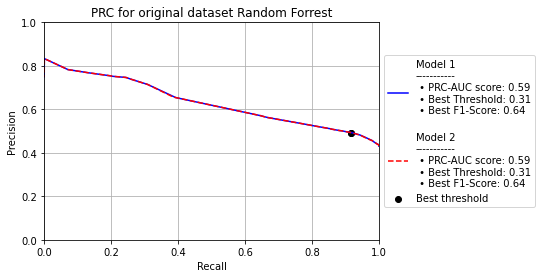

Best Threshold=0.309828, F1-Score=0.641 for model 1
Best Threshold=0.309169, F1-Score=0.641 for model 2


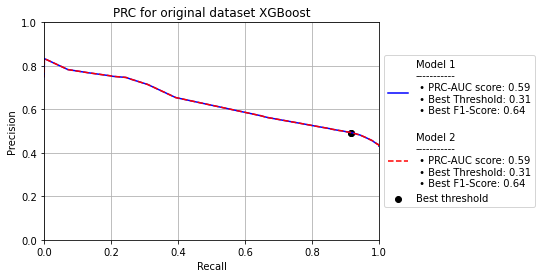


Scores for model 1
------------------
Roc_Auc Score: 0.5464845016268526
Average Precision-Recall Score: 0.48356687404323
PRC-AUC for model 1: 0.49491036592511195
Accuracy: 0.438
Precision score for model 1:  0.43306294831400416
Recall score for model 1:  0.9960681520314548
F1 score for model 1:  0.6036677958182456
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.02      0.03     17212
           1       0.43      1.00      0.60     12971

    accuracy                           0.44     30183
   macro avg       0.64      0.51      0.32     30183
weighted avg       0.67      0.44      0.28     30183


Scores for model 2
------------------
Roc_Auc Score: 0.7002994201494878
Average Precision-Recall Score: 0.6129819109649143
PRC-AUC for model 2: 0.5870450799620693
Precision score for model 2:  0.49324100182451486
Recall score for model 2:  0.9170457173695166
F1 score for model 2:  0.6414646641680374
Classification Report:

      

TRAIN: [     0      1      2 ... 120727 120728 120729] | TEST: [66354 66355 66356 ... 86998 86999 87000]

Model Score: 0.5446864905160275

Average Precision-Recall Score: 0.48338666237688477
PRC-AUC Score: 0.4522629848865752
Precision:  0.48432288192128087
Recall:  0.983359133126935
F1:  0.6490007023817125
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.22      0.35      6905
           1       0.48      0.98      0.65      5168

    accuracy                           0.54     12073
   macro avg       0.71      0.60      0.50     12073
weighted avg       0.75      0.54      0.48     12073

Accuracy: 0.545
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.3277173102728493

Average Precision-Recall Score: 0.6722826897271508
PRC-AUC Score: 0.444582365655877
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   

TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.4419775067074143
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.86      0.45      6594
           1       0.31      0.03      0.05     13527

    accuracy                           0.30     20121
   macro avg       0.31      0.45      0.25     20121
weighted avg       0.31      0.30      0.18     20121

Accuracy: 0.303
TRAIN: [    0     1     2 ... 20122 20123 20124] | TEST: [20125 20126 20127 ... 40243 40244 40245]

Model Score: 0.30326524526613985

Average Precision-Recall Score: 0.6615036975032932
PRC-AUC Score: 0.49626189468728205
Precision:  0.31047765793528503
Recall:  0.029792267317217416
F1:  0.054367622259696456
Classification Rep

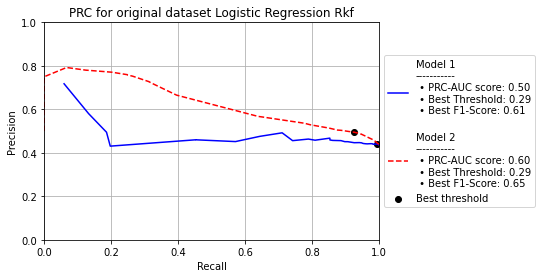

Best Threshold=0.293605, F1-Score=0.645 for model 1
Best Threshold=0.292469, F1-Score=0.645 for model 2


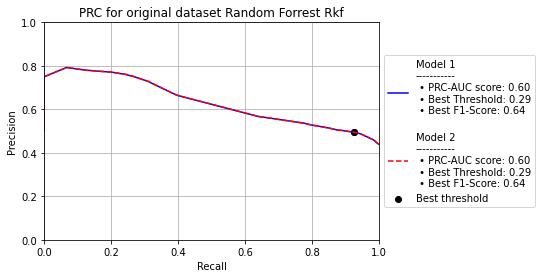

Best Threshold=0.292542, F1-Score=0.645 for model 1
Best Threshold=0.293618, F1-Score=0.645 for model 2


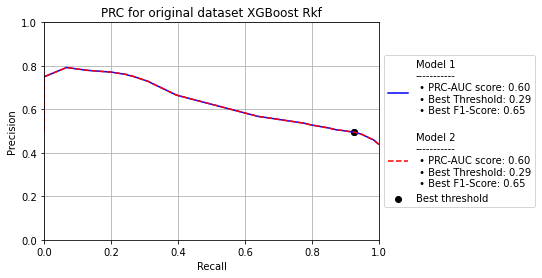

Best Threshold=0.458631, F1-Score=0.645 for model 1
Best Threshold=0.989465, F1-Score=0.654 for model 2


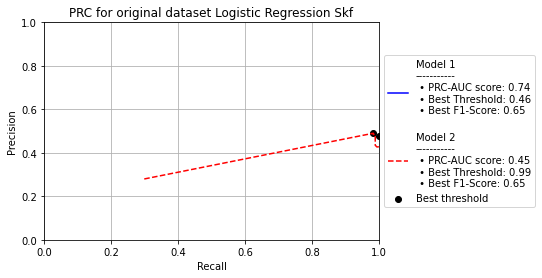

Best Threshold=1.000000, F1-Score=0.650 for model 1
Best Threshold=1.000000, F1-Score=0.650 for model 2


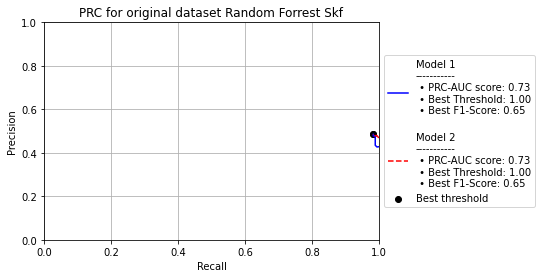

Best Threshold=0.997116, F1-Score=0.654 for model 1
Best Threshold=0.998933, F1-Score=0.652 for model 2


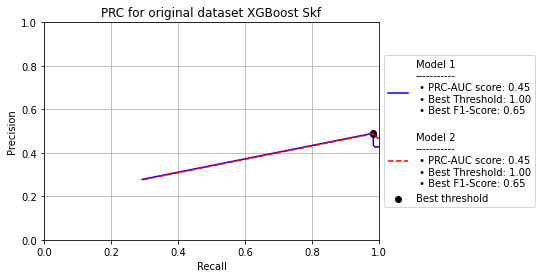

Best Threshold=0.003080, F1-Score=0.804 for model 1
Best Threshold=0.000143, F1-Score=0.804 for model 2


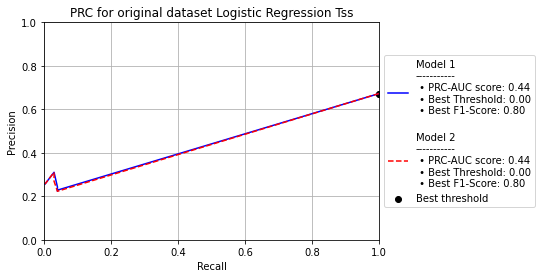

Best Threshold=0.000000, F1-Score=0.804 for model 1
Best Threshold=0.000000, F1-Score=0.804 for model 2


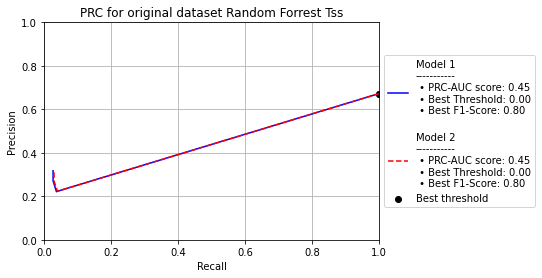

Best Threshold=0.000100, F1-Score=0.804 for model 1
Best Threshold=0.000080, F1-Score=0.804 for model 2


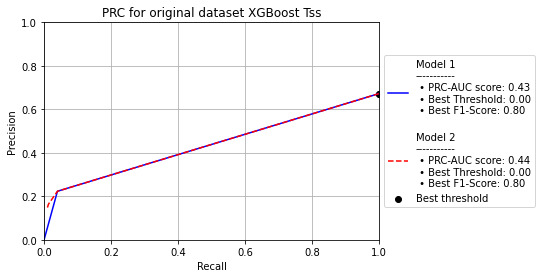

0    1900
1    1900
Name: Bug, dtype: int64

Scores for model 1
------------------
Roc_Auc Score: 0.5480536197652827
Average Precision-Recall Score: 0.5257314878842727
PRC-AUC for model 1: 0.5435021170913905
Accuracy: 0.539
Precision score for model 1:  0.5246153846153846
Recall score for model 1:  0.6122082585278277
F1 score for model 1:  0.5650372825186413
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       583
           1       0.52      0.61      0.57       557

    accuracy                           0.54      1140
   macro avg       0.54      0.54      0.54      1140
weighted avg       0.54      0.54      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.690816398803933
Average Precision-Recall Score: 0.6610997953075746
PRC-AUC for model 2: 0.6810018446797687
Precision score for model 2:  0.5990566037735849
Recall score for model 2:  0.6840215439856373
F1 score for model 2:  0.63872

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  30   45   46   57   61   66   74   99  100  104  111  114  129  139
  158  171  175  180  199  215  237  247  254  269  275  277  282  296
  306  312  319  357  361  370  372  385  396  411  429  438  449  455
  460  473  485  490  505  514  519  535  540  541  546  548  555  556
  578  579  596  601  602  604  613  615  618  627  628  631  661  664
  670  675  677  682  719  726  748  753  754  767  784  787  804  808
  810  811  812  825  847  873  885  886  891  904  911  913  920  926
  928  977  981 1000 1013 1025 1035 1044 1051 1052 1055 1062 1065 1081
 1092 1096 1098 1105 1122 1126 1129 1132 1135 1146 1148 1152 1221 1235
 1239 1240 1244 1266 1272 1293 1294 1308 1322 1353 1354 1356 1365 1377
 1379 1391 1395 1411 1414 1416 1417 1430 1448 1452 1456 1464 1468 1471
 1477 1481 1487 1505 1507 1515 1521 1537 1538 1555 1557 1559 1560 1564
 1581 1588 1600 1601 1603 1615 1620 1632 1635 1638 1645 1663 1665 1667
 1681 1689 1699 1717 1745 

TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1866 1867 1869 1871 1873 1874 1876 1877 1879 1881 1883 1884 1885 1890
 1893 1898 1900 1901 1902 1904 1905 1906 1908 1909 1910 1911 1915 1916
 1917 1920 1921 1922 1924 1928 1931 1935 1936 1937 1938 1939 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025
 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039
 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053
 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067
 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081
 2082 2083 2084 2085 2086 

Accuracy: 0.463
Mean Average-Precision Recall Score: 0.49129804524450515
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226

TRAIN: [   1    2    3 ... 3796 3798 3799] | TEST: [   0   29   30   44   61   63   80   88  102  124  152  156  166  173
  175  178  192  194  203  217  218  221  239  247  254  257  274  278
  283  289  295  305  314  324  331  332  346  368  371  376  387  408
  411  416  423  430  433  436  442  449  468  479  495  500  506  534
  549  551  554  557  561  564  573  578  599  602  621  644  650  655
  670  691  700  705  712  720  721  727  755  787  802  805  809  810
  811  816  842  864  879  893  897  915  927  929  948  949  965  976
  978  985 1022 1023 1034 1047 1052 1056 1074 1078 1080 1110 1113 1114
 1116 1117 1123 1128 1146 1149 1164 1174 1187 1188 1226 1228 1231 1251
 1272 1293 1295 1313 1320 1351 1352 1356 1361 1362 1402 1406 1407 1411
 1412 1417 1422 1429 1454 1457 1487 1490 1498 1511 1513 1546 1554 1556
 1572 1582 1583 1588 1593 1602 1612 1620 1621 1627 1659 1660 1675 1735
 1744 1752 1784 1788 1807 1811 1812 1822 1844 1862 1871 1873 1874 1876
 1885 1897 1916 1922 1924 

TRAIN: [ 378  381  382 ... 3797 3798 3799] | TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

Mean Average-Precision Recall Score: 0.5125338897947841
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 


Scores for model 1
------------------
Roc_Auc Score: 0.5414146752151304
Average Precision-Recall Score: 0.5327342136030004
PRC-AUC for model 1: 0.5449337462265496
Accuracy: 0.540
Precision score for model 1:  0.5327125408150926
Recall score for model 1:  0.638714354760754
F1 score for model 1:  0.5809174231267995
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.44      0.49     20741
           1       0.53      0.64      0.58     20690

    accuracy                           0.54     41431
   macro avg       0.54      0.54      0.54     41431
weighted avg       0.54      0.54      0.54     41431


Scores for model 2
------------------
Roc_Auc Score: 0.6978338377516122
Average Precision-Recall Score: 0.6724125657512151
PRC-AUC for model 2: 0.6869772426005312
Precision score for model 2:  0.6349851717210371
Recall score for model 2:  0.6416143064282261
F1 score for model 2:  0.6382825271660736
Classification Report:

        

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [     4     14     15 ... 138092 138093 138097]

Model Score: 0.5469949312092687
Average Precision-Recall Score: 0.5322439154792465
PRC-AUC Score: 0.7534972834814925
Precision:  0.5461313155967781
Recall:  0.6381916714204221
F1:  0.5885834538997763
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.45      0.50      6798
           1       0.55      0.64      0.59      7012

    accuracy                           0.55     13810
   macro avg       0.55      0.55      0.54     13810
weighted avg       0.55      0.55      0.54     13810

Accuracy: 0.547
Mean Average-Precision Recall Score: 0.5473592505177518
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734492193238303
Precision:  0.6517640337094701
Recall

Mean Average-Precision Recall Score: 0.6762676280709183
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734481953187876
Precision:  0.6517640337094701
Recall:  0.6478773250035497
F1:  0.6498148675591
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6767
           1       0.65      0.65      0.65      7043

    accuracy                           0.64     13810
   macro avg       0.64      0.64      0.64     13810
weighted avg       0.64      0.64      0.64     13810

Accuracy: 0.644
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [    46     54     68 ... 138081 138085 138091]

Model Score: 0.643881245474294
Average Precision-Recall Score: 0.6018431531754741
PRC-AUC Score: 0.6734475612443196
Precision:  0.6517640337094701
Recall:  0

F1 score for model 2:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64      0.64     41431
weighted avg       0.64      0.64      0.64     41431

Accuracy: 0.638

Scores for model 1
------------------
Roc_Auc Score: 0.7020335810061401
Average Precision-Recall Score: 0.6756572694884112
PRC-AUC for model 1: 0.6897138902737883
Accuracy: 0.638
Precision score for model 1:  0.6363418606879372
Recall score for model 1:  0.642311411992263
F1 score for model 1:  0.6393127015449777
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64     20751
           1       0.64      0.64      0.64     20680

    accuracy                           0.64     41431
   macro avg       0.64      0.64

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.5014197845008075
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6905
           1       0.75      0.75      0.75      6905

    accuracy                           0.75     13810
   macro avg       0.75      0.75      0.75     13810
weighted avg       0.75      0.75      0.75     13810

Accuracy: 0.748
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 55241  55242  55243 ... 131194 131195 131196]

Model Score: 0.7477190441708906

Average Precision-Recall Score: 0.6854203858155496
PRC-AUC Score: 0.7492394082194176
Precision:  0.7485108237687055
Recall:  0.7461259956553222
F1:  0.7473165071076299
Classif

TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.7313797604245118
Precision:  0.5631011704716653
Recall:  0.7036929761042723
F1:  0.625595468005665
Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6905
           1       0.56      0.70      0.63      6905

    accuracy                           0.58     13810
   macro avg       0.58      0.58      0.57     13810
weighted avg       0.58      0.58      0.57     13810

Accuracy: 0.579
Mean Average-Precision Recall Score: 0.44730726099028306
TRAIN: [     0      1      2 ... 138099 138100 138101] | TEST: [ 48336  48337  48338 ... 124289 124290 124291]

Model Score: 0.5788559015206373

Average Precision-Recall Score: 0.5444038504448692
PRC-AUC Score: 0.4470551944086414
Precision:  0.5631011704716653
Rec

In [22]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders

start = 0

if os.path.exists('out.csv'):
    final_result_df = pd.read_csv('out.csv')
    for index, row in final_results_df:
        if row['XGB_precision_1'] == 0:
            break
        start += 1
else:
    final_result_df = pd.DataFrame({'XGB_precision_1':[None]*14, 
                                'XGB_precision_2':[None]*14,
                                'XGB_recall_1':[None]*14, 
                                'XGB_recall_2':[None]*14,
                                'XGB_f1_1':[None]*14, 
                                'XGB_f1_2':[None]*14,
                                'XGB_PRC_AUC_1':[None]*14,
                                'XGB_PRC_AUC_2':[None]*14,
                                'LR_precision_1':[None]*14, 
                                'LR_precision_2':[None]*14, 
                                'LR_recall_1':[None]*14, 
                                'LR_recall_2':[None]*14, 
                                'LR_f1_1':[None]*14, 
                                'LR_f1_2':[None]*14, 
                                'LR_PRC_AUC_1':[None]*14, 
                                'LR_PRC_AUC_2':[None]*14,
                                'RF_precision_1':[None]*14, 
                                'RF_precision_2':[None]*14,
                                'RF_recall_1':[None]*14, 
                                'RF_recall_2':[None]*14,
                                'RF_f1_1':[None]*14, 
                                'RF_f1_2':[None]*14,
                                'RF_PRC_AUC_1':[None]*14, 
                                'RF_PRC_AUC_2':[None]*14})

rankings = {'XGB':[], 'Logistic_Regression':[], 'Random_Forest':[]}

files = ['ActiveMQ', 'Ant', 'Camel', 'Derby', 'Geronimo', 'Hadoop', 'HBase', 'Ivy', 'JCR', 'JMeter', 'LOG4J2', 'Lucene', 'Mahout', 'OpenJPA']

for file_index in range(start, len(files)):
    graph_df = pd.read_csv(f"../Neo4j_output/Jit_Reliability_Output/{files[i]}.csv")

    new_columns = {}

    # Generate binary classification for our dataframe based on if a developer 
    # introduced a bug or not with the corresponding commit
    for index in graph_df.index:
        if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
            graph_df.loc[index, "Bug"] = 0
        else:
            graph_df.loc[index, "Bug"] = 1

        # separate each node2vec embedding into it's own unique label
        embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
        for i, embedding in enumerate(embeddings):
            if f"emb_{i}" not in new_columns:
                new_columns[f"emb_{i}"] = []
                new_columns[f"emb_{i}"].append(embedding)
            else:
                new_columns[f"emb_{i}"].append(embedding)

    # delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
    del graph_df['n2vEmbedding']
    temp_df = pd.DataFrame.from_dict(new_columns)
    graph_df = graph_df.join(temp_df)

    # Normalize the dataframe
    subset = graph_df.select_dtypes('number')
    graph_df[subset.columns] = (subset - subset.mean()) / (subset.max() - subset.min())
    graph_df = graph_df[~graph_df.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    x = graph_df["Name"]
    y = graph_df["Bug"]

    lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
    lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
    rf_model1 = RandomForestClassifier(n_estimators=120)
    rf_model2 = RandomForestClassifier(n_estimators=120)
    xgb_model1 = XGBClassifier(verbosity = 0)
    xgb_model2 = XGBClassifier(verbosity = 0)

    '''
    train_test_split params
    -----------------------
    graph_df: Graph dataset
    test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
    random_state = used to create reproducible, or deterministic results.
    '''
    try:
        train, test = train_test_split(graph_df, test_size=0.25, random_state = 5)
    except:
        continue
    train = train.reset_index()
    test = test.reset_index()

    # Labels used for model 1
    labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

    # Labels used for model 2
    labels2 = set(list(graph_df.columns))
    labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

    x1_train = train[labels1]
    x2_train = train[labels2]
    y_train = train["Bug"]
    x1_test = test[labels1]
    x2_test = test[labels2]
    y_test = test["Bug"]
    y_train = y_train.astype('int')
    y_test = y_test.astype('int')

    lr_model1.fit(x1_train, y_train)
    lr_model2.fit(x2_train, y_train)
    rf_model1.fit(x1_train, y_train)
    rf_model2.fit(x2_train, y_train)
    xgb_model1.fit(x1_train, y_train)
    xgb_model2.fit(x2_train, y_train)
    
    # get importance
    lr_importance = lr_model1.coef_[0]
    rf_importance = rf_model1.feature_importances_
    xgb_importance = xgb_model1.feature_importances_
    # summarize feature importance
    print("----------Model 1 Feature Importance----------")
    print("----Logistic Regression----")
    for i,v in enumerate(lr_importance):
        print(f'Feature: {labels1[i]}, Score: {v}')
    print("----Random Forrest----")
    print(rf_importance)
    print("----XGB----")
    print(xgb_importance)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    results_data = [[None for j in range(15)] for i in range(72)]

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[0][0] = "Original_Logistic_Regression"
    results_data[0][1] = lr_model1.score(x1_test, y_test)
    results_data[0][2] = lr_model2.score(x2_test, y_test)
    results_data[0][3] = acc1
    results_data[0][4] = acc2
    results_data[0][5] = prc_val1
    results_data[0][6] = prc_val2
    results_data[0][7] = pr_auc1
    results_data[0][8] = pr_auc2
    results_data[0][9] = prec_1
    results_data[0][10] = prec_2
    results_data[0][11] = rec_1
    results_data[0][12] = rec_2
    results_data[0][13] = f1_1
    results_data[0][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[1][0] = "Original_Random_Forrest"
    results_data[1][1] = rf_model1.score(x1_test, y_test)
    results_data[1][2] = rf_model2.score(x2_test, y_test)
    results_data[1][3] = acc1
    results_data[1][4] = acc2
    results_data[1][5] = prc_val1
    results_data[1][6] = prc_val2
    results_data[1][7] = pr_auc1
    results_data[1][8] = pr_auc2
    results_data[1][9] = prec_1
    results_data[1][10] = prec_2
    results_data[1][11] = rec_1
    results_data[1][12] = rec_2
    results_data[1][13] = f1_1
    results_data[1][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[2][0] = "Original_XGB_Classifier"
    results_data[2][1] = xgb_model1.score(x1_test, y_test)
    results_data[2][2] = xgb_model2.score(x2_test, y_test)
    results_data[2][3] = acc1
    results_data[2][4] = acc2
    results_data[2][5] = prc_val1
    results_data[2][6] = prc_val2
    results_data[2][7] = pr_auc1
    results_data[2][8] = pr_auc2
    results_data[2][9] = prec_1
    results_data[2][10] = prec_2
    results_data[2][11] = rec_1
    results_data[2][12] = rec_2
    results_data[2][13] = f1_1
    results_data[2][14] = f1_2

    lr_best_threshold1, lr_best_threshold2, lr_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset Logistic Regression")
    rf_best_threshold1, rf_best_threshold2, rf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "original dataset Random Forrest")
    xgb_best_threshold1, xgb_best_threshold2, xgb_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "original dataset XGBoost")

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)

    results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
    results_data[3][1] = lr_model1.score(x1_test, y_test)
    results_data[3][2] = lr_model2.score(x2_test, y_test)
    results_data[3][3] = acc1
    results_data[3][4] = acc2
    results_data[3][5] = prc_val1
    results_data[3][6] = prc_val2
    results_data[3][7] = pr_auc1
    results_data[3][8] = pr_auc2
    results_data[3][9] = prec_1
    results_data[3][10] = prec_2
    results_data[3][11] = rec_1
    results_data[3][12] = rec_2
    results_data[3][13] = f1_1
    results_data[3][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[4][0] = "Original_Random_Forrest_Best_Threshold"
    results_data[4][1] = rf_model1.score(x1_test, y_test)
    results_data[4][2] = rf_model2.score(x2_test, y_test)
    results_data[4][3] = acc1
    results_data[4][4] = acc2
    results_data[4][5] = prc_val1
    results_data[4][6] = prc_val2
    results_data[4][7] = pr_auc1
    results_data[4][8] = pr_auc2
    results_data[4][9] = prec_1
    results_data[4][10] = prec_2
    results_data[4][11] = rec_1
    results_data[4][12] = rec_2
    results_data[4][13] = f1_1
    results_data[4][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[5][0] = "Original_XGBoost_Classifier_Best_Threshold"
    results_data[5][1] = xgb_model1.score(x1_test, y_test)
    results_data[5][2] = xgb_model2.score(x2_test, y_test)
    results_data[5][3] = acc1
    results_data[5][4] = acc2
    results_data[5][5] = prc_val1
    results_data[5][6] = prc_val2
    results_data[5][7] = pr_auc1
    results_data[5][8] = pr_auc2
    results_data[5][9] = prec_1
    results_data[5][10] = prec_2
    results_data[5][11] = rec_1
    results_data[5][12] = rec_2
    results_data[5][13] = f1_1
    results_data[5][14] = f1_2

    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df['Bug'].astype('int')

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, x1, y)
    results_data[6][0] = "Original_Logistic_Regression_rkf"
    results_data[6][1] = model_score
    results_data[6][3] = acc
    results_data[6][5] = prc_val
    results_data[6][7] = pr_auc
    results_data[6][9] = precision
    results_data[6][11] = recall
    results_data[6][13] = f1
    print("---------------------")
    print("With best threshold")
    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, x1, y, lr_best_threshold1)
    results_data[7][0] = "Original_Logistic_Regression_rkf_Best_Threshold"
    results_data[7][1] = model_score
    results_data[7][3] = acc
    results_data[7][5] = prc_val
    results_data[7][7] = pr_auc
    results_data[7][9] = precision
    results_data[7][11] = recall
    results_data[7][13] = f1

    Rkf_short(lr_model1, x1, y)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, x1, y)
    results_data[8][0] = "Original_Random_Forrest_rkf"
    results_data[8][1] = model_score
    results_data[8][3] = acc
    results_data[8][5] = prc_val
    results_data[8][7] = pr_auc
    results_data[8][9] = precision
    results_data[8][11] = recall
    results_data[8][13] = f1

    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, x1, y)
    results_data[9][0] = "Original_XGB_Classifier_rkf"
    results_data[9][1] = model_score
    results_data[9][3] = acc
    results_data[9][5] = prc_val
    results_data[9][7] = pr_auc
    results_data[9][9] = precision
    results_data[9][11] = recall
    results_data[9][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, x1, y)
    results_data[10][0] = "Original_Logistic_Regression_skf"
    results_data[10][1] = model_score
    results_data[10][3] = acc
    results_data[10][5] = prc_val
    results_data[10][7] = pr_auc
    results_data[10][9] = precision
    results_data[10][11] = recall
    results_data[10][13] = f1

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, x1, y, lr_best_threshold1)
    results_data[11][0] = "Original_Logistic_Regression_skf_Best_Threshold"
    results_data[11][1] = model_score
    results_data[11][3] = acc
    results_data[11][5] = prc_val
    results_data[11][7] = pr_auc
    results_data[11][9] = precision
    results_data[11][11] = recall
    results_data[11][13] = f1

    Skf_short(lr_model1, x1, y)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, x1, y)
    results_data[12][0] = "Original_Random_Forrest_skf"
    results_data[12][1] = model_score
    results_data[12][3] = acc
    results_data[12][5] = prc_val
    results_data[12][7] = pr_auc
    results_data[12][9] = precision
    results_data[12][11] = recall
    results_data[12][13] = f1

    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, x1, y)
    results_data[13][0] = "Original_XGB_Classifier_skf"
    results_data[13][1] = model_score
    results_data[13][3] = acc
    results_data[13][5] = prc_val
    results_data[13][7] = pr_auc
    results_data[13][9] = precision
    results_data[13][11] = recall
    results_data[13][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, x1, y)
    results_data[14][0] = "Original_Logistic_Regression_tss"
    results_data[14][1] = model_score
    results_data[14][3] = acc
    results_data[14][5] = prc_val
    results_data[14][7] = pr_auc
    results_data[14][9] = precision
    results_data[14][11] = recall
    results_data[14][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, x1, y, lr_best_threshold1)
    results_data[15][0] = "Original_Logistic_Regression_tss_Best_Threshold"
    results_data[15][1] = model_score
    results_data[15][3] = acc
    results_data[15][5] = prc_val
    results_data[15][7] = pr_auc
    results_data[15][9] = precision
    results_data[15][11] = recall
    results_data[15][13] = f1

    Skf_short(lr_model1, x1, y)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Tss(rf_model1, x1, y)
    results_data[16][0] = "Original_Random_Forrest_tss"
    results_data[16][1] = model_score
    results_data[16][3] = acc
    results_data[16][5] = prc_val
    results_data[16][7] = pr_auc
    results_data[16][9] = precision
    results_data[16][11] = recall
    results_data[16][13] = f1

    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, x1, y)
    results_data[17][0] = "Original_XGB_Classifier_tss"
    results_data[17][1] = model_score
    results_data[17][3] = acc
    results_data[17][5] = prc_val
    results_data[17][7] = pr_auc
    results_data[17][9] = precision
    results_data[17][11] = recall
    results_data[17][13] = f1

    # ---- Data for Model 2 ----
    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, x2, y)
    results_data[6][2] = model_score
    results_data[6][4] = acc
    results_data[6][6] = prc_val
    results_data[6][8] = pr_auc
    results_data[6][10] = precision
    results_data[6][12] = recall
    results_data[6][14] = f1

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, x2, y, lr_best_threshold2)
    results_data[7][2] = model_score
    results_data[7][4] = acc
    results_data[7][6] = prc_val
    results_data[7][8] = pr_auc
    results_data[7][10] = precision
    results_data[7][12] = recall
    results_data[7][14] = f1

    Rkf_short(lr_model2, x2, y)

    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, x2, y)
    results_data[8][2] = model_score
    results_data[8][4] = acc
    results_data[8][6] = prc_val
    results_data[8][8] = pr_auc
    results_data[8][10] = precision
    results_data[8][12] = recall
    results_data[8][14] = f1

    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, x2, y)
    results_data[9][2] = model_score
    results_data[9][4] = acc
    results_data[9][6] = prc_val
    results_data[9][8] = pr_auc
    results_data[9][10] = precision
    results_data[9][12] = recall
    results_data[9][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, x2, y)
    results_data[10][2] = model_score
    results_data[10][4] = acc
    results_data[10][6] = prc_val
    results_data[10][8] = pr_auc
    results_data[10][10] = precision
    results_data[10][12] = recall
    results_data[10][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, x2, y, lr_best_threshold2)
    results_data[11][2] = model_score
    results_data[11][4] = acc
    results_data[11][6] = prc_val
    results_data[11][8] = pr_auc
    results_data[11][10] = precision
    results_data[11][12] = recall
    results_data[11][14] = f1

    Skf_short(lr_model2, x2, y)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, x2, y)
    results_data[12][2] = model_score
    results_data[12][4] = acc
    results_data[12][6] = prc_val
    results_data[12][8] = pr_auc
    results_data[12][10] = precision
    results_data[12][12] = recall
    results_data[12][14] = f1

    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model2, x2, y)
    results_data[13][2] = model_score
    results_data[13][4] = acc
    results_data[13][6] = prc_val
    results_data[13][8] = pr_auc
    results_data[13][10] = precision
    results_data[13][12] = recall
    results_data[13][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, x2, y)
    results_data[14][2] = model_score
    results_data[14][4] = acc
    results_data[14][6] = prc_val
    results_data[14][8] = pr_auc
    results_data[14][10] = precision
    results_data[14][12] = recall
    results_data[14][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, x2, y, lr_best_threshold2)
    results_data[15][2] = model_score
    results_data[15][4] = acc
    results_data[15][6] = prc_val
    results_data[15][8] = pr_auc
    results_data[15][10] = precision
    results_data[15][12] = recall
    results_data[15][14] = f1

    Skf_short(lr_model2, x2, y)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Tss(rf_model2, x2, y)
    results_data[16][2] = model_score
    results_data[16][4] = acc
    results_data[16][6] = prc_val
    results_data[16][8] = pr_auc
    results_data[16][10] = precision
    results_data[16][12] = recall
    results_data[16][14] = f1

    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, x2, y)
    results_data[17][2] = model_score
    results_data[17][4] = acc
    results_data[17][6] = prc_val
    results_data[17][8] = pr_auc
    results_data[17][10] = precision
    results_data[17][12] = recall
    results_data[17][14] = f1

    lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "original dataset Logistic Regression Rkf")
    rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "original dataset Random Forrest Rkf")
    xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "original dataset XGBoost Rkf")

    lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "original dataset Logistic Regression Skf")
    rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "original dataset Random Forrest Skf")
    xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "original dataset XGBoost Skf")

    lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "original dataset Logistic Regression Tss")
    rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "original dataset Random Forrest Tss")
    xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "original dataset XGBoost Tss")

    # Perform undersampling

    bug_df = graph_df.loc[graph_df['Bug'] == 1].sample(n=1900, random_state=42)
    non_bug_df = graph_df.loc[graph_df['Bug'] == 0].sample(n=1900, random_state=42)
    normalized_under_df = pd.concat([bug_df, non_bug_df])
    normalized_under_df = normalized_under_df.reset_index()
    print(normalized_under_df['Bug'].value_counts())

    usx1 = normalized_under_df[labels1]
    usx2 = normalized_under_df[labels2]
    usy = normalized_under_df["Bug"].astype('int')
    usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset

    train, test = train_test_split(normalized_under_df, test_size=0.3, random_state = 5)

    labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
    labels2 = set(list(normalized_under_df.columns))
    labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

    x1_train = train[labels1]
    x2_train = train[labels2]
    y_train = train["Bug"].astype('int')
    x1_test = test[labels1]
    x2_test = test[labels2]
    y_test = test["Bug"].astype('int')

    lr_model1.fit(x1_train, y_train)
    lr_model2.fit(x2_train, y_train)
    rf_model1.fit(x1_train, y_train)
    rf_model2.fit(x2_train, y_train)
    xgb_model1.fit(x1_train, y_train)
    xgb_model2.fit(x2_train, y_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[18][0] = "Undersampled_Logistic_Regression"
    results_data[18][1] = lr_model1.score(x1_test, y_test)
    results_data[18][2] = lr_model2.score(x2_test, y_test)

    results_data[19][0] = "Undersampled_Random_Forrest"
    results_data[19][1] = rf_model1.score(x1_test, y_test)
    results_data[19][2] = rf_model2.score(x2_test, y_test)

    results_data[20][0] = "Undersampled_XGB_Classifier"
    results_data[20][1] = xgb_model1.score(x1_test, y_test)
    results_data[20][2] = xgb_model2.score(x2_test, y_test)

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[18][3] = acc1
    results_data[18][4] = acc2
    results_data[18][5] = prc_val1
    results_data[18][6] = prc_val2
    results_data[18][7] = pr_auc1
    results_data[18][8] = pr_auc2
    results_data[18][9] = prec_1
    results_data[18][10] = prec_2
    results_data[18][11] = rec_1
    results_data[18][12] = rec_2
    results_data[18][13] = f1_1
    results_data[18][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[19][3] = acc1
    results_data[19][4] = acc2
    results_data[19][5] = prc_val1
    results_data[19][6] = prc_val2
    results_data[19][7] = pr_auc1
    results_data[19][8] = pr_auc2
    results_data[19][9] = prec_1
    results_data[19][10] = prec_2
    results_data[19][11] = rec_1
    results_data[19][12] = rec_2
    results_data[19][13] = f1_1
    results_data[19][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[20][3] = acc1
    results_data[20][4] = acc2
    results_data[20][5] = prc_val1
    results_data[20][6] = prc_val2
    results_data[20][7] = pr_auc1
    results_data[20][8] = pr_auc2
    results_data[20][9] = prec_1
    results_data[20][10] = prec_2
    results_data[20][11] = rec_1
    results_data[20][12] = rec_2
    results_data[20][13] = f1_1
    results_data[20][14] = f1_2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[21][0] = "Undersampled_Logistic_Regression_Best_Threshold"
    results_data[21][1] = lr_model1.score(x1_test, y_test)
    results_data[21][2] = lr_model2.score(x2_test, y_test)
    results_data[21][3] = acc1
    results_data[21][4] = acc2
    results_data[21][5] = prc_val1
    results_data[21][6] = prc_val2
    results_data[21][7] = pr_auc1
    results_data[21][8] = pr_auc2
    results_data[21][9] = prec_1
    results_data[21][10] = prec_2
    results_data[21][11] = rec_1
    results_data[21][12] = rec_2
    results_data[21][13] = f1_1
    results_data[21][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[22][0] = "Undersampled_Random_Forrest_Best_Threshold"
    results_data[22][1] = rf_model1.score(x1_test, y_test)
    results_data[22][2] = rf_model2.score(x2_test, y_test)
    results_data[22][3] = acc1
    results_data[22][4] = acc2
    results_data[22][5] = prc_val1
    results_data[22][6] = prc_val2
    results_data[22][7] = pr_auc1
    results_data[22][8] = pr_auc2
    results_data[22][9] = prec_1
    results_data[22][10] = prec_2
    results_data[22][11] = rec_1
    results_data[22][12] = rec_2
    results_data[22][13] = f1_1
    results_data[22][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[23][0] = "Undersampled_XGB_Classifier_Best_Threshold"
    results_data[23][1] = xgb_model1.score(x1_test, y_test)
    results_data[23][2] = xgb_model2.score(x2_test, y_test)
    results_data[23][3] = acc1
    results_data[23][4] = acc2
    results_data[23][5] = prc_val1
    results_data[23][6] = prc_val2
    results_data[23][7] = pr_auc1
    results_data[23][8] = pr_auc2
    results_data[23][9] = prec_1
    results_data[23][10] = prec_2
    results_data[23][11] = rec_1
    results_data[23][12] = rec_2
    results_data[23][13] = f1_1
    results_data[23][14] = f1_2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, usx1, usy)
    results_data[24][0] = "Undersampled_Logistic_Regression_rkf"
    results_data[24][1] = model_score
    results_data[24][3] = acc
    results_data[24][5] = prc_val
    results_data[24][7] = pr_auc
    results_data[24][9] = precision
    results_data[24][11] = recall
    results_data[24][13] = f1

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, usx1, usy, lr_best_threshold1)
    results_data[25][0] = "Undersampled_Logistic_Regression_rkf_Best_Threshold"
    results_data[25][1] = model_score
    results_data[25][3] = acc
    results_data[25][5] = prc_val
    results_data[25][7] = pr_auc
    results_data[25][9] = precision
    results_data[25][11] = recall
    results_data[25][13] = f1

    Rkf_short(lr_model1, usx1, usy)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, usx1, usy)
    results_data[26][0] = "Undersampled_Random_Forrest_rkf"
    results_data[26][1] = model_score
    results_data[26][3] = acc
    results_data[26][5] = prc_val
    results_data[26][7] = pr_auc
    results_data[26][9] = precision
    results_data[26][11] = recall
    results_data[26][13] = f1

    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, usx1, usy)
    results_data[27][0] = "Undersampled_XGB_Classifier_rkf"
    results_data[27][1] = model_score
    results_data[27][3] = acc
    results_data[27][5] = prc_val
    results_data[27][7] = pr_auc
    results_data[27][9] = precision
    results_data[27][11] = recall
    results_data[27][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, usx1, usy)
    results_data[28][0] = "Undersampled_Logistic_Regression_skf"
    results_data[28][1] = model_score
    results_data[28][3] = acc
    results_data[28][5] = prc_val
    results_data[28][7] = pr_auc
    results_data[28][9] = precision
    results_data[28][11] = recall
    results_data[28][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, usx1, usy, lr_best_threshold1)
    results_data[29][0] = "Undersampled_Logistic_Regression_skf_Best_Threshold"
    results_data[29][1] = model_score
    results_data[29][3] = acc
    results_data[29][5] = prc_val
    results_data[29][7] = pr_auc
    results_data[29][9] = precision
    results_data[29][11] = recall
    results_data[29][13] = f1

    Skf_short(lr_model1, usx1, usy)

    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, usx1, usy)
    results_data[30][0] = "Undersampled_Random_Forrest_skf"
    results_data[30][1] = model_score
    results_data[30][3] = acc
    results_data[30][5] = prc_val
    results_data[30][7] = pr_auc
    results_data[30][9] = precision
    results_data[30][11] = recall
    results_data[30][13] = f1

    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, usx1, usy)
    results_data[31][0] = "Undersampled_XGB_Classifier_skf"
    results_data[31][1] = model_score
    results_data[31][3] = acc
    results_data[31][5] = prc_val
    results_data[31][7] = pr_auc
    results_data[31][9] = precision
    results_data[31][11] = recall
    results_data[31][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, usx1, usy)
    results_data[32][0] = "Undersampled_Logistic_Regression_tss"
    results_data[32][1] = model_score
    results_data[32][3] = acc
    results_data[32][5] = prc_val
    results_data[32][7] = pr_auc
    results_data[32][9] = precision
    results_data[32][11] = recall
    results_data[32][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, usx1, usy, lr_best_threshold1)
    results_data[33][0] = "Undersampled_Logistic_Regression_tss_Best_Threshold"
    results_data[33][1] = model_score
    results_data[33][3] = acc
    results_data[33][5] = prc_val
    results_data[33][7] = pr_auc
    results_data[33][9] = precision
    results_data[33][11] = recall
    results_data[33][13] = f1

    Skf_short(lr_model1, usx1, usy)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Tss(rf_model1, usx1, usy)
    results_data[34][0] = "Undersampled_Random_Forrest_tss"
    results_data[34][1] = model_score
    results_data[34][3] = acc
    results_data[34][5] = prc_val
    results_data[34][7] = pr_auc
    results_data[34][9] = precision
    results_data[34][11] = recall
    results_data[34][13] = f1

    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, usx1, usy)
    results_data[35][0] = "Undersampled_XGB_Classifier_tss"
    results_data[35][1] = model_score
    results_data[35][3] = acc
    results_data[35][5] = prc_val
    results_data[35][7] = pr_auc
    results_data[35][9] = precision
    results_data[35][11] = recall
    results_data[35][13] = f1

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, usx2, usy)
    results_data[24][2] = model_score
    results_data[24][4] = acc
    results_data[24][6] = prc_val
    results_data[24][8] = pr_auc
    results_data[24][10] = precision
    results_data[24][12] = recall
    results_data[24][14] = f1

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, usx2, usy, lr_best_threshold2)
    results_data[25][2] = model_score
    results_data[25][4] = acc
    results_data[25][6] = prc_val
    results_data[25][8] = pr_auc
    results_data[25][10] = precision
    results_data[25][12] = recall
    results_data[25][14] = f1

    Rkf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, usx2, usy)
    results_data[26][2] = model_score
    results_data[26][4] = acc
    results_data[26][6] = prc_val
    results_data[26][8] = pr_auc
    results_data[26][10] = precision
    results_data[26][12] = recall
    results_data[26][14] = f1

    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, usx2, usy)
    results_data[27][2] = model_score
    results_data[27][4] = acc
    results_data[27][6] = prc_val
    results_data[27][8] = pr_auc
    results_data[27][10] = precision
    results_data[27][12] = recall
    results_data[27][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, usx2, usy)
    results_data[28][2] = model_score
    results_data[28][4] = acc
    results_data[28][6] = prc_val
    results_data[28][8] = pr_auc
    results_data[28][10] = precision
    results_data[28][12] = recall
    results_data[28][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, usx2, usy, lr_best_threshold2)
    results_data[29][2] = model_score
    results_data[29][4] = acc
    results_data[29][6] = prc_val
    results_data[29][8] = pr_auc
    results_data[29][10] = precision
    results_data[29][12] = recall
    results_data[29][14] = f1

    Skf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, usx2, usy)
    results_data[30][2] = model_score
    results_data[30][4] = acc
    results_data[30][6] = prc_val
    results_data[30][8] = pr_auc
    results_data[30][10] = precision
    results_data[30][12] = recall
    results_data[30][14] = f1

    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model2, usx2, usy)
    results_data[31][2] = model_score
    results_data[31][4] = acc
    results_data[31][6] = prc_val
    results_data[31][8] = pr_auc
    results_data[31][10] = precision
    results_data[31][12] = recall
    results_data[31][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, usx2, usy)
    results_data[32][2] = model_score
    results_data[32][4] = acc
    results_data[32][6] = prc_val
    results_data[32][8] = pr_auc
    results_data[32][10] = precision
    results_data[32][12] = recall
    results_data[32][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, usx2, usy, lr_best_threshold2)
    results_data[33][2] = model_score
    results_data[33][4] = acc
    results_data[33][6] = prc_val
    results_data[33][8] = pr_auc
    results_data[33][10] = precision
    results_data[33][12] = recall
    results_data[33][14] = f1

    Skf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Tss(rf_model2, usx2, usy)
    results_data[34][2] = model_score
    results_data[34][4] = acc
    results_data[34][6] = prc_val
    results_data[34][8] = pr_auc
    results_data[34][10] = precision
    results_data[34][12] = recall
    results_data[34][14] = f1

    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, usx2, usy)
    results_data[35][2] = model_score
    results_data[35][4] = acc
    results_data[35][6] = prc_val
    results_data[35][8] = pr_auc
    results_data[35][10] = precision
    results_data[35][12] = recall
    results_data[35][14] = f1

    # Oversampling
    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df["Bug"].astype('int')
    # For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)
    # Resample the minority class. You can change the strategy to 'auto' if you are not sure.
    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    # Fit the model to generate the data for Model 1.
    oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

    # Fit the model to generate the data for Model 2.
    oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

    osx1 = oversampled_X1
    osx2 = oversampled_X2
    osy1 = oversampled_Y1
    osy2 = oversampled_Y2

    x1_train, x1_test, y1_train, y1_test = train_test_split(osx1, osy1, test_size=0.3, random_state = 5)
    #x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
    x2_train, x2_test, y2_train, y2_test = train_test_split(osx2, osy2, test_size=0.3, random_state = 5)
    #x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
    lr_model1.fit(x1_train, y1_train)
    lr_model2.fit(x2_train, y2_train)
    rf_model1.fit(x1_train, y1_train)
    rf_model2.fit(x2_train, y2_train)
    xgb_model1.fit(x1_train, y1_train)
    xgb_model2.fit(x2_train, y2_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[36][0] = "Oversampled_Logistic_Regression"
    results_data[36][1] = lr_model1.score(x1_test, y1_test)
    results_data[36][2] = lr_model2.score(x2_test, y2_test)

    results_data[37][0] = "Oversampled_Random_Forrest"
    results_data[37][1] = rf_model1.score(x1_test, y1_test)
    results_data[37][2] = rf_model2.score(x2_test, y2_test)

    results_data[38][0] = "Oversampled_XGB_Classifier"
    results_data[38][1] = xgb_model1.score(x1_test, y1_test)
    results_data[38][2] = xgb_model2.score(x2_test, y2_test)

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[36][3] = acc1
    results_data[36][4] = acc2
    results_data[36][5] = prc_val1
    results_data[36][6] = prc_val2
    results_data[36][7] = pr_auc1
    results_data[36][8] = pr_auc2
    results_data[36][9] = prec_1
    results_data[36][10] = prec_2
    results_data[36][11] = rec_1
    results_data[36][12] = rec_2
    results_data[36][13] = f1_1
    results_data[36][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[37][3] = acc1
    results_data[37][4] = acc2
    results_data[37][5] = prc_val1
    results_data[37][6] = prc_val2
    results_data[37][7] = pr_auc1
    results_data[37][8] = pr_auc2
    results_data[37][9] = prec_1
    results_data[37][10] = prec_2
    results_data[37][11] = rec_1
    results_data[37][12] = rec_2
    results_data[37][13] = f1_1
    results_data[37][14] = f1_2

    print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[38][3] = acc1
    results_data[38][4] = acc2
    results_data[38][5] = prc_val1
    results_data[38][6] = prc_val2
    results_data[38][7] = pr_auc1
    results_data[38][8] = pr_auc2
    results_data[38][9] = prec_1
    results_data[38][10] = prec_2
    results_data[38][11] = rec_1
    results_data[38][12] = rec_2
    results_data[38][13] = f1_1
    results_data[38][14] = f1_2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[39][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[39][1] = lr_model1.score(x1_test, y1_test)
    results_data[39][2] = lr_model2.score(x2_test, y2_test)
    results_data[39][3] = acc1
    results_data[39][4] = acc2
    results_data[39][5] = prc_val1
    results_data[39][6] = prc_val2
    results_data[39][7] = pr_auc1
    results_data[39][8] = pr_auc2
    results_data[39][9] = prec_1
    results_data[39][10] = prec_2
    results_data[39][11] = rec_1
    results_data[39][12] = rec_2
    results_data[39][13] = f1_1
    results_data[39][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[40][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[40][1] = rf_model1.score(x1_test, y1_test)
    results_data[40][2] = rf_model2.score(x2_test, y2_test)
    results_data[40][3] = acc1
    results_data[40][4] = acc2
    results_data[40][5] = prc_val1
    results_data[40][6] = prc_val2
    results_data[40][7] = pr_auc1
    results_data[40][8] = pr_auc2
    results_data[40][9] = prec_1
    results_data[40][10] = prec_2
    results_data[40][11] = rec_1
    results_data[40][12] = rec_2
    results_data[40][13] = f1_1
    results_data[40][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[41][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[41][1] = xgb_model1.score(x1_test, y1_test)
    results_data[41][2] = xgb_model2.score(x2_test, y2_test)
    results_data[41][3] = acc1
    results_data[41][4] = acc2
    results_data[41][5] = prc_val1
    results_data[41][6] = prc_val2
    results_data[41][7] = pr_auc1
    results_data[41][8] = pr_auc2
    results_data[41][9] = prec_1
    results_data[41][10] = prec_2
    results_data[41][11] = rec_1
    results_data[41][12] = rec_2
    results_data[41][13] = f1_1
    results_data[41][14] = f1_2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, osx1, osy1)
    results_data[42][0] = "Oversampled_Logistic_Regression_rkf"
    results_data[42][1] = model_score
    results_data[42][3] = acc
    results_data[42][5] = prc_val
    results_data[42][7] = pr_auc
    results_data[42][9] = precision
    results_data[42][11] = recall
    results_data[42][13] = f1

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[43][0] = "Oversampled_Logistic_Regression_rkf_Best_Threshold"
    results_data[43][1] = model_score
    results_data[43][3] = acc
    results_data[43][5] = prc_val
    results_data[43][7] = pr_auc
    results_data[43][9] = precision
    results_data[43][11] = recall
    results_data[43][13] = f1

    Rkf_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, osx1, osy1)
    results_data[44][0] = "Oversampled_Random_Forrest_rkf"
    results_data[44][1] = model_score
    results_data[44][3] = acc
    results_data[44][5] = prc_val
    results_data[44][7] = pr_auc
    results_data[44][9] = precision
    results_data[44][11] = recall
    results_data[44][13] = f1

    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, osx1, osy1)
    results_data[45][0] = "Oversampled_XGB_Classifier_rkf"
    results_data[45][1] = model_score
    results_data[45][3] = acc
    results_data[45][5] = prc_val
    results_data[45][7] = pr_auc
    results_data[45][9] = precision
    results_data[45][11] = recall
    results_data[45][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, osx1, osy1)
    results_data[46][0] = "Oversampled_Logistic_Regression_skf"
    results_data[46][1] = model_score
    results_data[46][3] = acc
    results_data[46][5] = prc_val
    results_data[46][7] = pr_auc
    results_data[46][9] = precision
    results_data[46][11] = recall
    results_data[46][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[47][0] = "Oversampled_Logistic_Regression_skf_Best_Threshold"
    results_data[47][1] = model_score
    results_data[47][3] = acc
    results_data[47][5] = prc_val
    results_data[47][7] = pr_auc
    results_data[47][9] = precision
    results_data[47][11] = recall
    results_data[47][13] = f1

    Skf_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, osx1, osy1)
    results_data[48][0] = "Oversampled_Random_Forrest_skf"
    results_data[48][1] = model_score
    results_data[48][3] = acc
    results_data[48][5] = prc_val
    results_data[48][7] = pr_auc
    results_data[48][9] = precision
    results_data[48][11] = recall
    results_data[48][13] = f1

    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, osx1, osy1)
    results_data[49][0] = "Oversampled_XGB_Classifier_skf"
    results_data[49][1] = model_score
    results_data[49][3] = acc
    results_data[49][5] = prc_val
    results_data[49][7] = pr_auc
    results_data[49][9] = precision
    results_data[49][11] = recall
    results_data[49][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, osx1, osy1)
    results_data[50][0] = "Oversampled_Logistic_Regression_tss"
    results_data[50][1] = model_score
    results_data[50][3] = acc
    results_data[50][5] = prc_val
    results_data[50][7] = pr_auc
    results_data[50][9] = precision
    results_data[50][11] = recall
    results_data[50][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[51][0] = "Oversampled_Logistic_Regression_tss_Best_Threshold"
    results_data[51][1] = model_score
    results_data[51][3] = acc
    results_data[51][5] = prc_val
    results_data[51][7] = pr_auc
    results_data[51][9] = precision
    results_data[51][11] = recall
    results_data[51][13] = f1

    Tss_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Tss(rf_model1, osx1, osy1)
    results_data[52][0] = "Oversampled_Random_Forrest_tss"
    results_data[52][1] = model_score
    results_data[52][3] = acc
    results_data[52][5] = prc_val
    results_data[52][7] = pr_auc
    results_data[52][9] = precision
    results_data[52][11] = recall
    results_data[52][13] = f1

    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, osx1, osy1)
    results_data[53][0] = "Oversampled_XGB_Classifier_tss"
    results_data[53][1] = model_score
    results_data[53][3] = acc
    results_data[53][5] = prc_val
    results_data[53][7] = pr_auc
    results_data[53][9] = precision
    results_data[53][11] = recall
    results_data[53][13] = f1

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, osx2, osy2)
    results_data[42][2] = model_score
    results_data[42][4] = acc
    results_data[42][6] = prc_val
    results_data[42][8] = pr_auc
    results_data[42][10] = precision
    results_data[42][12] = recall
    results_data[42][14] = f1

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[43][2] = model_score
    results_data[43][4] = acc
    results_data[43][6] = prc_val
    results_data[43][8] = pr_auc
    results_data[43][10] = precision
    results_data[43][12] = recall
    results_data[43][14] = f1

    Rkf_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, osx2, osy2)
    results_data[44][2] = model_score
    results_data[44][4] = acc
    results_data[44][6] = prc_val
    results_data[44][8] = pr_auc
    results_data[44][10] = precision
    results_data[44][12] = recall
    results_data[44][14] = f1

    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, osx2, osy2)
    results_data[45][2] = model_score
    results_data[45][4] = acc
    results_data[45][6] = prc_val
    results_data[45][8] = pr_auc
    results_data[45][10] = precision
    results_data[45][12] = recall
    results_data[45][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, osx2, osy2)
    results_data[46][2] = model_score
    results_data[46][4] = acc
    results_data[46][6] = prc_val
    results_data[46][8] = pr_auc
    results_data[46][10] = precision
    results_data[46][12] = recall
    results_data[46][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[47][2] = model_score
    results_data[47][4] = acc
    results_data[47][6] = prc_val
    results_data[47][8] = pr_auc
    results_data[47][10] = precision
    results_data[47][12] = recall
    results_data[47][14] = f1

    Skf_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, osx2, osy2)
    results_data[48][2] = model_score
    results_data[48][4] = acc
    results_data[48][6] = prc_val
    results_data[48][8] = pr_auc
    results_data[48][10] = precision
    results_data[48][12] = recall
    results_data[48][14] = f1

    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model1, osx1, osy1)
    results_data[49][2] = model_score
    results_data[49][4] = acc
    results_data[49][6] = prc_val
    results_data[49][8] = pr_auc
    results_data[49][10] = precision
    results_data[49][12] = recall
    results_data[49][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, osx2, osy2)
    results_data[50][2] = model_score
    results_data[50][4] = acc
    results_data[50][6] = prc_val
    results_data[50][8] = pr_auc
    results_data[50][10] = precision
    results_data[50][12] = recall
    results_data[50][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[51][2] = model_score
    results_data[51][4] = acc
    results_data[51][6] = prc_val
    results_data[51][8] = pr_auc
    results_data[51][10] = precision
    results_data[51][12] = recall
    results_data[51][14] = f1

    Tss_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Tss(rf_model2, osx2, osy2)
    results_data[52][2] = model_score
    results_data[52][4] = acc
    results_data[52][6] = prc_val
    results_data[52][8] = pr_auc
    results_data[52][10] = precision
    results_data[52][12] = recall
    results_data[52][14] = f1

    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, osx2, osy2)
    results_data[53][2] = model_score
    results_data[53][4] = acc
    results_data[53][6] = prc_val
    results_data[53][8] = pr_auc
    results_data[53][10] = precision
    results_data[53][12] = recall
    results_data[53][14] = f1

    # OSUS
    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df["Bug"].astype('int')

    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    # Fit the model to generate the data for Model 1.
    oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

    # Fit the model to generate the data for Model 2.
    oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

    osx1 = oversampled_X1
    osx2 = oversampled_X2
    osy1 = oversampled_Y1
    osy2 = oversampled_Y2

    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

    balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
    balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)

    x1_train, x1_test, y1_train, y1_test = train_test_split(balanced_x1, balanced_y1, test_size=0.3, random_state = 5)
    #x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
    x2_train, x2_test, y2_train, y2_test = train_test_split(balanced_x2, balanced_y2, test_size=0.3, random_state = 5)
    #x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
    lr_model1.fit(x1_train, y1_train)
    lr_model2.fit(x2_train, y2_train)
    rf_model1.fit(x1_train, y1_train)
    rf_model2.fit(x2_train, y2_train)
    xgb_model1.fit(x1_train, y1_train)
    xgb_model2.fit(x2_train, y2_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[54][0] = "OSUS_Combination_Logistic_Regression"
    results_data[54][1] = lr_model1.score(x1_test, y1_test)
    results_data[54][2] = lr_model2.score(x2_test, y2_test)

    results_data[55][0] = "OSUS_Combination_Random_Forrest"
    results_data[55][1] = rf_model1.score(x1_test, y1_test)
    results_data[55][2] = rf_model2.score(x2_test, y2_test)

    results_data[56][0] = "OSUS_Combination_XGB_Classifier"
    results_data[56][1] = xgb_model1.score(x1_test, y1_test)
    results_data[56][2] = xgb_model2.score(x2_test, y2_test)

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[54][3] = acc1
    results_data[54][4] = acc2
    results_data[54][5] = prc_val1
    results_data[54][6] = prc_val2
    results_data[54][7] = pr_auc1
    results_data[54][8] = pr_auc2
    results_data[54][9] = prec_1
    results_data[54][10] = prec_2
    results_data[54][11] = rec_1
    results_data[54][12] = rec_2
    results_data[54][13] = f1_1
    results_data[54][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[55][3] = acc1
    results_data[55][4] = acc2
    results_data[55][5] = prc_val1
    results_data[55][6] = prc_val2
    results_data[55][7] = pr_auc1
    results_data[55][8] = pr_auc2
    results_data[55][9] = prec_1
    results_data[55][10] = prec_2
    results_data[55][11] = rec_1
    results_data[55][12] = rec_2
    results_data[55][13] = f1_1
    results_data[55][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[56][3] = acc1
    results_data[56][4] = acc2
    results_data[56][5] = prc_val1
    results_data[56][6] = prc_val2
    results_data[56][7] = pr_auc1
    results_data[56][8] = pr_auc2
    results_data[56][9] = prec_1
    results_data[56][10] = prec_2
    results_data[56][11] = rec_1
    results_data[56][12] = rec_2
    results_data[56][13] = f1_1
    results_data[56][14] = f1_2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[57][0] = "OSUS_Logistic_Regression_Best_Threshold"
    results_data[57][1] = lr_model1.score(x1_test, y1_test)
    results_data[57][2] = lr_model2.score(x2_test, y2_test)
    results_data[57][3] = acc1
    results_data[57][4] = acc2
    results_data[57][5] = prc_val1
    results_data[57][6] = prc_val2
    results_data[57][7] = pr_auc1
    results_data[57][8] = pr_auc2
    results_data[57][9] = prec_1
    results_data[57][10] = prec_2
    results_data[57][11] = rec_1
    results_data[57][12] = rec_2
    results_data[57][13] = f1_1
    results_data[57][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[58][0] = "OSUS_Random_Forrest_Best_Threshold"
    results_data[58][1] = rf_model1.score(x1_test, y1_test)
    results_data[58][2] = rf_model2.score(x2_test, y2_test)
    results_data[58][3] = acc1
    results_data[58][4] = acc2
    results_data[58][5] = prc_val1
    results_data[58][6] = prc_val2
    results_data[58][7] = pr_auc1
    results_data[58][8] = pr_auc2
    results_data[58][9] = prec_1
    results_data[58][10] = prec_2
    results_data[58][11] = rec_1
    results_data[58][12] = rec_2
    results_data[58][13] = f1_1
    results_data[58][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[59][0] = "OSUS_XGBoost_Classifier_Best_Threshold"
    results_data[59][1] = xgb_model1.score(x1_test, y1_test)
    results_data[59][2] = xgb_model2.score(x2_test, y2_test)
    results_data[59][3] = acc1
    results_data[59][4] = acc2
    results_data[59][5] = prc_val1
    results_data[59][6] = prc_val2
    results_data[59][7] = pr_auc1
    results_data[59][8] = pr_auc2
    results_data[59][9] = prec_1
    results_data[59][10] = prec_2
    results_data[59][11] = rec_1
    results_data[59][12] = rec_2
    results_data[59][13] = f1_1
    results_data[59][14] = f1_2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, balanced_x1, balanced_y1)
    results_data[60][0] = "OSUS_Combination_Logistic_Regression_rkf"
    results_data[60][1] = model_score
    results_data[60][3] = acc
    results_data[60][5] = prc_val
    results_data[60][7] = pr_auc
    results_data[60][9] = precision
    results_data[60][11] = recall
    results_data[60][13] = f1

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[61][0] = "OSUS_Combination_Logistic_Regression_rkf_Best_Threshold"
    results_data[61][1] = model_score
    results_data[61][3] = acc
    results_data[61][5] = prc_val
    results_data[61][7] = pr_auc
    results_data[61][9] = precision
    results_data[61][11] = recall
    results_data[61][13] = f1

    Rkf_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, balanced_x1, balanced_y1)
    results_data[62][0] = "OSUS_Combination_Random_Forrest_rkf"
    results_data[62][1] = model_score
    results_data[62][3] = acc
    results_data[62][5] = prc_val
    results_data[62][7] = pr_auc
    results_data[62][9] = precision
    results_data[62][11] = recall
    results_data[62][13] = f1

    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, balanced_x1, balanced_y1)
    results_data[63][0] = "OSUS_Combination_XGB_Classifier_rkf"
    results_data[63][1] = model_score
    results_data[63][3] = acc
    results_data[63][5] = prc_val
    results_data[63][7] = pr_auc
    results_data[63][9] = precision
    results_data[63][11] = recall
    results_data[63][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, balanced_x1, balanced_y1)
    results_data[64][0] = "OSUS_Combination_Logistic_Regression_skf"
    results_data[64][1] = model_score
    results_data[64][3] = acc
    results_data[64][5] = prc_val
    results_data[64][7] = pr_auc
    results_data[64][9] = precision
    results_data[64][11] = recall
    results_data[64][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[65][0] = "OSUS_Combination_Logistic_Regression_skf_Best_Threshold"
    results_data[65][1] = model_score
    results_data[65][3] = acc
    results_data[65][5] = prc_val
    results_data[65][7] = pr_auc
    results_data[65][9] = precision
    results_data[65][11] = recall
    results_data[65][13] = f1

    Skf_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, balanced_x1, balanced_y1)
    results_data[66][0] = "OSUS_Combination_Random_Forrest_skf"
    results_data[66][1] = model_score
    results_data[66][3] = acc
    results_data[66][5] = prc_val
    results_data[66][7] = pr_auc
    results_data[66][9] = precision
    results_data[66][11] = recall
    results_data[66][13] = f1

    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, balanced_x1, balanced_y1)
    results_data[67][0] = "OSUS_Combination_XGB_Classifier_skf"
    results_data[67][1] = model_score
    results_data[67][3] = acc
    results_data[67][5] = prc_val
    results_data[67][7] = pr_auc
    results_data[60][9] = precision
    results_data[60][11] = recall
    results_data[60][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, balanced_x1, balanced_y1)
    results_data[68][0] = "OSUS_Combination_Logistic_Regression_tss"
    results_data[68][1] = model_score
    results_data[68][3] = acc
    results_data[68][5] = prc_val
    results_data[68][7] = pr_auc
    results_data[68][9] = precision
    results_data[68][11] = recall
    results_data[68][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[69][0] = "OSUS_Combination_Logistic_Regression_tss_Best_Threshold"
    results_data[69][1] = model_score
    results_data[69][3] = acc
    results_data[69][5] = prc_val
    results_data[69][7] = pr_auc
    results_data[69][9] = precision
    results_data[69][11] = recall
    results_data[69][13] = f1

    Tss_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Skf(rf_model1, balanced_x1, balanced_y1)
    results_data[70][0] = "OSUS_Combination_Random_Forrest_tss"
    results_data[70][1] = model_score
    results_data[70][3] = acc
    results_data[70][5] = prc_val
    results_data[70][7] = pr_auc
    results_data[70][9] = precision
    results_data[70][11] = recall
    results_data[70][13] = f1

    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, balanced_x1, balanced_y1)
    results_data[71][0] = "OSUS_Combination_XGB_Classifier_tss"
    results_data[71][1] = model_score
    results_data[71][3] = acc
    results_data[71][5] = prc_val
    results_data[71][7] = pr_auc
    results_data[71][9] = precision
    results_data[71][11] = recall
    results_data[71][13] = f1

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, balanced_x2, balanced_y2)
    results_data[60][2] = model_score
    results_data[60][4] = acc
    results_data[60][6] = prc_val
    results_data[60][8] = pr_auc
    results_data[60][10] = precision
    results_data[60][12] = recall
    results_data[60][14] = f1

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[61][2] = model_score
    results_data[61][4] = acc
    results_data[61][6] = prc_val
    results_data[61][8] = pr_auc
    results_data[61][10] = precision
    results_data[61][12] = recall
    results_data[61][14] = f1

    Rkf_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, balanced_x2, balanced_y2)
    results_data[62][2] = model_score
    results_data[62][4] = acc
    results_data[62][6] = prc_val
    results_data[62][8] = pr_auc
    results_data[62][10] = precision
    results_data[62][12] = recall
    results_data[62][14] = f1

    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, balanced_x2, balanced_y2)
    results_data[63][2] = model_score
    results_data[63][4] = acc
    results_data[63][6] = prc_val
    results_data[63][8] = pr_auc
    results_data[63][10] = precision
    results_data[63][12] = recall
    results_data[63][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, balanced_x2, balanced_y2)
    results_data[64][2] = model_score
    results_data[64][4] = acc
    results_data[64][6] = prc_val
    results_data[64][8] = pr_auc
    results_data[64][10] = precision
    results_data[64][12] = recall
    results_data[64][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[65][2] = model_score
    results_data[65][4] = acc
    results_data[65][6] = prc_val
    results_data[65][8] = pr_auc
    results_data[65][10] = precision
    results_data[65][12] = recall
    results_data[65][14] = f1

    Skf_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, balanced_x2, balanced_y2)
    results_data[66][2] = model_score
    results_data[66][4] = acc
    results_data[66][6] = prc_val
    results_data[66][8] = pr_auc
    results_data[66][10] = precision
    results_data[66][12] = recall
    results_data[66][14] = f1

    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model2, balanced_x2, balanced_y2)
    results_data[67][2] = model_score
    results_data[67][4] = acc
    results_data[67][6] = prc_val
    results_data[67][8] = pr_auc
    results_data[67][10] = precision
    results_data[67][12] = recall
    results_data[67][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, balanced_x2, balanced_y2)
    results_data[68][2] = model_score
    results_data[68][4] = acc
    results_data[68][6] = prc_val
    results_data[68][8] = pr_auc
    results_data[68][10] = precision
    results_data[68][12] = recall
    results_data[68][14] = f1
    print("---------------------")
    print("With best threshold")
    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[69][2] = model_score
    results_data[69][4] = acc
    results_data[69][6] = prc_val
    results_data[69][8] = pr_auc
    results_data[69][10] = precision
    results_data[69][12] = recall
    results_data[69][14] = f1

    Tss_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Skf(rf_model2, balanced_x2, balanced_y2)
    results_data[70][2] = model_score
    results_data[70][4] = acc
    results_data[70][6] = prc_val
    results_data[70][8] = pr_auc
    results_data[70][10] = precision
    results_data[70][12] = recall
    results_data[70][14] = f1

    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, balanced_x2, balanced_y2)
    results_data[71][2] = model_score
    results_data[71][4] = acc
    results_data[71][6] = prc_val
    results_data[71][8] = pr_auc
    results_data[71][10] = precision
    results_data[71][12] = recall
    results_data[71][14] = f1

    results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score', 'Model1 Precision Score', 'Model2 Precision Score', 'Model1 Recall Score', 'Model2 Recall Score', 'Model1 F1 Score', 'Model2 F1 Score'])
    model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 PRC-AUC Score', 'Model1 Precision Score', 'Model1 Recall Score', 'Model1 F1 Score']]
    model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 PRC-AUC Score', 'Model2 Precision Score', 'Model2 Recall Score', 'Model2 F1 Score']]

    print(results_df)

    model1_results_df = model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)
    model2_results_df = model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

    print(model1_results_df)
    print(model2_results_df)
    
    found_lr = False
    found_xgb = False
    found_rf = False
    
    for index, row in model1_results_df.iterrows():
        if found_lr == True and found_xgb == True and found_rf == True:
            break
        if 'Logistic_Regression' in row['Test'] and found_lr == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_lr = True
            final_result_df.loc[file_index, 'LR_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'LR_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'LR_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'LR_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
        elif 'Random_Forrest' in row['Test'] and found_rf == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_rf = True
            final_result_df.loc[file_index, 'RF_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'RF_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'RF_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'RF_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
        elif 'XGB' in row['Test'] and found_xgb == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_xgb = True
            final_result_df.loc[file_index, 'XGB_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'XGB_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'XGB_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'XGB_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
      
    found_lr = False
    found_xgb = False
    found_rf = False
    
    for index, row in model2_results_df.iterrows():
        if found_lr == True and found_xgb == True and found_rf == True:
            break
        if 'Logistic_Regression' in row['Test'] and found_lr == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_lr = True
            final_result_df.loc[file_index, 'LR_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'LR_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'LR_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'LR_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
        elif 'Random_Forrest' in row['Test'] and found_rf == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_rf = True
            final_result_df.loc[file_index, 'RF_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'RF_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'RF_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'RF_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
        elif 'XGB' in row['Test'] and found_xgb == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_xgb = True
            final_result_df.loc[file_index, 'XGB_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'XGB_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'XGB_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'XGB_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
    
    final_result_df.to_csv('out.csv')  
    

In [23]:
final_result_df

XGB_precision_1 XGB_precision_2 XGB_recall_1 XGB_recall_2 XGB_f1_1  \
0         0.548443        0.548443          1.0          1.0  0.70838   
1         0.548443        0.548443          1.0          1.0  0.70838   
2         0.548443        0.548443          1.0          1.0  0.70838   
3         0.548443        0.548443          1.0          1.0  0.70838   
4         0.548443        0.548443          1.0          1.0  0.70838   
5         0.548443        0.548443          1.0          1.0  0.70838   
6         0.548443        0.548443          1.0          1.0  0.70838   
7         0.548443        0.548443          1.0          1.0  0.70838   
8         0.548443        0.548443          1.0          1.0  0.70838   
9         0.548443        0.548443          1.0          1.0  0.70838   
10        0.548443        0.548443          1.0          1.0  0.70838   
11        0.548443        0.548443          1.0          1.0  0.70838   
12        0.548443        0.548443          1.0          1.0  0.70838   
13        0.548443        0.548443          1.0          1.0  0.70838   

   XGB_f1_2 XGB_PRC_AUC_1 XGB_PRC_AUC_2 LR_precision_1 LR_precision_2  ...  \
0   0.70838      0.774222      0.774222       0.584416       0.548443  ...   
1   0.70838      0.774222      0.774222            0.6       0.548443  ...   
2   0.70838      0.774222      0.774222       0.559783       0.548443  ...   
3   0.70838      0.774222      0.774222       0.613636       0.548443  ...   
4   0.70838      0.774222      0.774222       0.554795       0.548443  ...   
5   0.70838      0.774222      0.774222            0.5       0.548443  ...   
6   0.70838      0.774222      0.774222       0.606299       0.548443  ...   
7   0.70838      0.774222      0.774222       0.564356       0.548443  ...   
8   0.70838      0.774222      0.774222        0.55914       0.548443  ...   
9   0.70838      0.774222      0.774222       0.602941       0.579545  ...   
10  0.70838      0.774222      0.774222       0.555556       0.548443  ...   
11  0.70838      0.774222      0.774222       0.588608       0.548443  ...   
12  0.70838      0.774222      0.774222       0.607407       0.523179  ...   
13  0.70838      0.774222      0.774222       0.597015       0.548443  ...   

   LR_PRC_AUC_1 LR_PRC_AUC_2 RF_precision_1 RF_precision_2 RF_recall_1  \
0      0.768421     0.774222       0.548443       0.548443         1.0   
1      0.765789     0.774222       0.548443       0.548443         1.0   
2      0.761842     0.774222       0.548443       0.548443         1.0   
3      0.776316     0.774222       0.548443       0.548443         1.0   
4      0.767105     0.774222       0.548443       0.548443         1.0   
5      0.767105     0.774222       0.548443       0.548443         1.0   
6      0.776316     0.774222       0.548443       0.548443         1.0   
7      0.772368     0.774222       0.548443       0.548443         1.0   
8      0.769737     0.774222       0.548443       0.548443         1.0   
9      0.786842     0.784517       0.548443       0.548443         1.0   
10     0.769737     0.774222       0.548443       0.548443         1.0   
11     0.773684     0.774222       0.548443       0.548443         1.0   
12     0.768421     0.778382       0.548443       0.548443         1.0   
13     0.763158     0.774222       0.548443       0.548443         1.0   

   RF_recall_2  RF_f1_1  RF_f1_2 RF_PRC_AUC_1 RF_PRC_AUC_2  
0          1.0  0.70838  0.70838     0.774222     0.774222  
1          1.0  0.70838  0.70838     0.774222     0.774222  
2          1.0  0.70838  0.70838     0.774222     0.774222  
3          1.0  0.70838  0.70838     0.774222     0.774222  
4          1.0  0.70838  0.70838     0.774222     0.774222  
5          1.0  0.70838  0.70838     0.774222     0.774222  
6          1.0  0.70838  0.70838     0.774222     0.774222  
7          1.0  0.70838  0.70838     0.774222     0.774222  
8          1.0  0.70838  0.70838     0.774222     0.774222  
9          1.0 

In [49]:
rank_column = [0]*14
final_result_df['XGB_precision_rank1'] = rank_column
final_result_df['XGB_recall_rank1'] = rank_column
final_result_df['XGB_f1_rank1'] = rank_column
final_result_df['XGB_PRC_AUC_rank1'] = rank_column
final_result_df['LR_precision_rank1'] = rank_column
final_result_df['LR_recall_rank1'] = rank_column
final_result_df['LR_f1_rank1'] = rank_column
final_result_df['LR_PRC_AUC_rank1'] = rank_column
final_result_df['RF_precision_rank1'] = rank_column
final_result_df['RF_recall_rank1'] = rank_column
final_result_df['RF_f1_rank1'] = rank_column
final_result_df['RF_PRC_AUC_rank1'] = rank_column

final_result_df['XGB_precision_rank2'] = rank_column
final_result_df['XGB_recall_rank2'] = rank_column
final_result_df['XGB_f1_rank2'] = rank_column
final_result_df['XGB_PRC_AUC_rank2'] = rank_column
final_result_df['LR_precision_rank2'] = rank_column
final_result_df['LR_recall_rank2'] = rank_column
final_result_df['LR_f1_rank2'] = rank_column
final_result_df['LR_PRC_AUC_rank2'] = rank_column
final_result_df['RF_precision_rank2'] = rank_column
final_result_df['RF_recall_rank2'] = rank_column
final_result_df['RF_f1_rank2'] = rank_column
final_result_df['RF_PRC_AUC_rank2'] = rank_column

for index, row in final_result_df.iterrows():
    precision_items = [('XGB_precision_rank1', row['XGB_precision_1']), ('LR_precision_rank1', row['LR_precision_1']), ('RF_precision_rank1', row['RF_precision_1'])]
    recall_items = [('XGB_recall_rank1', row['XGB_recall_1']), ('LR_recall_rank1', row['LR_recall_1']), ('RF_recall_rank1', row['RF_recall_1'])]
    f1_items = [('XGB_f1_rank1', row['XGB_f1_1']), ('LR_f1_rank1', row['LR_f1_1']), ('RF_f1_rank1', row['RF_f1_1'])]
    prc_items = [('XGB_PRC_AUC_rank1', row['XGB_PRC_AUC_1']), ('LR_PRC_AUC_rank1', row['LR_PRC_AUC_1']), ('RF_PRC_AUC_rank1', row['RF_PRC_AUC_1'])]

    sorted_result = sorted(precision_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df[column] = rank
        rank += 1
        
    sorted_result = sorted(recall_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df[column] = rank
        rank += 1
        
    sorted_result = sorted(f1_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df[column] = rank
        rank += 1
        
    sorted_result = sorted(prc_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df[column] = rank
        rank += 1
    
    precision_items = [('XGB_precision_rank2', row['XGB_precision_2']), ('LR_precision_rank2', row['LR_precision_2']), ('RF_precision_rank2', row['RF_precision_2'])]
    recall_items = [('XGB_recall_rank2', row['XGB_recall_2']), ('LR_recall_rank2', row['LR_recall_2']), ('RF_recall_rank2', row['RF_recall_2'])]
    f1_items = [('XGB_f1_rank2', row['XGB_f1_2']), ('LR_f1_rank2', row['LR_f1_2']), ('RF_f1_rank2', row['RF_f1_2'])]
    prc_items = [('XGB_PRC_AUC_rank2', row['XGB_PRC_AUC_2']), ('LR_PRC_AUC_rank2', row['LR_PRC_AUC_2']), ('RF_PRC_AUC_rank2', row['RF_PRC_AUC_2'])]
    
    sorted_result = sorted(precision_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df[column] = rank
        rank += 1
        
    sorted_result = sorted(recall_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df[column] = rank
        rank += 1
        
    sorted_result = sorted(f1_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df[column] = rank
        rank += 1
        
    sorted_result = sorted(prc_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df[column] = rank
        rank += 1

In [50]:
final_result_df

XGB_precision_1 XGB_precision_2 XGB_recall_1 XGB_recall_2 XGB_f1_1  \
0         0.548443        0.548443          1.0          1.0  0.70838   
1         0.548443        0.548443          1.0          1.0  0.70838   
2         0.548443        0.548443          1.0          1.0  0.70838   
3         0.548443        0.548443          1.0          1.0  0.70838   
4         0.548443        0.548443          1.0          1.0  0.70838   
5         0.548443        0.548443          1.0          1.0  0.70838   
6         0.548443        0.548443          1.0          1.0  0.70838   
7         0.548443        0.548443          1.0          1.0  0.70838   
8         0.548443        0.548443          1.0          1.0  0.70838   
9         0.548443        0.548443          1.0          1.0  0.70838   
10        0.548443        0.548443          1.0          1.0  0.70838   
11        0.548443        0.548443          1.0          1.0  0.70838   
12        0.548443        0.548443          1.0          1.0  0.70838   
13        0.548443        0.548443          1.0          1.0  0.70838   

   XGB_f1_2 XGB_PRC_AUC_1 XGB_PRC_AUC_2 LR_precision_1 LR_precision_2  ...  \
0   0.70838      0.774222      0.774222       0.584416       0.548443  ...   
1   0.70838      0.774222      0.774222            0.6       0.548443  ...   
2   0.70838      0.774222      0.774222       0.559783       0.548443  ...   
3   0.70838      0.774222      0.774222       0.613636       0.548443  ...   
4   0.70838      0.774222      0.774222       0.554795       0.548443  ...   
5   0.70838      0.774222      0.774222            0.5       0.548443  ...   
6   0.70838      0.774222      0.774222       0.606299       0.548443  ...   
7   0.70838      0.774222      0.774222       0.564356       0.548443  ...   
8   0.70838      0.774222      0.774222        0.55914       0.548443  ...   
9   0.70838      0.774222      0.774222       0.602941       0.579545  ...   
10  0.70838      0.774222      0.774222       0.555556       0.548443  ...   
11  0.70838      0.774222      0.774222       0.588608       0.548443  ...   
12  0.70838      0.774222      0.774222       0.607407       0.523179  ...   
13  0.70838      0.774222      0.774222       0.597015       0.548443  ...   

   RF_precision_rank2 RF_recall_rank2 RF_f1_rank2 RF_PRC_AUC_rank2  \
0                   3               3           3                3   
1                   3               3           3                3   
2                   3               3           3                3   
3                   3               3           3                3   
4                   3               3           3                3   
5                   3               3           3                3   
6                   3               3           3                3   
7                   3               3           3                3   
8                   3               3           3                3   
9                   3               3           3                3   
10                  3               3           3                3   
11                  3               3           3                3   
12                  3               3           3                3   
13                  3               3           3                3   

   LR_prc_rank1 RF_prc_rank1 XGB_prc_rank1 XGB_prc_rank2 RF_prc_rank2  \
0             3            2             1             1            3   
1             3            2             1             1            3   
2             3            2             1             1            3   
3             3            2             1             1            3   
4             3            2             1             1            3   
5             3            2             1             1            3   
6             3            2             1             1            3   
7             3            2             1             1            3   
8             3            2

In [51]:
results_mean = final_result_df.mean()
print(results_mean)

XGB_precision_1        0.548443
XGB_precision_2        0.548443
XGB_recall_1           1.000000
XGB_recall_2           1.000000
XGB_f1_1               0.708380
XGB_f1_2               0.708380
XGB_PRC_AUC_1          0.774222
XGB_PRC_AUC_2          0.774222
LR_precision_1         0.578139
LR_precision_2         0.548860
LR_recall_1            0.347383
LR_recall_2            0.900222
LR_f1_1                0.422362
LR_f1_2                0.661912
LR_PRC_AUC_1           0.770489
LR_PRC_AUC_2           0.775254
RF_precision_1         0.548443
RF_precision_2         0.548443
RF_recall_1            1.000000
RF_recall_2            1.000000
RF_f1_1                0.708380
RF_f1_2                0.708380
RF_PRC_AUC_1           0.774222
RF_PRC_AUC_2           0.774222
XGB_precision_rank1    2.000000
XGB_recall_rank1       1.000000
XGB_f1_rank1           1.000000
XGB_PRC_AUC_rank1      1.000000
LR_precision_rank1     1.000000
LR_recall_rank1        3.000000
LR_f1_rank1            3.000000
LR_PRC_A

In [31]:
results_dict = final_result_df.to_dict()
print('----Ranking for precision for model 1----')
print('----Ranking for recall for model 1----')
print('----Ranking for precision for model 1----')
print('----Ranking for precision for model 1----')
print(results_dict)

----Ranking for precision for model 1----
----Ranking for recall for model 1----
----Ranking for precision for model 1----
----Ranking for precision for model 1----
{'XGB_precision_1': {0: 0.5484434561626429, 1: 0.5484434561626429, 2: 0.5484434561626429, 3: 0.5484434561626429, 4: 0.5484434561626429, 5: 0.5484434561626429, 6: 0.5484434561626429, 7: 0.5484434561626429, 8: 0.5484434561626429, 9: 0.5484434561626429, 10: 0.5484434561626429, 11: 0.5484434561626429, 12: 0.5484434561626429, 13: 0.5484434561626429}, 'XGB_precision_2': {0: 0.5484434561626429, 1: 0.5484434561626429, 2: 0.5484434561626429, 3: 0.5484434561626429, 4: 0.5484434561626429, 5: 0.5484434561626429, 6: 0.5484434561626429, 7: 0.5484434561626429, 8: 0.5484434561626429, 9: 0.5484434561626429, 10: 0.5484434561626429, 11: 0.5484434561626429, 12: 0.5484434561626429, 13: 0.5484434561626429}, 'XGB_recall_1': {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}, 'XGB_r